In [18]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from util.util import generate_data_paths,generate_history_results_path, load_data, load_history_data, summarize_history, generate_concat_dataset,filter_history_information,load_experiment_data

In [21]:
def summarize_history(data_table, pick_cols, col_pick_max="test_accuracy", data_path_col='history_path'):
    if data_path_col not in data_table.columns:
        print("there are no history path to load history data")
        return
    history_information_table = []
    temp = data_table[pick_cols]
    history_cols = temp[data_path_col]
    for path in history_cols.values:
        history_data = pd.read_csv(path)
        val_loss_name = 'val_loss' if 'val_loss' in history_data.columns else 'val_loss_x'

        # get max possible test_auc score information
        best_row_idx = history_data[col_pick_max].argmax()
        best_test_auc = history_data.loc[best_row_idx, col_pick_max]
        fit_loss = history_data.loc[best_row_idx, val_loss_name]
        #         best_fit_val_auc = history_data.loc[best_row_idx, 'val_auc']
        #         best_class_0_acc = history_data.loc[best_row_idx, 'test_class_0_acc']
        #         best_class_1_acc = history_data.loc[best_row_idx, 'test_class_1_acc']
        #         print('best possible row idx : ',best_row_idx)
        #         print("best test auc :{} -  val_loss :{} - val_auc :{} - class_0_acc :{} - class_1_acc :{} ".format(best_test_auc,fit_loss,best_fit_val_auc,best_class_0_acc,best_class_1_acc))
        # get min val_loss information
        picked_row_idx = history_data[val_loss_name].argmin()

        best_val_loss = history_data.loc[picked_row_idx, val_loss_name]
        fit_test_auc = history_data.loc[picked_row_idx, col_pick_max]
        #         picked_fit_val_auc = history_data.loc[picked_row_idx, 'val_auc']
        #         picked_class_0_acc = history_data.loc[picked_row_idx, 'test_class_0_acc']
        #         picked_class_1_acc = history_data.loc[picked_row_idx, 'test_class_1_acc']
        test_class_col = [col for col in pick_cols if "test_class_" in col]

        history_info_dict = {
            "model_choice": ["best_possible_epoch", "picked_epoch"],
            "epoch": [best_row_idx, picked_row_idx],
            col_pick_max: [best_test_auc, fit_test_auc],
            "val_loss": [fit_loss, best_val_loss],
            #             "test_class_0_acc":[best_class_0_acc,picked_class_0_acc],
            #             "test_class_1_acc":[best_class_1_acc,picked_class_1_acc],
            "history_path": [path, path]
        }
        for test_class in test_class_col:
            best_test_class_acc = history_data.loc[best_row_idx, test_class]
            pick_test_class_acc = history_data.loc[picked_row_idx, test_class]
            history_info_dict[test_class] = [best_test_class_acc,pick_test_class_acc]

        history_information = pd.DataFrame(history_info_dict)
        history_information_table.append(history_information)
    history_information_table = pd.concat(history_information_table)
    merge_table = pd.merge(temp, history_information_table, on=[data_path_col])
    return merge_table

def load_experiment_data(common_path, model_list, seed_list=None, norm_list=None, model_data_prefix=None,
                         new_col_generate=None):
    #             model_list = [
    #     'vanilla',
    #     'adaptation',
    #     'adapt_dann',
    #     'adapt_cdan',

    #     'adapt_equal_dann',
    #     'adapt_equal_label',
    #     'vanilla_equal_label'
    #     'adapt_share_label'
    #     'vanilla_aug',
    #     'vanilla_aug_1',
    #         'vanilla_aug_2',

    #             'adapt_aug'
    #     'vanilla_equal_aug',
    #     'adapt_equal_aug'

    #         ]
    if seed_list is None:
        seed_list = [
            "seed_v0",
            "seed_v1",
            "seed_v2"
        ]
    if norm_list is None:
        norm_list = [
            'norm_none',
            #     'norm_zscore'

        ]

    if model_data_prefix is None:
        model_data_prefix = [
                "BCI_IV",
            # "GIGA"
        ]

    result_folder = 'results_v1'
    file_name = 'model_result..xlsx'
    info_file_name = 'model_info.json'
    prefix_lists = [seed_list, model_list, norm_list, model_data_prefix]
    list_full_path = generate_data_paths(common_path, prefix_lists, [])
    data_result = load_data(list_full_path, result_folder, file_name, info_file_name, load_history=True)
    data_cols = data_result.columns

    #get test_class_{}_acc col
    test_class_col = [col for col in data_cols if "test_class_" in col]
    print("test clas col : ",test_class_col)
    pick_cols = ["seed", "normalize", "dataset", "test_fold", "increment_fold", "valid_fold", "history_path","model"]
    pick_cols = pick_cols+test_class_col

    if new_col_generate is not None:
        for col_generate in new_col_generate:    
            new_col_name = col_generate[0]
            func = col_generate[1]
            data_result[new_col_name] = data_result.apply(lambda row: func(row,data_cols), axis=1)
            pick_cols.append(new_col_name)

    summary_history = summarize_history(data_result, pick_cols)
    history_data = load_history_data(data_result, pick_cols)

    # modify the increment_fold name manually
    data_result['increment_fold'] = data_result['increment_fold'].replace(
        ['increment_fold_1', 'increment_fold_2', 'increment_fold_3', 'increment_fold_4'], ['1', '2', '3', '4'])
    summary_history['increment_fold'] = summary_history['increment_fold'].replace(
        ['increment_fold_1', 'increment_fold_2', 'increment_fold_3', 'increment_fold_4'], ['1', '2', '3', '4'])
    history_data['increment_fold'] = history_data['increment_fold'].replace(
        ['increment_fold_1', 'increment_fold_2', 'increment_fold_3', 'increment_fold_4'], ['1', '2', '3', '4'])


    return [data_result, summary_history, history_data]

def generate_model_types(row,table_col):
    model = row['model']
    if 'source_label_space' in table_col:
        source_label_spaces = row['source_label_space']
    else:
        source_label_spaces = 0
    if 'target_label_space' in table_col:
        target_label_spaces = row['target_label_space']
    else:
        target_label_spaces = 0

    if model == 'BaseModel'  and (source_label_spaces == target_label_spaces):
        return 'Vanilla_EQ'
    elif model == 'BaseModel':
        return 'Vanilla'
    elif model == 'HeterogeneousModelAdaptation' and (source_label_spaces == target_label_spaces):
        return 'Adapt_EQ'
    elif model == 'HeterogeneousModelAdaptation':
        return 'Adapt'
    elif model == 'ShareLabelModelAdaptation' and (source_label_spaces == target_label_spaces):
        return 'AdaptationV2'
    elif model == 'HeterogeneousDANN' and (source_label_spaces == target_label_spaces):
        return 'Dann_EQ'
    elif  model == 'HeterogeneousDANN':
        return 'Dann'
    elif  model == 'HeterogeneousCDAN'and (source_label_spaces == target_label_spaces):
        return 'Cdan_EQ'
    elif  model == 'HeterogeneousCDAN':
        return 'Cdan'
    elif model == 'HeterogeneousModelAdaptationDSBN' and (source_label_spaces == target_label_spaces):
        return 'Adapt_DSBN_EQ'
    elif model == 'HeterogeneousModelAdaptationDSBN':
        return 'Adapt_DSBN'
    elif  model == 'HeterogeneousDANNDSBN' and (source_label_spaces == target_label_spaces):
        return 'Dann_DSBN_EQ'
    elif  model == 'HeterogeneousDANNDSBN':
        return 'Dann_DSBN'
    elif  model == 'HeterogeneousCDANDSBN' and (source_label_spaces == target_label_spaces):
        return 'Cdan_DSBN_EQ'
    elif  model == 'HeterogeneousCDANDSBN':
        return 'Cdan_DSBN'
    elif model =='HeterogeneousMDD':
        return 'Mdd'
    elif model =='FBCNet' and (source_label_spaces == target_label_spaces) :
        return 'FBCNet_EQ'
    elif model == 'FBCNet':
        return 'FBCNet'
    else:
        return 'NA'


def modify_for_GIGA_Vanilla(row,to_EQ):
    model = row['model']
    dataset = row['dataset']
    current_model_types = row['model_types']
    if model == 'BaseModel' and dataset =='GIGA':
        if to_EQ == True:
            return 'Vanilla_EQ'
        else:
            return 'Vanilla'
    return current_model_types
    
def generate_source_dataset(row,table_col):
    model = row['model']
    dataset = row['dataset']
    if dataset == 'BCI_IV' and model == 'BaseModel':
        return 'None'
    elif dataset == 'BCI_IV':
        return 'GIGA'
    elif dataset == 'BCI_IV_MI':
        return 'CLA_2S'
    elif dataset == 'BCI_IV_MI_V2':
        return 'CLA_HALT_2S'
    elif dataset == 'BCI_IV_MI_V3':
        return 'CLA_3S'
    elif dataset == 'BCI_IV_MI_V4':
        return 'HALT'
    elif dataset =='BCI_IV_MI_1':
        return 'CLA_2S_1'
    elif dataset =='BCI_IV_GIGA_MI_V1':
        return 'GIGA_CLA_HALT'
    elif dataset == 'GIGA':
        return 'BCI_IV'
#     elif dataset == 'DSBN_BCI_IV_MI':
#         return 'DSBN_CLA_2S'
    else:
        return 'NA'
def generate_target_dataset(row,table_col):

    model = row['model']
    dataset = row['dataset']
    if 'source_label_space' in table_col:
        source_label_spaces = row['source_label_space']
    else:
        source_label_spaces = 0
    if 'target_label_space' in table_col:
        target_label_spaces = row['target_label_space']
    else:
        target_label_spaces = 0
    target_dataset = ''
#     if dataset == 'BCI_IV':
#         target_dataset= 'BCI_IV'
#     elif dataset == 'BCI_IV_MI':
#         target_dataset= 'BCI_IV'
#     elif dataset == 'BCI_IV_MI_V2':
#         target_dataset= 'BCI_IV'
#     elif dataset == 'BCI_IV_MI_V3':
#         target_dataset= 'BCI_IV'
#     elif dataset == 'BCI_IV_MI_V4':
#         target_dataset= 'BCI_IV'
#     elif dataset =='BCI_IV_MI_1':
#         return 'BCI_IV'
#     elif dataset =='BCI_IV_GIGA_MI_V1':
#         return 'BCI_IV'
#     elif dataset == 'GIGA':
#         return 'GIGA'
    if dataset =='GIGA':
        target_dataset = 'GIGA'
    elif 'BCI_IV' in dataset:
        target_dataset = 'BCI_IV'
    else:
        target_dataset='NA'
    
    if target_label_spaces == 2:
        target_dataset = target_dataset+'_2S'
    return target_dataset

#     elif dataset == 'DSBN_BCI_IV_MI':
#         return 'BCI_IV'
#     else:
#         return 'NA'
    
# common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation_v3\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"

# common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"

# model_list = [
#     'vanilla',
#     'adaptation',
#     'adapt_dann',
#     'adapt_cdan',

#     'adapt_equal_dann',
#     'adapt_equal_label',
#     'vanilla_equal_label'
#     'adapt_share_label'
#     'vanilla_aug',
#     'vanilla_aug_1',
#         'vanilla_aug_2',


#     'adapt_aug'
#     'vanilla_equal_aug',
#     'adapt_equal_aug'

# ]

# model_data_prefix = [
#                 "BCI_IV"]
# data_result,summary_history,history_data = load_experiment_data(common_path,model_list,model_data_prefix = model_data_prefix,new_col_generate=["model_types",generate_model_types])


    


# combine_dann_history_data = {
# #     1.0:dann_data_1_history_data,
#     0.5:dann_data_2_history_data,
#     0.25:dann_data_3_history_data
# }
# field_name = "lmda"
# dann_data = generate_concat_dataset(combine_dann_data,field_name)
# dann_history_data = generate_concat_dataset(combine_dann_history_data,field_name)


In [22]:
#load experiment for normal experiment, temporal augmentation, and temporal TF agumenattion
#1 norm exp
common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"
model_list = [
    'vanilla',
    'adaptation',
    'adapt_dann',
    'adapt_cdan',
    'adapt_equal_label',
    'vanilla_equal_label'
]
model_data_prefix = ["BCI_IV"]

new_col_generate=[
                ["model_types",generate_model_types],
                 ["source_dataset",generate_source_dataset],
                 ["target_dataset",generate_target_dataset]
                 ]
data_result_1,summary_history_1,history_data_1 = load_experiment_data(common_path,model_list,model_data_prefix = model_data_prefix,new_col_generate=new_col_generate)

print("current summary history col : ",summary_history_1.head())

common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation_v1\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"


model_list = [
    'vanilla',
    'vanilla_equal_label',
    'adaptation',
    'adapt_dann',
    'adapt_cdan',
    'adapt_equal_label',
    'adapt_equal_dann',
    'adaptation_DSBN',
    'adapt_dann_DSBN',
    'adapt_equal_label_DSBN',
    'adapt_equal_dann_DSBN',
]
model_data_prefix = ["BCI_IV","GIGA","BCI_IV_MI","BCI_IV_MI_V2","BCI_IV_MI_V3","BCI_IV_MI_V4","BCI_IV_GIGA_MI","BCI_IV_GIGA_MI_V1"]
norm_list = ['norm_none','norm_zscore','norm_zscore_1']
# data_result_2,summary_history_2,history_data_2 = load_experiment_data(common_path,model_list,model_data_prefix = model_data_prefix,new_col_generate=["model_types",generate_model_types],norm_list=norm_list)
data_result_2,summary_history_2,history_data_2 = load_experiment_data(common_path,model_list,model_data_prefix = model_data_prefix,new_col_generate=new_col_generate,norm_list=norm_list)

#combine with DSBN
# common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation_v1\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"

# model_list = [
#     'adaptation_DSBN',
#     'adapt_dann_DSBN',
#     'adapt_equal_label_DSBN',
#     'adapt_equal_dann_DSBN',
# ]
# model_data_prefix = ["BCI_IV_MI","BCI_IV_MI_V2","BCI_IV_MI_V3","BCI_IV_MI_V4"]
# norm_list = ['norm_none','norm_zscore','norm_zscore_1']
# data_result_2_1,summary_history_2_1,history_data_2_1 = load_experiment_data(common_path,model_list,model_data_prefix = model_data_prefix,new_col_generate=["model_types",generate_model_types],norm_list=norm_list)
# print("check DSBN : ",data_result_2_1.head())
data_result = pd.concat([data_result_1,data_result_2])
data_result = data_result.reset_index(drop=True)
summary_history = pd.concat([summary_history_1,summary_history_2])
summary_history = summary_history.reset_index(drop=True)
history_data = pd.concat([history_data_1,history_data_2])
history_data = history_data.reset_index(drop=True)

# data_result = pd.concat([data_result_1,data_result_2,data_result_2_1])
# data_result = data_result.reset_index(drop=True)
# summary_history = pd.concat([summary_history_1,summary_history_2,summary_history_2_1])
# summary_history = summary_history.reset_index(drop=True)
# history_data = pd.concat([history_data_1,history_data_2,history_data_2_1])
# history_data = history_data.reset_index(drop=True)



#2 temporal augmentation exp
common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation_v1\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"
model_list = [
    'vanilla_aug',
    'adapt_aug',
    'adapt_equal_aug',
    'vanilla_equal_aug',
    'adapt_equal_dann_aug',
    'adapt_equal_cdan_aug',
    'adapt_dann_aug',
    'adapt_cdan_aug',
    'adapt_aug_DSBN',
    'adapt_dann_aug_DSBN',
    'adapt_equal_aug_DSBN',
    'adapt_equal_dann_aug_DSBN',
]
model_data_prefix = ["BCI_IV","GIGA","BCI_IV_MI","BCI_IV_MI_V2","BCI_IV_MI_V3","BCI_IV_MI_V4","BCI_IV_GIGA_MI","BCI_IV_GIGA_MI_V1"]

data_result_1,summary_history_1,history_data_1 = load_experiment_data(common_path,model_list,model_data_prefix = model_data_prefix,new_col_generate=new_col_generate)

#combine with temporal augmentation DSBN
# common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation_v1\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"

# model_list = [
#     'adapt_aug_DSBN',
#     'adapt_dann_aug_DSBN',
#     'adapt_equal_aug_DSBN',
#     'adapt_equal_dann_aug_DSBN',
# ]
# model_data_prefix = ["BCI_IV_MI","BCI_IV_MI_V2","BCI_IV_MI_V3","BCI_IV_MI_V4"]
# norm_list = ['norm_none','norm_zscore','norm_zscore_1']
# data_result_1_1,summary_history_1_1,history_data_1_1 = load_experiment_data(common_path,model_list,model_data_prefix = model_data_prefix,new_col_generate=["model_types",generate_model_types],norm_list=norm_list)
# print("check DSBN : ",data_result_1_1.head())

# data_result_1 = pd.concat([data_result_1,data_result_1_1])
# data_result_1 = data_result_1.reset_index(drop=True)
# summary_history_1 = pd.concat([summary_history_1,summary_history_1_1])
# summary_history_1 = summary_history_1.reset_index(drop=True)
# history_data_1 = pd.concat([history_data_1,history_data_1_1])
# history_data_1 = history_data_1.reset_index(drop=True)


# #3 spatial augmentation exp 
common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation_v2\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"
# model_list = [
#     'vanilla_equal_aug',
#     'adapt_equal_aug',
#     'adapt_aug'
# ]
model_list = [
    'vanilla_aug',
    'adapt_aug',
    'adapt_equal_aug',
    'vanilla_equal_aug',
    'adapt_equal_dann_aug',
    'adapt_equal_cdan_aug'
]
model_data_prefix = ["BCI_IV","GIGA","BCI_IV_MI","BCI_IV_MI_V2","BCI_IV_MI_V3","BCI_IV_MI_V4","BCI_IV_GIGA_MI"]
data_result_2,summary_history_2,history_data_2 = load_experiment_data(common_path,model_list,model_data_prefix = model_data_prefix,new_col_generate=new_col_generate)

#combine with spatial augmentation DSBN
common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation_v2\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"

model_list = [
    'adapt_aug_DSBN',
    'adapt_dann_aug_DSBN',
    'adapt_equal_aug_DSBN',
    'adapt_equal_dann_aug_DSBN',
]
model_data_prefix = ["BCI_IV_MI","BCI_IV_MI_V2","BCI_IV_MI_V3"]
norm_list = ['norm_none','norm_zscore','norm_zscore_1']
data_result_2_1,summary_history_2_1,history_data_2_1 = load_experiment_data(common_path,model_list,model_data_prefix = model_data_prefix,new_col_generate=new_col_generate,norm_list=norm_list)
print("check DSBN : ",data_result_1_1.head())

data_result_2 = pd.concat([data_result_2,data_result_2_1])
data_result_2 = data_result_2.reset_index(drop=True)
summary_history_2 = pd.concat([summary_history_2,summary_history_2_1])
summary_history_2 = summary_history_2.reset_index(drop=True)
history_data_2 = pd.concat([history_data_2,history_data_2_1])
history_data_2 = history_data_2.reset_index(drop=True)




#1.4 use CLA with 21 channels spatial augmentation
# common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation_v1.4\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"
# model_list = [
#     'adapt_aug',
#     'adapt_equal_aug'
# ]
# model_data_prefix = ["BCI_IV_MI_1"]
# data_result_1_4,summary_history_1_4,history_data_1_4 = load_experiment_data(common_path,model_list,model_data_prefix = model_data_prefix,new_col_generate=["model_types",generate_model_types])

# data_result_2 = pd.concat([data_result_2,data_result_1_4])
# data_result_2 = data_result_2.reset_index(drop=True)
# summary_history_2 = pd.concat([summary_history_2,summary_history_1_4])
# summary_history_2 = summary_history_2.reset_index(drop=True)
# history_data_2 = pd.concat([history_data_2,history_data_1_4])
# history_data_2 = history_data_2.reset_index(drop=True)


# #4 temporal_TF augmentation exp 
common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation_v3\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"
model_list = [
    'vanilla_aug',
    'vanilla_equal_aug',
    'adapt_aug',
    'adapt_equal_aug',
    'adapt_dann_aug',
    'adapt_equal_dann_aug'
]
model_data_prefix = ["BCI_IV","BCI_IV_MI","BCI_IV_MI_V2","BCI_IV_MI_V3","BCI_IV_MI_V4","GIGA"]

data_result_3,summary_history_3,history_data_3 = load_experiment_data(common_path,model_list,model_data_prefix = model_data_prefix,new_col_generate=new_col_generate)


#combine with temporal_TF augmentation DSBN
common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation_v3\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"

model_list = [
    'adapt_aug_DSBN',
    'adapt_dann_aug_DSBN',
    'adapt_equal_aug_DSBN',
    'adapt_equal_dann_aug_DSBN',
]
model_data_prefix = ["BCI_IV","BCI_IV_MI","BCI_IV_MI_V2","BCI_IV_MI_V3","BCI_IV_MI_V4","GIGA"]
norm_list = ['norm_none','norm_zscore','norm_zscore_1']
data_result_3_1,summary_history_3_1,history_data_3_1 = load_experiment_data(common_path,model_list,model_data_prefix = model_data_prefix,new_col_generate=new_col_generate,norm_list=norm_list)
print("check DSBN : ",data_result_3_1.head())

data_result_3 = pd.concat([data_result_3,data_result_3_1])
data_result_3 = data_result_3.reset_index(drop=True)
summary_history_3 = pd.concat([summary_history_3,summary_history_3_1])
summary_history_3 = summary_history_3.reset_index(drop=True)
history_data_3 = pd.concat([history_data_3,history_data_3_1])
history_data_3 = history_data_3.reset_index(drop=True)

# #manually combine different experiment setup

combine_data = {
    'none':data_result,
    'temporal':data_result_1,
#     'temporal_fix':data_result_1_1,
#     'temporal_fix_1':data_result_1_2,
    'spatial':data_result_2,
    'T_F':data_result_3
}
field_name = "aug"
data_result = generate_concat_dataset(combine_data,field_name)
# data_result["source_dataset"] = data_result.apply(lambda row: generate_source_dataset(row), axis=1)
# data_result["target_dataset"] = data_result.apply(lambda row: generate_target_dataset(row,data_result.columns), axis=1)

combine_history_data = {
    'none':history_data,
    'temporal':history_data_1,
#     'temporal_fix':history_data_1_1,
#     'temporal_fix_1':history_data_1_2,
    'spatial':history_data_2,
    'T_F':history_data_3
}
field_name = "aug"
history_data = generate_concat_dataset(combine_history_data,field_name)
# history_data["source_dataset"] = history_data.apply(lambda row: generate_source_dataset(row), axis=1)
# history_data["target_dataset"] = history_data.apply(lambda row: generate_target_dataset(row,history_data.columns), axis=1)

combine_summary_history = {
    'none':summary_history,
    'temporal':summary_history_1,
#     'temporal_fix':summary_history_1_1,
#     'temporal_fix_1':summary_history_1_2,
    'spatial':summary_history_2,
    'T_F':summary_history_3
}
field_name = "aug"
summary_history = generate_concat_dataset(combine_summary_history,field_name)
# summary_history["source_dataset"] = summary_history.apply(lambda row: generate_source_dataset(row), axis=1)
# summary_history["target_dataset"] = summary_history.apply(lambda row: generate_target_dataset(row,summary), axis=1)

test clas col :  []
current summary history col :     seed normalize dataset    test_fold increment_fold    valid_fold  \
0     0      none  BCI_IV  test_fold_1              1  valid_fold_1   
1     0      none  BCI_IV  test_fold_1              1  valid_fold_1   
2     0      none  BCI_IV  test_fold_1              2  valid_fold_1   
3     0      none  BCI_IV  test_fold_1              2  valid_fold_1   
4     0      none  BCI_IV  test_fold_1              3  valid_fold_1   

                                        history_path      model model_types  \
0  C:\wduong_folder\Dassl.pytorch-master\Dassl.py...  BaseModel     Vanilla   
1  C:\wduong_folder\Dassl.pytorch-master\Dassl.py...  BaseModel     Vanilla   
2  C:\wduong_folder\Dassl.pytorch-master\Dassl.py...  BaseModel     Vanilla   
3  C:\wduong_folder\Dassl.pytorch-master\Dassl.py...  BaseModel     Vanilla   
4  C:\wduong_folder\Dassl.pytorch-master\Dassl.py...  BaseModel     Vanilla   

  source_dataset target_dataset         model_c

In [23]:
save_data_folder = "update_MI_transfer_learning\data"
save_graph_folder = "update_MI_transfer_learning\graph"

def substract_baseline(row,base_line_table):
    model_increment = row['increment_fold']
    model_accuracy = row['accuracy']
    temp = base_line_table[base_line_table['increment_fold'] == model_increment].iloc[0]['accuracy']
    base_line_accuracy = temp
    diff =  model_accuracy-base_line_accuracy
    return diff





# case 1 deal iwth equal label spaces
# 1.1: compare 4 model types for 2 datasets without any data augmentation. 
conditions = [
    ["model_types",["Vanilla","Adapt","Dann","Cdan","Adapt_DSBN","Dann_DSBN"]],
    ["target_dataset",["BCI_IV"]],
    ["aug",["none"]]
]
#HLB = heterogeneous label spaces
data_result_HLB = filter_history_information(data_result,conditions)
history_summary_HLB = filter_history_information(summary_history,conditions)
history_data_HLB = filter_history_information(history_data,conditions)
data_result_HLB["model_types"] = data_result_HLB.apply(lambda row: modify_for_GIGA_Vanilla(row,False), axis=1)
history_data_HLB["model_types"] = history_data_HLB.apply(lambda row: modify_for_GIGA_Vanilla(row,False), axis=1)
history_summary_HLB["model_types"] = history_summary_HLB.apply(lambda row: modify_for_GIGA_Vanilla(row,False), axis=1)

group_format = data_result_HLB.groupby(["normalize","target_dataset","source_dataset","increment_fold","model_types","aug"],as_index=False).mean()

# group_format = data_result_HLB.groupby(["seed","normalize","dataset","increment_fold","model_types","aug"],as_index=False).mean()
# print(avg_format_plot_report_v0)
# table = pd.pivot_table(group_format, values=['accuracy'], index=['seed','dataset','model_types','normalize','aug'],columns=['increment_fold'])
# table = pd.pivot_table(group_format, values=['accuracy'], index=['seed','target_dataset','source_dataset','model_types','normalize','aug'],columns=['increment_fold'])
# print(table)
# print("avg results : --")
# table = pd.pivot_table(group_format, values=['accuracy'], index=['dataset','model_types','normalize','aug'],columns=['increment_fold'])
table = pd.pivot_table(group_format, values=['accuracy'], index=['target_dataset','source_dataset','model_types','normalize','aug'],columns=['increment_fold'])
# output_path = os.path.join(save_data_folder,'case_1.1_results_table.xlsx')
# table.to_excel(output_path)
print("current heterogeneous scenario")
print(table)


#get bench mark
conditions = [
    ["model_types",["Vanilla"]],
    ["target_dataset",["BCI_IV"]],
    ["source_dataset",["None"]],
    ["normalize",["none"]],
    ["aug",["none"]]
]
bench_mark = filter_history_information(data_result,conditions)
bench_mark = bench_mark.groupby(["target_dataset","source_dataset","increment_fold","model_types","aug"],as_index=False).mean()
print("bench mark : ",bench_mark)

bench_group_format = group_format.copy()

bench_group_format['accuracy'] = bench_group_format.apply(lambda row: substract_baseline(row,bench_mark), axis=1)
table = pd.pivot_table(bench_group_format, values=['accuracy'], index=['target_dataset','source_dataset','model_types','normalize','aug'],columns=['increment_fold'])
print("against bench mark")
avg_data_group = bench_group_format.groupby(["normalize","target_dataset","source_dataset","model_types","aug"],as_index=False).mean()
table = pd.pivot_table(avg_data_group, values=['accuracy'], index=['target_dataset','source_dataset','model_types','normalize','aug'])
print("table : ",table)

# def plot_relevant_info(data_group,focus_dataset = "GIGA"):
#     conditions = [
# #         ["dataset",[focus_dataset]],
#             ["dataset",["GIGA","BCI_IV"]]

#     ]
#     data_group = filter_history_information(data_group,conditions)
#     avg_data_group = data_group.groupby(["normalize","dataset","increment_fold","model_types","aug"],as_index=False).mean()
#     #view and observe the results for different increment fold for model types
#     a = sns.relplot(
#         data=avg_data_group,x="increment_fold", y="accuracy", row="dataset",col="normalize",
#         hue="model_types", kind="line", aspect = 0.9
#     )
#     leg = a._legend
#     leg.set_bbox_to_anchor([1.1,0.7])
#     a.add_legend()
#     a.fig.suptitle("Compare avg acc for model types ")
#     a.fig.subplots_adjust(top=0.8)
#     # save_fig_path = os.path.join(save_graph_folder,'study_case_1_avg_acc_model_types.png')
#     # a.savefig(save_fig_path)

#     b = sns.relplot(
#         data=avg_data_group,x="increment_fold", y="accuracy", row="dataset",col="model_types",
#         hue="normalize", kind="line", aspect = 0.9
#     )
#     leg = b._legend
#     leg.set_bbox_to_anchor([1.1,0.7])
#     b.add_legend()
#     b.fig.suptitle("Compare avg acc for normalization ")
#     b.fig.subplots_adjust(top=0.8)
#     # save_fig_path = os.path.join(save_graph_folder,'study_case_1_avg_acc_normalize.png')
#     # b.savefig(save_fig_path)

#     conditions = [
#         ["normalize",["none"]],
#     ]
#     data_group = filter_history_information(data_group,conditions)
#     c = sns.relplot(
#         data=data_group,x="increment_fold", y="accuracy", row="dataset",col="seed",
#         hue="model_types", kind="line", aspect = 0.9
#     )
#     leg = c._legend
#     leg.set_bbox_to_anchor([1.1,0.7])
#     c.add_legend()
#     c.fig.suptitle("Compare acc results without normalization ")
#     c.fig.subplots_adjust(top=0.8)

# def plot_training_progress_info(group_history_data,focus_dataset = "GIGA"):
#     #view and compare training process result for 1 shuffle seed for 4 test fold. 
#     conditions = [
#         ["normalize",["none"]],
#         ["seed",[10]],
# #         ["dataset",[focus_dataset]]
#         ["dataset",["GIGA","BCI_IV"]]

#     ]

#     history_data_1 = filter_history_information(group_history_data,conditions)
#     d = sns.relplot(
#         data=history_data_1,x="epoch", y="val_loss", col="increment_fold",row="test_fold",
#         hue="model_types", kind="line", aspect = 0.9
#     )
#     leg = d._legend
#     leg.set_bbox_to_anchor([1,0.6])
#     d.add_legend()
#     title = "val loss {} for seed 10 without normalize".format(focus_dataset)
#     d.fig.suptitle(title)
#     d.fig.subplots_adjust(top=0.92)
# #     save_fig_path = os.path.join(save_graph_folder,'study_case_1_val_loss_BCI_IV.png')
# #     d.savefig(save_fig_path)

#     e = sns.relplot(
#         data=history_data_1,x="epoch", y="test_accuracy", col="increment_fold",row="test_fold",
#         hue="model_types", kind="line", aspect = 0.9
#     )
#     leg = e._legend
#     leg.set_bbox_to_anchor([1,0.6])
#     e.add_legend()
#     title = "test accuracy {} for seed 10 without normalize".format(focus_dataset)
#     e.fig.suptitle(title)
#     e.fig.subplots_adjust(top=0.92)
# #     save_fig_path = os.path.join(save_graph_folder,'study_case_1_test_acc_BCI_IV.png')
# #     e.savefig(save_fig_path)

# #     conditions = [
# #         ["normalize",["none"]],
# #         ["seed",[10]],
# #         ["dataset",["GIGA"]]
# #     ]
# #     history_data_1 = filter_history_information(group_history_data,conditions)
# #     f = sns.relplot(
# #         data=history_data_1,x="epoch", y="val_loss", col="increment_fold",row="test_fold",
# #         hue="model_types", kind="line", aspect = 0.9
# #     )
# #     leg = f._legend
# #     leg.set_bbox_to_anchor([1,0.6])
# #     f.add_legend()
# #     f.fig.suptitle("val loss GIGA for seed 10 without normalize")
# #     f.fig.subplots_adjust(top=0.92)
# # #     save_fig_path = os.path.join(save_graph_folder,'study_case_1_val_loss_GIGA.png')
# # #     f.savefig(save_fig_path)


# #     g = sns.relplot(
# #         data=history_data_1,x="epoch", y="test_accuracy", col="increment_fold",row="test_fold",
# #         hue="model_types", kind="line", aspect = 0.9
# #     )
# #     leg = g._legend
# #     leg.set_bbox_to_anchor([1,0.6])
# #     g.add_legend()
# #     g.fig.suptitle("test accuracy GIGA for seed 10 without normalize")
# #     g.fig.subplots_adjust(top=0.92)
# #     save_fig_path = os.path.join(save_graph_folder,'study_case_1_test_acc_GIGA.png')
# #     g.savefig(save_fig_path)

# # plot_relevant_info(group_format,focus_dataset = "GIGA")
# # plot_relevant_info(group_format,focus_dataset = "BCI_IV")


# # plot_training_progress_info(history_data_HLB,focus_dataset = "GIGA")
#1.2 : compare 4 model types for 2 dataset with equal label spaces and without any data augmentation
#ELB = equal label spaces

conditions = [
    ["model_types",["Vanilla","Vanilla_EQ","Adapt_EQ","Dann_EQ","Cdan_EQ","Adapt_DSBN_EQ","Dann_DSBN_EQ"]],
#     ["normalize",["none"]],
    ["target_dataset",["BCI_IV_2S"]],

    ["aug",["none"]]

]
data_result_ELB = filter_history_information(data_result,conditions)
history_data_ELB = filter_history_information(history_data,conditions)

data_result_ELB["model_types"] = data_result_ELB.apply(lambda row: modify_for_GIGA_Vanilla(row,True), axis=1)
history_data_ELB["model_types"] = history_data_ELB.apply(lambda row: modify_for_GIGA_Vanilla(row,True), axis=1)

conditions = [
    ["model_types",["Vanilla_EQ","Adapt_EQ","Dann_EQ","Cdan_EQ","Adapt_DSBN_EQ","Dann_DSBN_EQ"]],
    ["aug",["none"]]

]
data_result_ELB = filter_history_information(data_result_ELB,conditions)
history_data_ELB = filter_history_information(history_data_ELB,conditions)

group_format = data_result_ELB.groupby(["seed","normalize","target_dataset","source_dataset","increment_fold","model_types","aug"],as_index=False).mean()
table = pd.pivot_table(group_format, values=['accuracy'], index=['seed',"target_dataset","source_dataset",'model_types','normalize','aug'],columns=['increment_fold'])


print("avg results : --")
# table = pd.pivot_table(group_format, values=['accuracy'], index=['dataset','model_types','normalize','aug'],columns=['increment_fold'])
table = pd.pivot_table(group_format, values=['accuracy'], index=["target_dataset","source_dataset",'model_types','normalize','aug'],columns=['increment_fold'])
output_path = os.path.join(save_data_folder,'case_1.2_results_table.xlsx')
table.to_excel(output_path)
print(table)

#get bench mark
conditions = [
    ["model_types",["Vanilla_EQ"]],
    ["target_dataset",["BCI_IV_2S"]],
    ["source_dataset",["None"]],
    ["normalize",["none"]],
    ["aug",["none"]]
]
bench_mark = filter_history_information(data_result,conditions)
bench_mark = bench_mark.groupby(["target_dataset","source_dataset","increment_fold","model_types","aug"],as_index=False).mean()
print("bench mark : ",bench_mark)

bench_group_format = group_format.copy()

bench_group_format['accuracy'] = bench_group_format.apply(lambda row: substract_baseline(row,bench_mark), axis=1)
table = pd.pivot_table(bench_group_format, values=['accuracy'], index=['target_dataset','source_dataset','model_types','normalize','aug'],columns=['increment_fold'])
print("against bench mark")
avg_data_group = bench_group_format.groupby(["normalize","target_dataset","source_dataset","model_types","aug"],as_index=False).mean()
table = pd.pivot_table(avg_data_group, values=['accuracy'], index=['target_dataset','source_dataset','model_types','normalize','aug'])
print("table : ",table)


# case 2: combine data augmentation
# 2.1: deal with different label space da
conditions = [
    ["model_types",["Vanilla","Adapt","Dann","Cdan","Adapt_DSBN","Dann_DSBN"]],
    ["aug",["none","temporal","spatial","T_F"]],
        ["target_dataset",["BCI_IV"]],
    ["normalize",["none"]]

]
data_result_EDA = filter_history_information(data_result,conditions)
history_data_EDA = filter_history_information(history_data,conditions)

group_format = data_result_EDA.groupby(["seed","normalize","target_dataset","source_dataset","increment_fold","model_types","aug"],as_index=False).mean()
table = pd.pivot_table(group_format, values=['accuracy'], index=['seed',"target_dataset","source_dataset",'model_types','normalize','aug'],columns=['increment_fold'])

print("avg results : --")
table = pd.pivot_table(group_format, values=['accuracy'], index=["target_dataset","source_dataset",'model_types','aug','normalize'],columns=['increment_fold'])
# output_path = os.path.join(save_data_folder,'case_2.1_results_table.xlsx')
# table.to_excel(output_path)
print(table)

# # 2.2: deal with equal label space da


conditions = [
    ["model_types",["Vanilla","Vanilla_EQ","Adapt_EQ","Dann_EQ","Cdan_EQ","Adapt_DSBN_EQ","Dann_DSBN_EQ"]],
    ["aug",["none","temporal","spatial","T_F"]],
    ["target_dataset",["BCI_IV_2S"]],

#     ["normalize",["none"]]

]
data_result_EDA = filter_history_information(data_result,conditions)
history_data_EDA = filter_history_information(history_data,conditions)

data_result_ELB["model_types"] = data_result_ELB.apply(lambda row: modify_for_GIGA_Vanilla(row,True), axis=1)
history_data_ELB["model_types"] = history_data_ELB.apply(lambda row: modify_for_GIGA_Vanilla(row,True), axis=1)

conditions = [
    ["model_types",["Vanilla_EQ","Adapt_EQ","Dann_EQ","Cdan_EQ","Adapt_DSBN_EQ","Dann_DSBN_EQ"]],
#         ["normalize",["none"]]
]
data_result_EDA = filter_history_information(data_result_EDA,conditions)
history_data_EDA = filter_history_information(history_data_EDA,conditions)

group_format = data_result_EDA.groupby(["normalize","target_dataset","source_dataset","increment_fold","model_types","aug"],as_index=False).mean()
print("avg results : --")
table = pd.pivot_table(group_format, values=['accuracy'], index=["target_dataset","source_dataset",'model_types','aug','normalize'],columns=['increment_fold'])
# output_path = os.path.join(save_data_folder,'case_2.2_results_table.xlsx')
# table.to_excel(output_path)
print(table)


def substract_baseline(row,base_line_table):
    model_increment = row['increment_fold']
    model_accuracy = row['accuracy']
    temp = base_line_table[base_line_table['increment_fold'] == model_increment].iloc[0]['accuracy']
    base_line_accuracy = temp
    diff =  model_accuracy-base_line_accuracy
    return diff

#get bench mark
conditions = [
    ["model_types",["Vanilla_EQ"]],
    ["target_dataset",["BCI_IV_2S"]],
    ["source_dataset",["None"]],
    ["normalize",["none"]],
    ["aug",["none"]]
]
bench_mark = filter_history_information(data_result,conditions)
bench_mark = bench_mark.groupby(["normalize","target_dataset","source_dataset","increment_fold","model_types","aug"],as_index=False).mean()
print("bench mark : ",bench_mark)

bench_group_format = group_format.copy()

bench_group_format['accuracy'] = bench_group_format.apply(lambda row: substract_baseline(row,bench_mark), axis=1)
table = pd.pivot_table(bench_group_format, values=['accuracy'], index=['target_dataset','source_dataset','model_types','normalize','aug'],columns=['increment_fold'])
print("against bench mark")
avg_data_group = bench_group_format.groupby(["normalize","target_dataset","source_dataset","model_types","aug"],as_index=False).mean()
table = pd.pivot_table(avg_data_group, values=['accuracy'], index=['target_dataset','source_dataset','model_types','normalize','aug'])
print("table : ",table)


current heterogeneous scenario
                                                           accuracy  \
increment_fold                                                    1   
target_dataset source_dataset model_types normalize aug               
BCI_IV         CLA_2S         Adapt       none      none  36.279900   
                                          zscore    none  36.212384   
                                          zscore_1  none  36.168981   
                              Adapt_DSBN  none      none  35.932677   
                                          zscore    none  36.395640   
                                          zscore_1  none  37.051505   
                              Dann        none      none  36.029128   
                              Dann_DSBN   none      none  36.511381   
                                          zscore_1  none  36.328125   
               CLA_3S         Adapt       zscore_1  none  34.669174   
                              Adapt_DSBN  none

avg results : --
                                                             accuracy  \
increment_fold                                                      1   
target_dataset source_dataset model_types   normalize aug               
BCI_IV_2S      CLA_2S         Adapt_DSBN_EQ none      none  58.294753   
                              Adapt_EQ      none      none  58.863812   
                                            zscore    none  60.310571   
                                            zscore_1  none  60.194830   
                              Dann_DSBN_EQ  none      none  59.770448   
                                            zscore_1  none  59.673997   
                              Dann_EQ       none      none  59.432870   
               CLA_HALT_2S    Adapt_DSBN_EQ none      none  59.288194   
                                            zscore_1  none  58.362269   
                              Adapt_EQ      none      none  59.635417   
                                  

avg results : --
                                                                 accuracy  \
increment_fold                                                          1   
target_dataset source_dataset model_types   aug      normalize              
BCI_IV_2S      CLA_2S         Adapt_DSBN_EQ T_F      none       61.564429   
                                            none     none       58.294753   
                                            spatial  none       58.150077   
                                            temporal none       61.593364   
                              Adapt_EQ      T_F      none       61.564429   
                                            none     none       58.863812   
                                                     zscore     60.310571   
                                                     zscore_1   60.194830   
                                            temporal none       61.988812   
                              Dann_DSBN_EQ  T_F      none  

In [ ]:
#analyze different setup for spatial filter for GIGA transfer learning

#spatial augmentation exp 
common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation_v2.2\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"
model_list = [
    'vanilla_equal_aug',
]
model_data_prefix = ["GIGA"]

data_result_1,_,_ = load_experiment_data(common_path,model_list,model_data_prefix = model_data_prefix,new_col_generate=["model_types",generate_model_types])

model_list = [
    'vanilla_equal_aug_1',
]
model_data_prefix = ["GIGA"]

data_result_2,_,_ = load_experiment_data(common_path,model_list,model_data_prefix = model_data_prefix,new_col_generate=["model_types",generate_model_types])

model_list = [
    'vanilla_equal_aug_2',
]
model_data_prefix = ["GIGA"]

data_result_3,_,_ = load_experiment_data(common_path,model_list,model_data_prefix = model_data_prefix,new_col_generate=["model_types",generate_model_types])

# #manually combine different experiment setup

combine_data = {
    'spatial':data_result_1,
    'spatial_1':data_result_2,
    'spatial_2':data_result_3,
}
field_name = "aug"
data_result = generate_concat_dataset(combine_data,field_name)


group_format = data_result.groupby(["seed","normalize","dataset","increment_fold","model_types","aug"],as_index=False).mean()
# print(avg_format_plot_report_v0)
table = pd.pivot_table(group_format, values=['accuracy'], index=['seed','dataset','model_types','normalize','aug'],columns=['increment_fold'])
# print(table)

print("avg results : --")
table = pd.pivot_table(group_format, values=['accuracy'], index=['dataset','model_types','aug'],columns=['increment_fold'])
print(table)


#temporal augmentation exp 
common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation_v1.2\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"
model_list = [
    'vanilla_equal_aug',
]
model_data_prefix = ["GIGA"]

data_result_1,_,_ = load_experiment_data(common_path,model_list,model_data_prefix = model_data_prefix,new_col_generate=["model_types",generate_model_types])

model_list = [
    'vanilla_equal_aug_1',
]
model_data_prefix = ["GIGA"]

data_result_2,_,_ = load_experiment_data(common_path,model_list,model_data_prefix = model_data_prefix,new_col_generate=["model_types",generate_model_types])

model_list = [
    'vanilla_equal_aug_2',
]
model_data_prefix = ["GIGA"]

data_result_3,_,_ = load_experiment_data(common_path,model_list,model_data_prefix = model_data_prefix,new_col_generate=["model_types",generate_model_types])

# #manually combine different experiment setup

combine_data = {
    'temporal':data_result_1,
    'temporal_1':data_result_2,
    'temporal_2':data_result_3,
}
field_name = "aug"
data_result = generate_concat_dataset(combine_data,field_name)


group_format = data_result.groupby(["seed","normalize","dataset","increment_fold","model_types","aug"],as_index=False).mean()
# print(avg_format_plot_report_v0)
table = pd.pivot_table(group_format, values=['accuracy'], index=['seed','dataset','model_types','normalize','aug'],columns=['increment_fold'])
# print(table)

print("avg results : --")
table = pd.pivot_table(group_format, values=['accuracy'], index=['dataset','model_types','aug'],columns=['increment_fold'])
print(table)



In [ ]:
#study case 1
#compare results for Vanilla, Adaptation, Dann between BCI_IV and GIGA, show plot and table
save_data_folder = "MI_transfer_learning\data_folder"
save_graph_folder = "MI_transfer_learning\graph"
conditions = [
    ["model_types",["Adaptation","vanilla","Dann"]],
]
data_case_1 = filter_history_information(data_result,conditions)
group_format = data_case_1.groupby(["seed","normalize","dataset","increment_fold","model_types"],as_index=False).mean()
# print(avg_format_plot_report_v0)
table = pd.pivot_table(group_format, values=['accuracy'], index=['seed','dataset','model_types','normalize'],columns=['increment_fold'])
print(table)
output_path = os.path.join(save_data_folder,'study_case_1_results_table.xlsx')
table.to_excel(output_path)

print("avg results : --")
avg_group_format = data_case_1.groupby(["normalize","dataset","increment_fold","model_types"],as_index=False).mean()
table = pd.pivot_table(avg_group_format, values=['accuracy'], index=['dataset','model_types','normalize'],columns=['increment_fold'])
print(table)
output_path = os.path.join(save_data_folder,'study_case_1_avg_results_table.xlsx')
table.to_excel(output_path)


#view and observe the results for different increment fold for model types
a = sns.relplot(
    data=avg_group_format,x="increment_fold", y="accuracy", row="dataset",col="normalize",
    hue="model_types", kind="line", aspect = 0.9
)
leg = a._legend
leg.set_bbox_to_anchor([1,0.7])
a.add_legend()
a.fig.suptitle("Compare avg acc for model types ")
a.fig.subplots_adjust(top=0.92)
save_fig_path = os.path.join(save_graph_folder,'study_case_1_avg_acc_model_types.png')
a.savefig(save_fig_path)

b = sns.relplot(
    data=avg_group_format,x="increment_fold", y="accuracy", row="dataset",col="model_types",
    hue="normalize", kind="line", aspect = 0.9
)
leg = b._legend
leg.set_bbox_to_anchor([1,0.7])
b.add_legend()
b.fig.suptitle("Compare avg acc for normalization ")
b.fig.subplots_adjust(top=0.92)
save_fig_path = os.path.join(save_graph_folder,'study_case_1_avg_acc_normalize.png')
b.savefig(save_fig_path)

conditions = [
    ["normalize",["none"]],
]
group_format_1 = filter_history_information(group_format,conditions)
c = sns.relplot(
    data=group_format_1,x="increment_fold", y="accuracy", row="dataset",col="seed",
    hue="model_types", kind="line", aspect = 0.9
)
leg = c._legend
leg.set_bbox_to_anchor([1,0.7])
c.add_legend()
c.fig.suptitle("Compare acc results without normalization ")
c.fig.subplots_adjust(top=0.92)
# save_fig_path = os.path.join(save_graph_folder,'study_case_1_acc_without_normalize.png')
# c.savefig(save_fig_path)


#view and compare training process result for 1 shuffle seed for 4 test fold. 
conditions = [
    ["model_types",["Adaptation","vanilla","Dann"]],
    ["normalize",["none"]],
    ["seed",[10]],
    ["dataset",["BCI_IV"]]
]

history_data_1 = filter_history_information(history_data,conditions)
d = sns.relplot(
    data=history_data_1,x="epoch", y="val_loss", col="increment_fold",row="test_fold",
    hue="model_types", kind="line", aspect = 0.9
)
leg = d._legend
leg.set_bbox_to_anchor([1,0.6])
d.add_legend()
d.fig.suptitle("val loss BCI_IV for seed 10 without normalize")
d.fig.subplots_adjust(top=0.92)
save_fig_path = os.path.join(save_graph_folder,'study_case_1_val_loss_BCI_IV.png')
d.savefig(save_fig_path)

e = sns.relplot(
    data=history_data_1,x="epoch", y="test_accuracy", col="increment_fold",row="test_fold",
    hue="model_types", kind="line", aspect = 0.9
)
leg = e._legend
leg.set_bbox_to_anchor([1,0.6])
e.add_legend()
e.fig.suptitle("test accuracy BCI_IV for seed 10 without normalize")
e.fig.subplots_adjust(top=0.92)
save_fig_path = os.path.join(save_graph_folder,'study_case_1_test_acc_BCI_IV.png')
e.savefig(save_fig_path)

conditions = [
    ["model_types",["Adaptation","vanilla","Dann"]],
    ["normalize",["none"]],
    ["seed",[10]],
    ["dataset",["GIGA"]]
]
history_data_1 = filter_history_information(history_data,conditions)
f = sns.relplot(
    data=history_data_1,x="epoch", y="val_loss", col="increment_fold",row="test_fold",
    hue="model_types", kind="line", aspect = 0.9
)
leg = f._legend
leg.set_bbox_to_anchor([1,0.6])
f.add_legend()
f.fig.suptitle("val loss GIGA for seed 10 without normalize")
f.fig.subplots_adjust(top=0.92)
save_fig_path = os.path.join(save_graph_folder,'study_case_1_val_loss_GIGA.png')
f.savefig(save_fig_path)


g = sns.relplot(
    data=history_data_1,x="epoch", y="test_accuracy", col="increment_fold",row="test_fold",
    hue="model_types", kind="line", aspect = 0.9
)
leg = g._legend
leg.set_bbox_to_anchor([1,0.6])
g.add_legend()
g.fig.suptitle("test accuracy GIGA for seed 10 without normalize")
g.fig.subplots_adjust(top=0.92)
save_fig_path = os.path.join(save_graph_folder,'study_case_1_test_acc_GIGA.png')
g.savefig(save_fig_path)

conditions = [
    ["model_types",["Adaptation","vanilla","Dann"]],
    ["normalize",["none"]],
    ["seed",[10]],
#     ["dataset",["BCI_IV"]]

]
summary_history_1 = filter_history_information(summary_history,conditions)
# print(summary_history_1)
format_summary = summary_history_1.groupby(["seed","dataset","test_fold","increment_fold","model_types","model_choice"],as_index=False).mean()
format_summary['diff_test_acc'] = format_summary['test_accuracy'] - format_summary['test_accuracy'].shift(-1)
def set_zeros(row):
    if row['model_choice'] == 'picked_epoch':
        return 0.0
    else:
        return row['diff_test_acc']
format_summary['diff_test_acc'] = format_summary.apply(lambda row: set_zeros(row), axis=1)
print(format_summary)

table = pd.pivot_table(format_summary, values=['diff_test_acc'], index=['seed','dataset','test_fold','model_types','model_choice'],columns=['increment_fold'])
print(table)
output_path = os.path.join(save_data_folder,'study_case_1_different_pick_against_best_model_table.xlsx')
table.to_excel(output_path)

table = pd.pivot_table(format_summary, values=['test_accuracy'], index=['seed','dataset','test_fold','model_types','model_choice'],columns=['increment_fold'])
print(table)
output_path = os.path.join(save_data_folder,'study_case_1_compare_pick_model_choice_results_table.xlsx')
table.to_excel(output_path)

conditions = [
    ["model_types",["Adaptation","vanilla","Dann"]],
    ["seed",[10]],
    ["model_choice",["best_possible_epoch"]]
#     ["dataset",["BCI_IV"]]

]

format_summary = filter_history_information(format_summary,conditions)

h = sns.relplot(
    data=format_summary,x="increment_fold", y="diff_test_acc", col="test_fold",row="dataset",
    hue="model_types", kind="line", aspect = 0.9
)
leg = h._legend
leg.set_bbox_to_anchor([1,0.6])
h.add_legend()
h.fig.suptitle("diff best possible accuracy for seed 10")
h.fig.subplots_adjust(top=0.92)
save_fig_path = os.path.join(save_graph_folder,'study_case_1_diff_best_possible_acc.png')
h.savefig(save_fig_path)


t = sns.relplot(
    data=format_summary,x="increment_fold", y="test_accuracy", col="test_fold",row="dataset",
    hue="model_types", kind="line", aspect = 0.9
)
leg = t._legend
leg.set_bbox_to_anchor([1,0.6])
t.add_legend()
t.fig.suptitle("best possible accuracy for seed 10")
t.fig.subplots_adjust(top=0.92)
save_fig_path = os.path.join(save_graph_folder,'study_case_1_best_possible_acc.png')
t.savefig(save_fig_path)



                                 accuracy                                 
increment_fold                          1          2          3          4
dataset model_types  normalize                                            
GIGA    AdaptationV1 none       62.662667  68.352393  71.084138  72.110270
                     zscore     58.517649  62.475542  66.857152  68.164386
        AdaptationV2 none       59.834358  62.988388  65.037678  69.248634
                     zscore     58.073936  60.841927  62.307641  62.216365
        DannV1       none       61.903755  68.595485  70.505079  71.352679
                     zscore     58.283646  61.468524  63.712211  66.722523
        vanilla      none       63.749669  69.040851  72.270569  73.045016
                     zscore     60.223482  65.702726  65.116175  65.838016
history col :  Index(['seed', 'normalize', 'dataset', 'test_fold', 'increment_fold',
       'valid_fold', 'model_types', 'history_path', 'model_choice', 'epoch',
       'test_

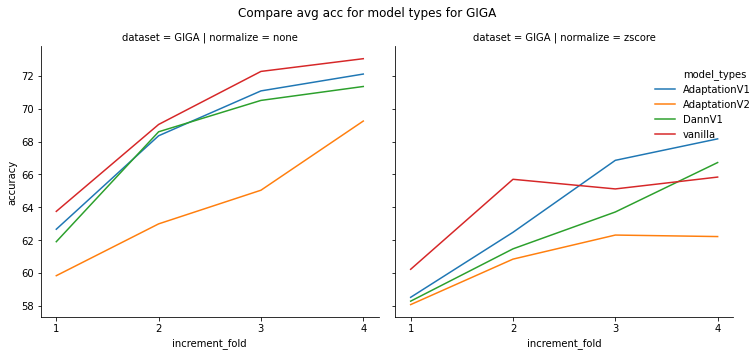

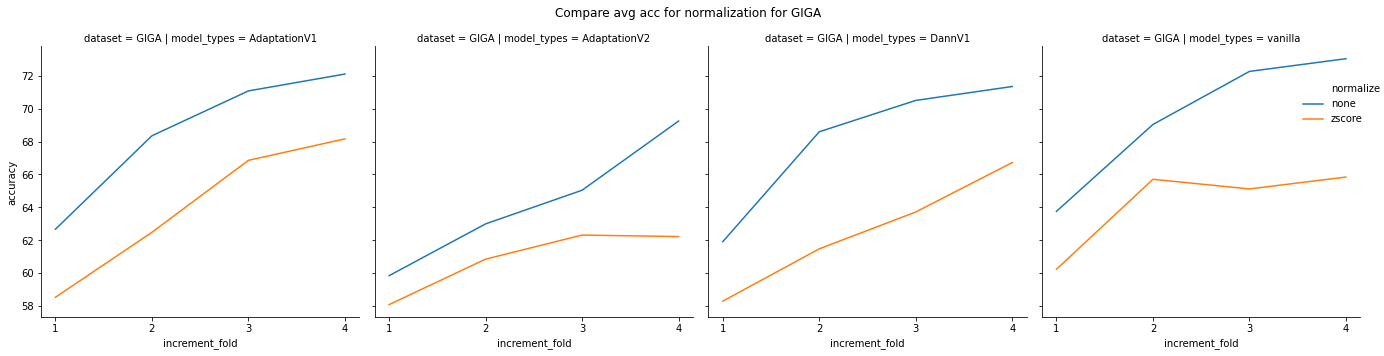

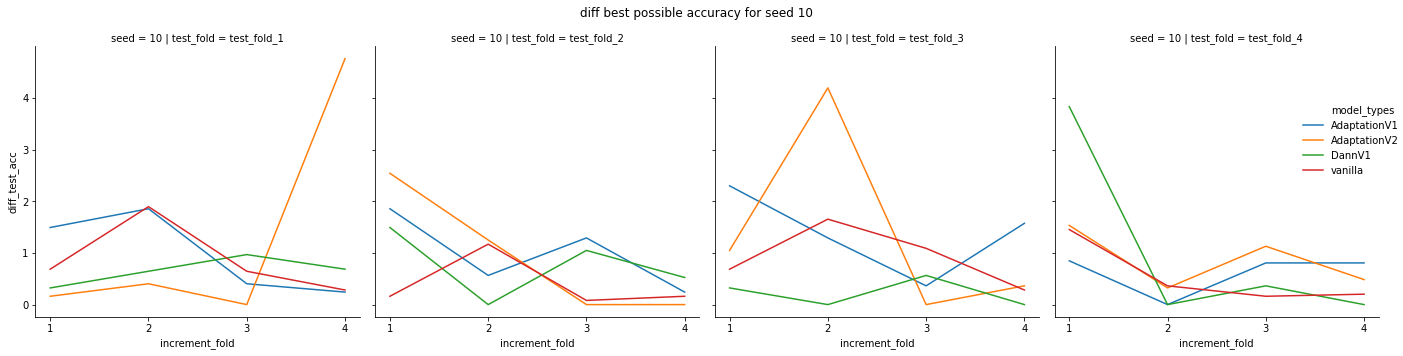

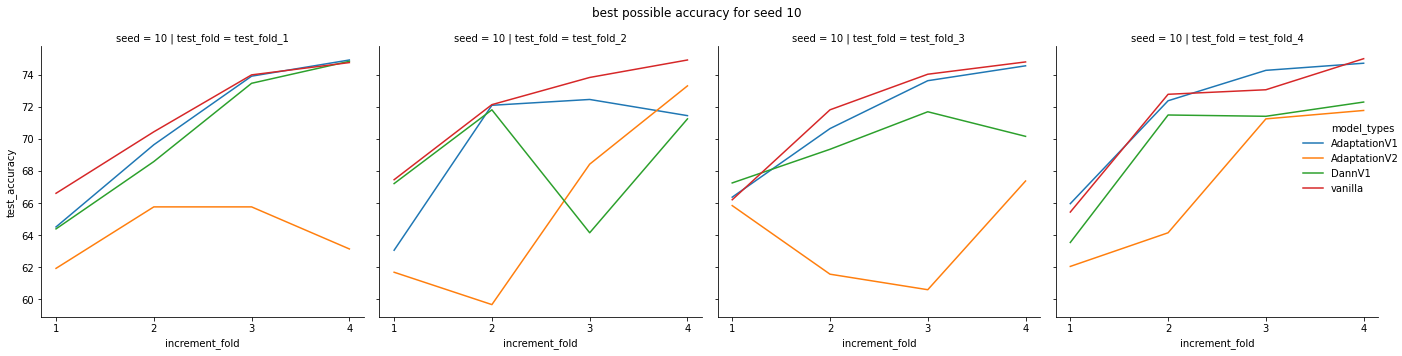

In [101]:
#study case 2 
conditions = [
    ["model_types",["vanilla","AdaptationV1","AdaptationV2","DannV1"]],
    ["dataset",['GIGA']],
]
data_case_2 = filter_history_information(data_result,conditions)
# data_case_2 = data_result
group_format = data_case_2.groupby(["seed","normalize","dataset","increment_fold","model_types"],as_index=False).mean()
avg_group_format = data_case_2.groupby(["normalize","dataset","increment_fold","model_types"],as_index=False).mean()
# print(avg_format_plot_report_v0)
# table = pd.pivot_table(group_format, values=['accuracy'], index=['seed','dataset','model_types','normalize'],columns=['increment_fold'])
# print(table)

table = pd.pivot_table(group_format, values=['accuracy'], index=['dataset','model_types','normalize'],columns=['increment_fold'])
print(table)
# output_path = os.path.join(save_data_folder,'study_case_2_avg_results_table.xlsx')
# table.to_excel(output_path)

#view and observe the results for different increment fold for model types
a = sns.relplot(
    data=avg_group_format,x="increment_fold", y="accuracy", row="dataset",col="normalize",
    hue="model_types", kind="line", aspect = 0.9
)
leg = a._legend
leg.set_bbox_to_anchor([1,0.7])
a.add_legend()
a.fig.suptitle("Compare avg acc for model types for GIGA ")
a.fig.subplots_adjust(top=0.87)
save_fig_path = os.path.join(save_graph_folder,'study_case_2_avg_acc_model_types.png')
a.savefig(save_fig_path)

b = sns.relplot(
    data=avg_group_format,x="increment_fold", y="accuracy", row="dataset",col="model_types",
    hue="normalize", kind="line", aspect = 0.9
)
leg = b._legend
leg.set_bbox_to_anchor([1,0.7])
b.add_legend()
b.fig.suptitle("Compare avg acc for normalization for GIGA")
b.fig.subplots_adjust(top=0.87)
save_fig_path = os.path.join(save_graph_folder,'study_case_2_avg_acc_normalize.png')
b.savefig(save_fig_path)

# conditions = [
#     ["normalize",["none"]],
# ]
# group_format_1 = filter_history_information(group_format,conditions)
# c = sns.relplot(
#     data=group_format_1,x="increment_fold", y="accuracy", row="dataset",col="seed",
#     hue="model_types", kind="line", aspect = 0.9
# )
# leg = c._legend
# leg.set_bbox_to_anchor([1,0.7])
# c.add_legend()
# c.fig.suptitle("Compare acc results without normalization ")
# c.fig.subplots_adjust(top=0.92)
# save_fig_path = os.path.join(save_graph_folder,'study_case_1_acc_without_normalize.png')
# c.savefig(save_fig_path)


# #view and compare training process result for 1 shuffle seed for 4 test fold. 


conditions = [
    ["model_types",["vanilla","AdaptationV1","AdaptationV2","DannV1"]],
    ["normalize",["none"]],
    ["seed",[10]],
    ["dataset",["GIGA"]]
]
history_data_1 = filter_history_information(history_data,conditions)
# f = sns.relplot(
#     data=history_data_1,x="epoch", y="val_loss", col="increment_fold",row="test_fold",
#     hue="model_types", kind="line", aspect = 0.9
# )
# leg = f._legend
# leg.set_bbox_to_anchor([1,0.6])
# f.add_legend()
# f.fig.suptitle("val loss GIGA for seed 10 without normalize")
# f.fig.subplots_adjust(top=0.92)
# save_fig_path = os.path.join(save_graph_folder,'study_case_1_val_loss_GIGA.png')
# f.savefig(save_fig_path)


# g = sns.relplot(
#     data=history_data_1,x="epoch", y="test_accuracy", col="increment_fold",row="test_fold",
#     hue="model_types", kind="line", aspect = 0.9
# )
# leg = g._legend
# leg.set_bbox_to_anchor([1,0.6])
# g.add_legend()
# g.fig.suptitle("test accuracy GIGA for seed 10 without normalize")
# g.fig.subplots_adjust(top=0.92)
# save_fig_path = os.path.join(save_graph_folder,'study_case_1_test_acc_GIGA.png')
# g.savefig(save_fig_path)

conditions = [
#     ["model_types",["vanilla","AdaptationV1","AdaptationV2","DannV1"]],
    ["normalize",["none"]],
    ["seed",[10]],
    ["dataset",["GIGA"]]

]
print("history col : ",summary_history.columns)
summary_history_1 = filter_history_information(summary_history,conditions)
# print(summary_history_1)
format_summary = summary_history_1.groupby(["seed","dataset","test_fold","increment_fold","model_types","model_choice"],as_index=False).mean()
format_summary['diff_test_acc'] = format_summary['test_accuracy'] - format_summary['test_accuracy'].shift(-1)
def set_zeros(row):
    if row['model_choice'] == 'picked_epoch':
        return 0.0
    else:
        return row['diff_test_acc']
format_summary['diff_test_acc'] = format_summary.apply(lambda row: set_zeros(row), axis=1)
# print(format_summary)

table = pd.pivot_table(format_summary, values=['diff_test_acc'], index=['seed','dataset','test_fold','model_types','model_choice'],columns=['increment_fold'])
# print(table)
# output_path = os.path.join(save_data_folder,'study_case_1_different_pick_against_best_model_table.xlsx')
# table.to_excel(output_path)

table = pd.pivot_table(format_summary, values=['test_accuracy'], index=['seed','dataset','test_fold','model_types','model_choice'],columns=['increment_fold'])
# print(table)
# output_path = os.path.join(save_data_folder,'study_case_1_compare_pick_model_choice_results_table.xlsx')
# table.to_excel(output_path)

conditions = [
    ["model_types",["vanilla","AdaptationV1","AdaptationV2","DannV1"]],
#         ["model_types",["vanilla","Adaptation","Dann"]],

    ["seed",[10]],
    ["model_choice",["best_possible_epoch"]],
    ["dataset",["GIGA"]]
]

format_summary = filter_history_information(format_summary,conditions)

h = sns.relplot(
    data=format_summary,x="increment_fold", y="diff_test_acc", col="test_fold",row="seed",
    hue="model_types", kind="line", aspect = 0.9
)
leg = h._legend
leg.set_bbox_to_anchor([1,0.6])
h.add_legend()
h.fig.suptitle("diff best possible accuracy for seed 10")
h.fig.subplots_adjust(top=0.87)
save_fig_path = os.path.join(save_graph_folder,'study_case_2_diff_best_possible_acc.png')
h.savefig(save_fig_path)


t = sns.relplot(
    data=format_summary,x="increment_fold", y="test_accuracy", col="test_fold",row="seed",
    hue="model_types", kind="line", aspect = 0.9
)
leg = t._legend
leg.set_bbox_to_anchor([1,0.55])
t.add_legend()
t.fig.suptitle("best possible accuracy for seed 10")
t.fig.subplots_adjust(top=0.87)
save_fig_path = os.path.join(save_graph_folder,'study_case_2_best_possible_acc.png')
t.savefig(save_fig_path)


      seed normalize dataset    test_fold increment_fold    valid_fold  \
0        0      none  BCI_IV  test_fold_1              1  valid_fold_1   
1        0      none  BCI_IV  test_fold_1              1  valid_fold_1   
2        0      none  BCI_IV  test_fold_1              1  valid_fold_1   
3        0      none  BCI_IV  test_fold_1              1  valid_fold_1   
4        0      none  BCI_IV  test_fold_1              1  valid_fold_1   
...    ...       ...     ...          ...            ...           ...   
6795     0      none  BCI_IV  test_fold_4              3  valid_fold_1   
6796     0      none  BCI_IV  test_fold_4              3  valid_fold_1   
6797     0      none  BCI_IV  test_fold_4              3  valid_fold_1   
6798     0      none  BCI_IV  test_fold_4              3  valid_fold_1   
6799     0      none  BCI_IV  test_fold_4              3  valid_fold_1   

     model_types                                       history_path  \
0        vanilla  C:\wduong_folder\Dassl

Text(0.5, 0.98, 'check  test acc')

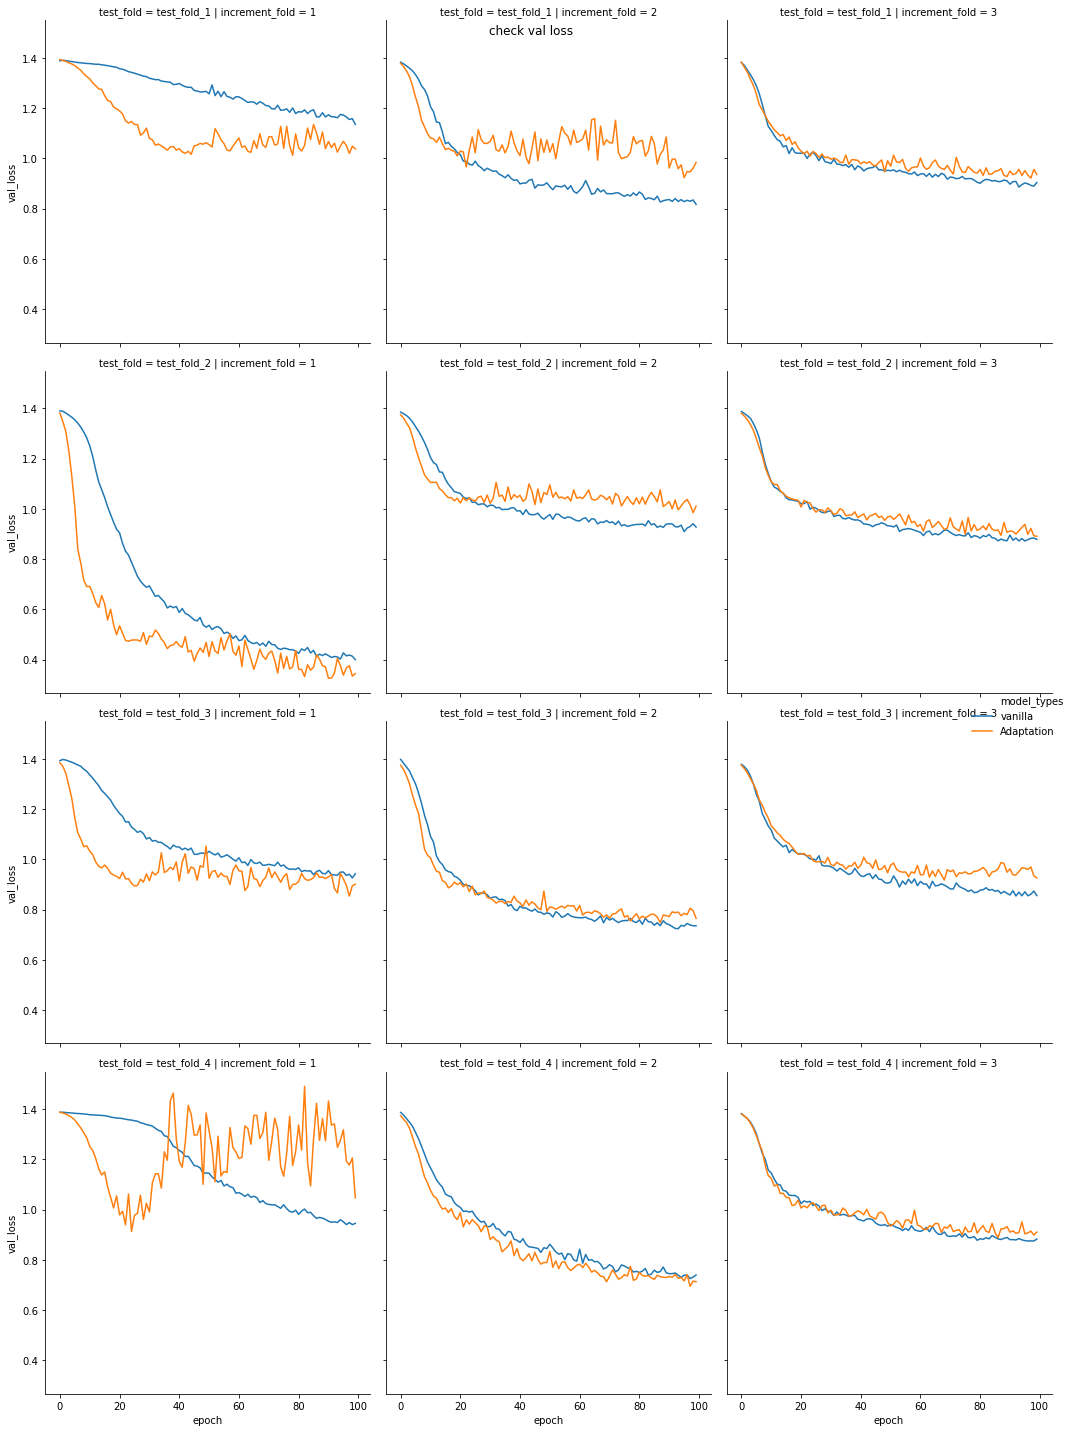

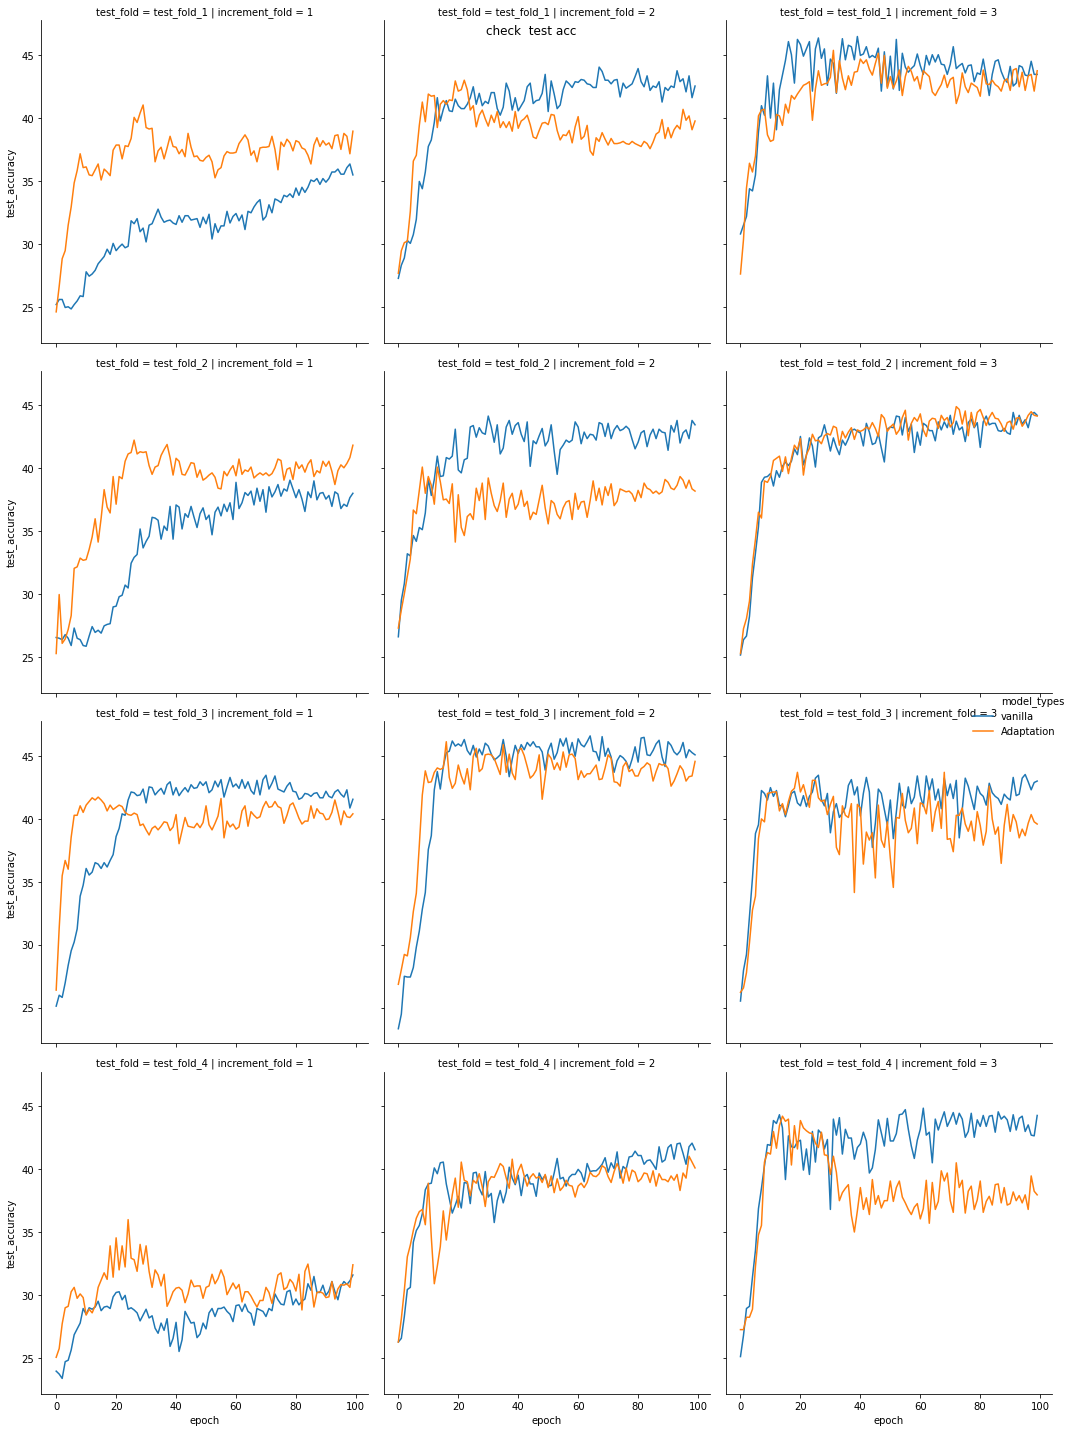

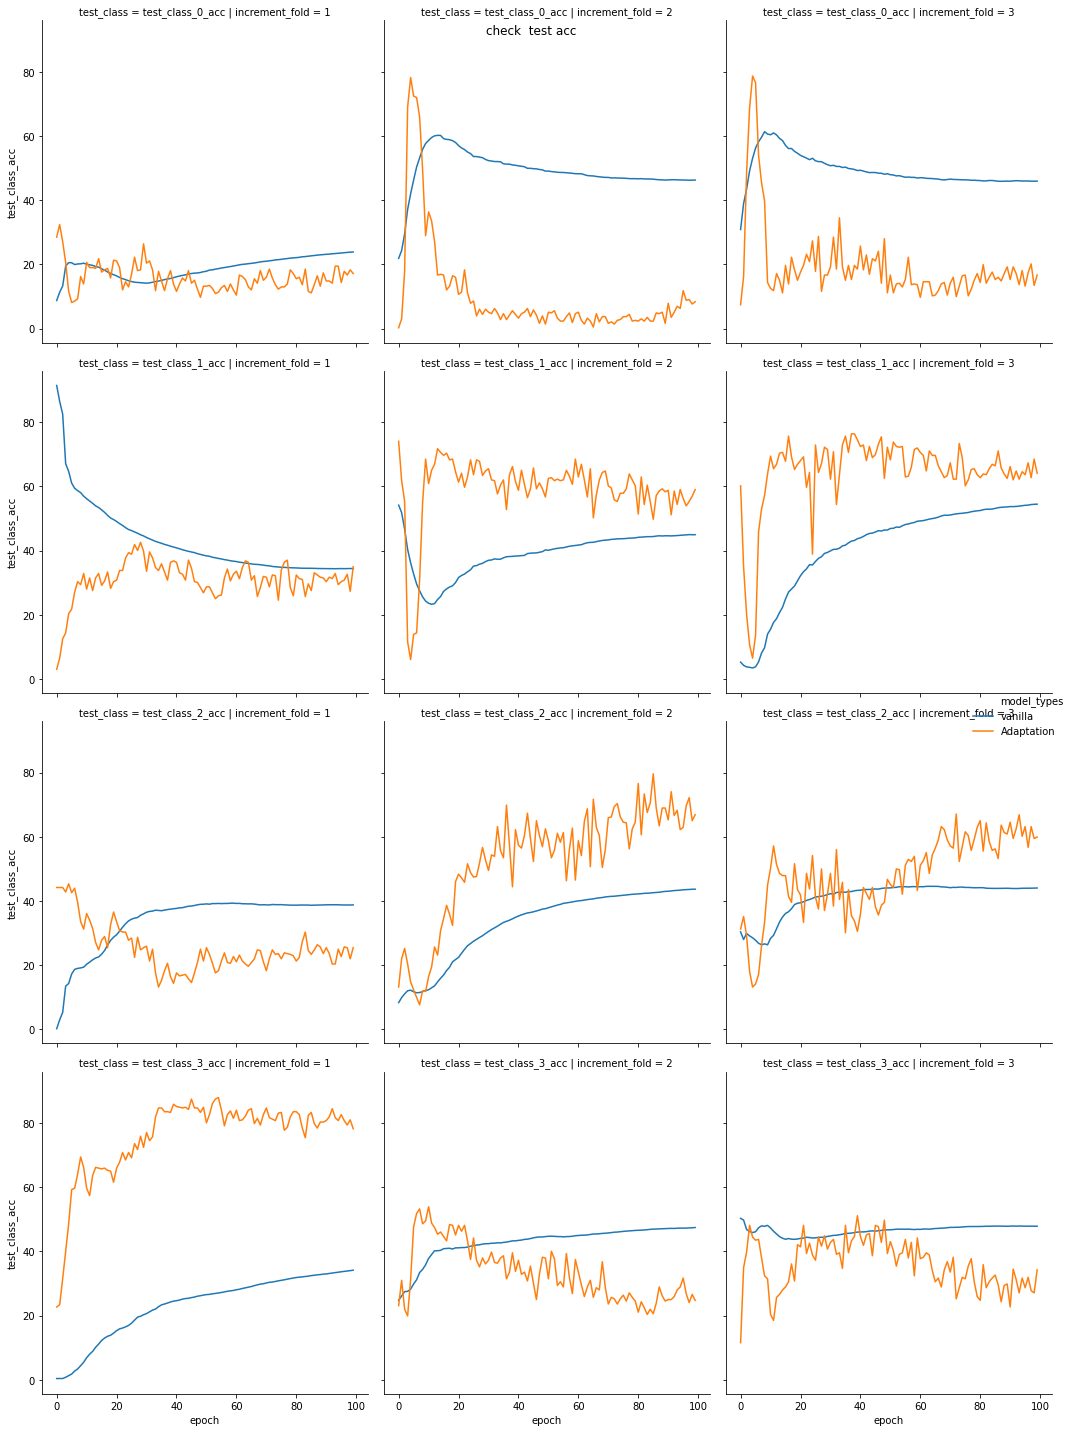

In [48]:
#view the history results for BCI_IV\
conditions = [
    ["dataset",["BCI_IV"]],
    ["seed",[0]],
    ["normalize",["none"]],
#     ["test_fold",["test_fold_1"]]
]
history_data['increment_fold'] = history_data['increment_fold'].replace(['increment_fold_1','increment_fold_2','increment_fold_3','increment_fold_4'],['1','2','3','4'])
BCI_IV_data = filter_history_information(history_data,conditions)
print(BCI_IV_data)
a = sns.relplot(
    data=BCI_IV_data,x="epoch", y="val_loss", col="increment_fold",row="test_fold",
    hue="model_types", kind="line", aspect = 0.9
)
a.add_legend()
a.fig.suptitle("check val loss")


# BCI_IV_data = filter_history_information(history_data,conditions)
a = sns.relplot(
    data=BCI_IV_data,x="epoch", y="test_accuracy", col="increment_fold",row="test_fold",
    hue="model_types", kind="line", aspect = 0.9
)
a.add_legend()
a.fig.suptitle("check  test acc")

#analyze test fold 1 further for each class prediction
conditions = [
    ["dataset",["BCI_IV"]],
    ["seed",[0]],
    ["normalize",["none"]],
    ["test_fold",["test_fold_1"]]
]
BCI_IV_data = filter_history_information(history_data,conditions)
keys = [c for c in BCI_IV_data if c.startswith('test_class_')]
id_vars =[col for col in BCI_IV_data.columns if not col in keys]
BCI_IV_data = pd.melt(BCI_IV_data,id_vars = id_vars ,value_vars=keys, value_name='test_class_acc')
BCI_IV_data = BCI_IV_data.rename(columns={"variable": "test_class"})
# print("update data : ",BCI_IV_data.head())
print("plot detail result for BCI_IV")
a = sns.relplot(
    data=BCI_IV_data,x="epoch", y="test_class_acc", col="increment_fold",row="test_class",
    hue="model_types", kind="line", aspect = 0.9
)
a.add_legend()
a.fig.suptitle("check  test acc")

#based on the observation it seems that the transfer learning adaptation boost performance on class 0 for test fold 1 accorss all 3 seed
# we know that the source dataset has 2 classes (left, right hand) so it makes sense to boost performance of right hand. It is questionable about the left hand scneario
#performance on class 2 and 3 (feet and tounge) is degerated (negative transfer learning) in most scenario. However, it isn't all for every scenario

       seed normalize dataset    test_fold increment_fold    valid_fold  \
49200    10      none    GIGA  test_fold_1              1  valid_fold_1   
49201    10      none    GIGA  test_fold_1              1  valid_fold_1   
49202    10      none    GIGA  test_fold_1              1  valid_fold_1   
49203    10      none    GIGA  test_fold_1              1  valid_fold_1   
49204    10      none    GIGA  test_fold_1              1  valid_fold_1   
...     ...       ...     ...          ...            ...           ...   
50795    10      none    GIGA  test_fold_4              4  valid_fold_1   
50796    10      none    GIGA  test_fold_4              4  valid_fold_1   
50797    10      none    GIGA  test_fold_4              4  valid_fold_1   
50798    10      none    GIGA  test_fold_4              4  valid_fold_1   
50799    10      none    GIGA  test_fold_4              4  valid_fold_1   

      model_types                                       history_path  \
49200     vanilla  C:\wduon

Text(0.5, 0.98, 'check  test acc')

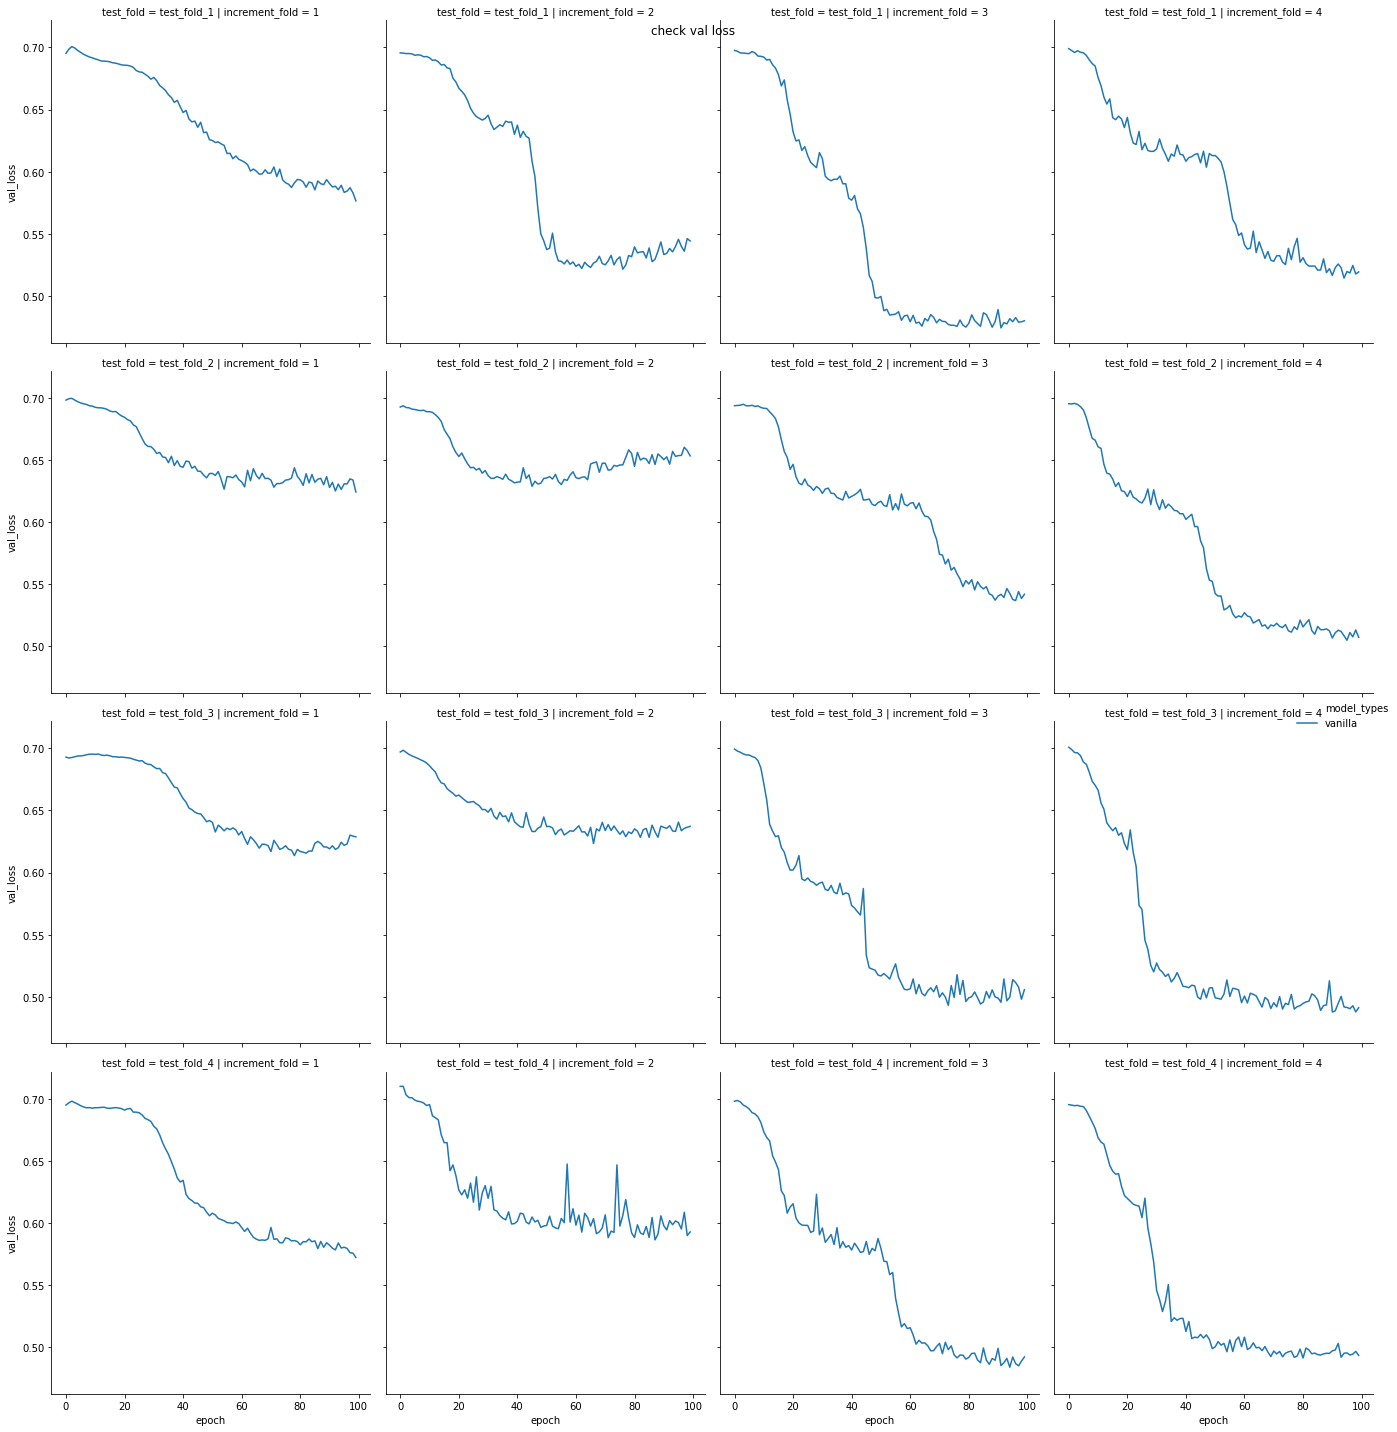

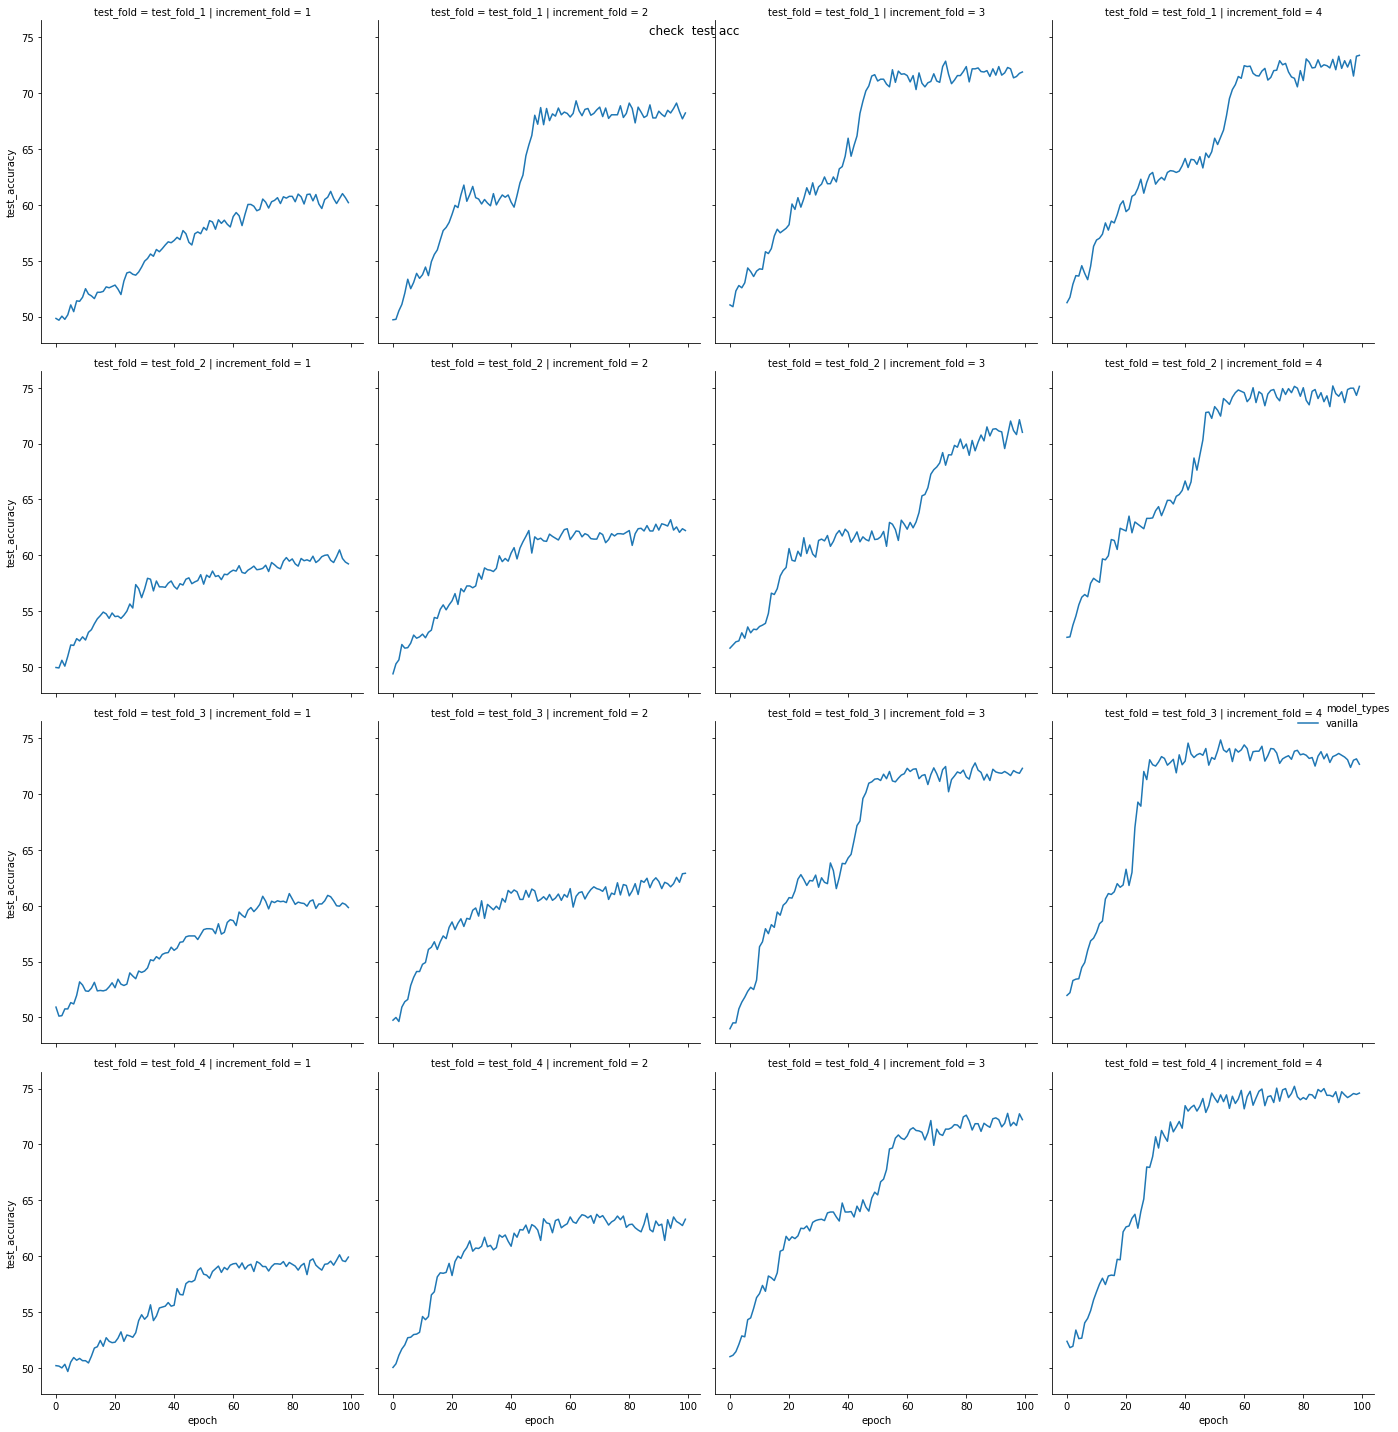

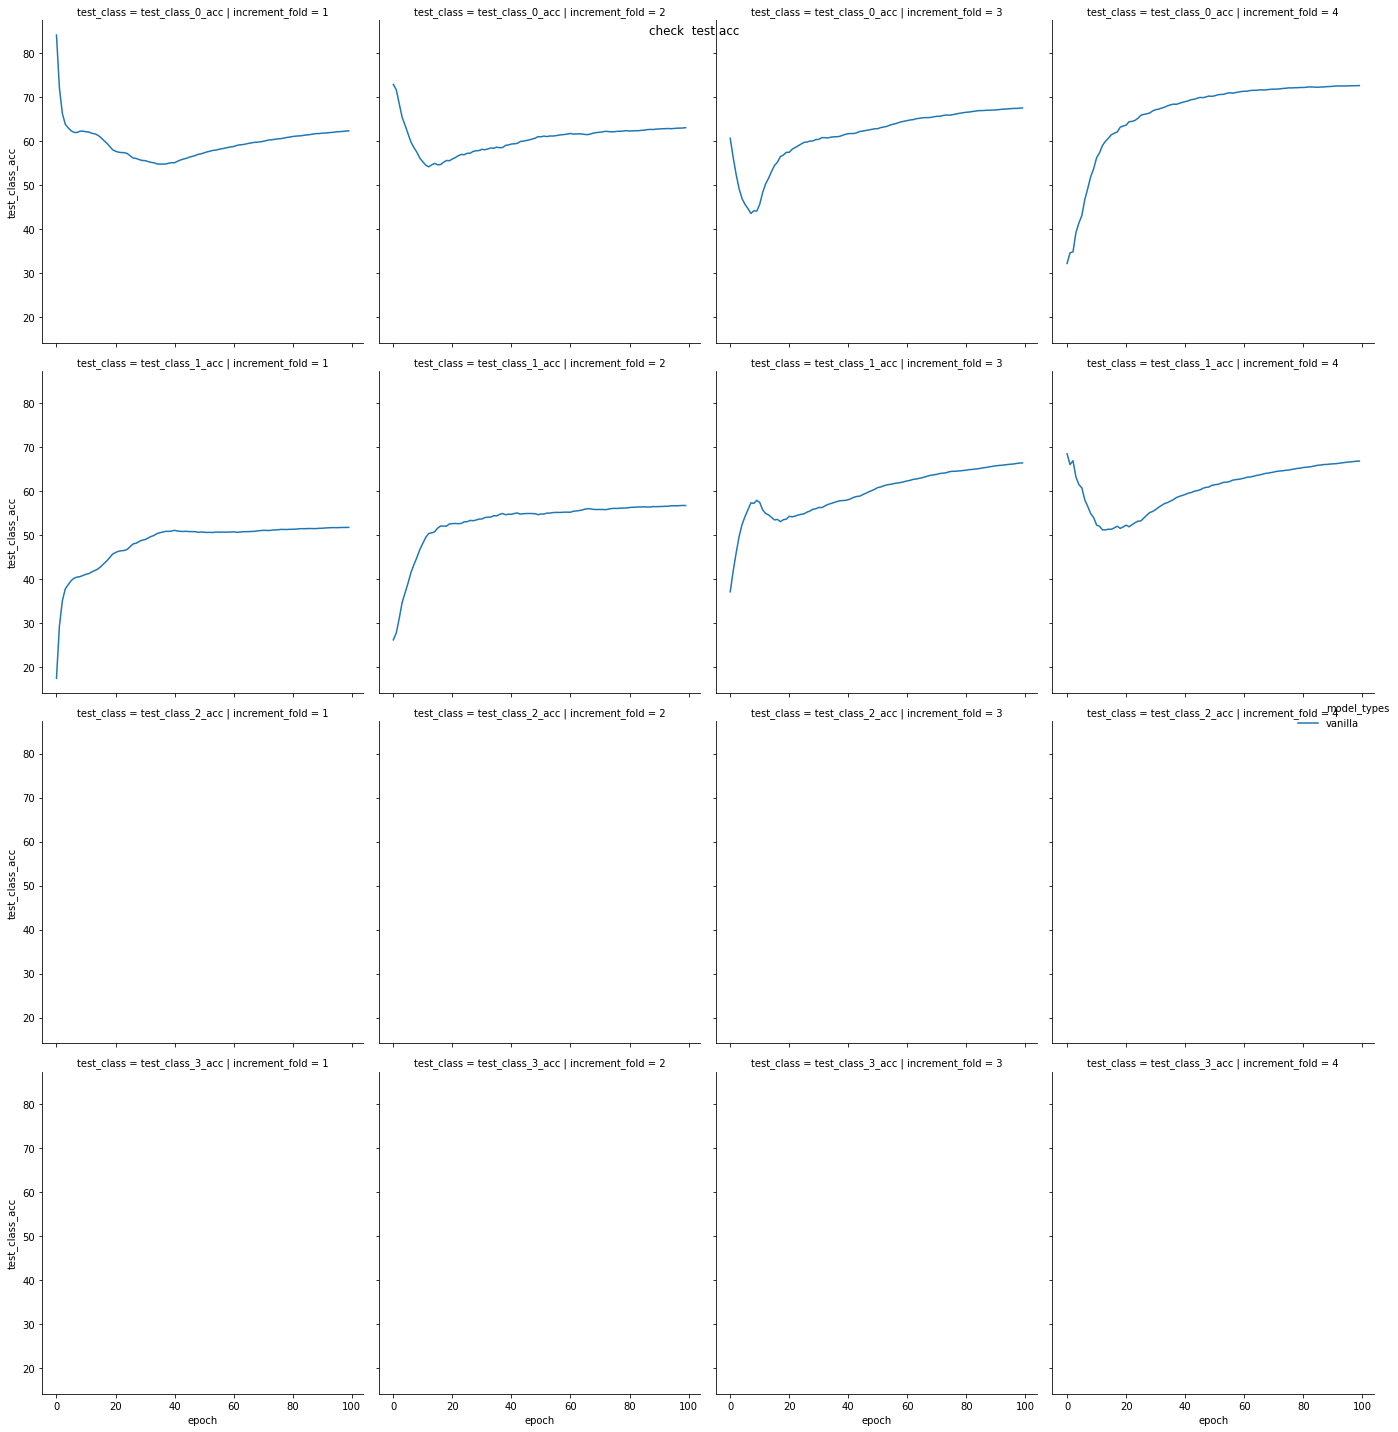

In [49]:
#analyze from BCI_IV transfer learning to GIGA for adaptation vs vanilla comparision
conditions = [
    ["dataset",["GIGA"]],
    ["seed",[10]],
    ["normalize",["none"]],
    ["model_types",["vanilla","adapt_equal","adapt"]]

#     ["test_fold",["test_fold_1"]]
]
history_data['increment_fold'] = history_data['increment_fold'].replace(['increment_fold_1','increment_fold_2','increment_fold_3','increment_fold_4'],['1','2','3','4'])
GIGA_data = filter_history_information(history_data,conditions)
print(GIGA_data)
a = sns.relplot(
    data=GIGA_data,x="epoch", y="val_loss", col="increment_fold",row="test_fold",
    hue="model_types", kind="line", aspect = 0.9
)
a.add_legend()
a.fig.suptitle("check val loss")


a = sns.relplot(
    data=GIGA_data,x="epoch", y="test_accuracy", col="increment_fold",row="test_fold",
    hue="model_types", kind="line", aspect = 0.9
)
a.add_legend()
a.fig.suptitle("check  test acc")

# #analyze test fold 1 further for each class prediction
conditions = [
    ["dataset",["GIGA"]],
    ["seed",[10]],
    ["normalize",["none"]],
    ["model_types",["vanilla","adapt_equal","adapt"]],
    ["test_fold",["test_fold_3"]]
]
GIGA_data = filter_history_information(history_data,conditions)
keys = [c for c in GIGA_data if c.startswith('test_class_')]
id_vars =[col for col in GIGA_data.columns if not col in keys]
print("id vars : ",id_vars)
GIGA_data = pd.melt(GIGA_data,id_vars = id_vars ,value_vars=keys, value_name='test_class_acc')
GIGA_data = GIGA_data.rename(columns={"variable": "test_class"})
# print("update data : ",BCI_IV_data.head())
print("plot detail result for BCI_IV")
a = sns.relplot(
    data=GIGA_data,x="epoch", y="test_class_acc", col="increment_fold",row="test_class",
    hue="model_types", kind="line", aspect = 0.9
)
a.add_legend()
a.fig.suptitle("check  test acc")



       seed normalize dataset    test_fold increment_fold    valid_fold  \
49200    10      none    GIGA  test_fold_1              1  valid_fold_1   
49201    10      none    GIGA  test_fold_1              1  valid_fold_1   
49202    10      none    GIGA  test_fold_1              1  valid_fold_1   
49203    10      none    GIGA  test_fold_1              1  valid_fold_1   
49204    10      none    GIGA  test_fold_1              1  valid_fold_1   
...     ...       ...     ...          ...            ...           ...   
50795    10      none    GIGA  test_fold_4              4  valid_fold_1   
50796    10      none    GIGA  test_fold_4              4  valid_fold_1   
50797    10      none    GIGA  test_fold_4              4  valid_fold_1   
50798    10      none    GIGA  test_fold_4              4  valid_fold_1   
50799    10      none    GIGA  test_fold_4              4  valid_fold_1   

      model_types                                       history_path  \
49200     vanilla  C:\wduon

Text(0.5, 0.98, 'check  test acc')

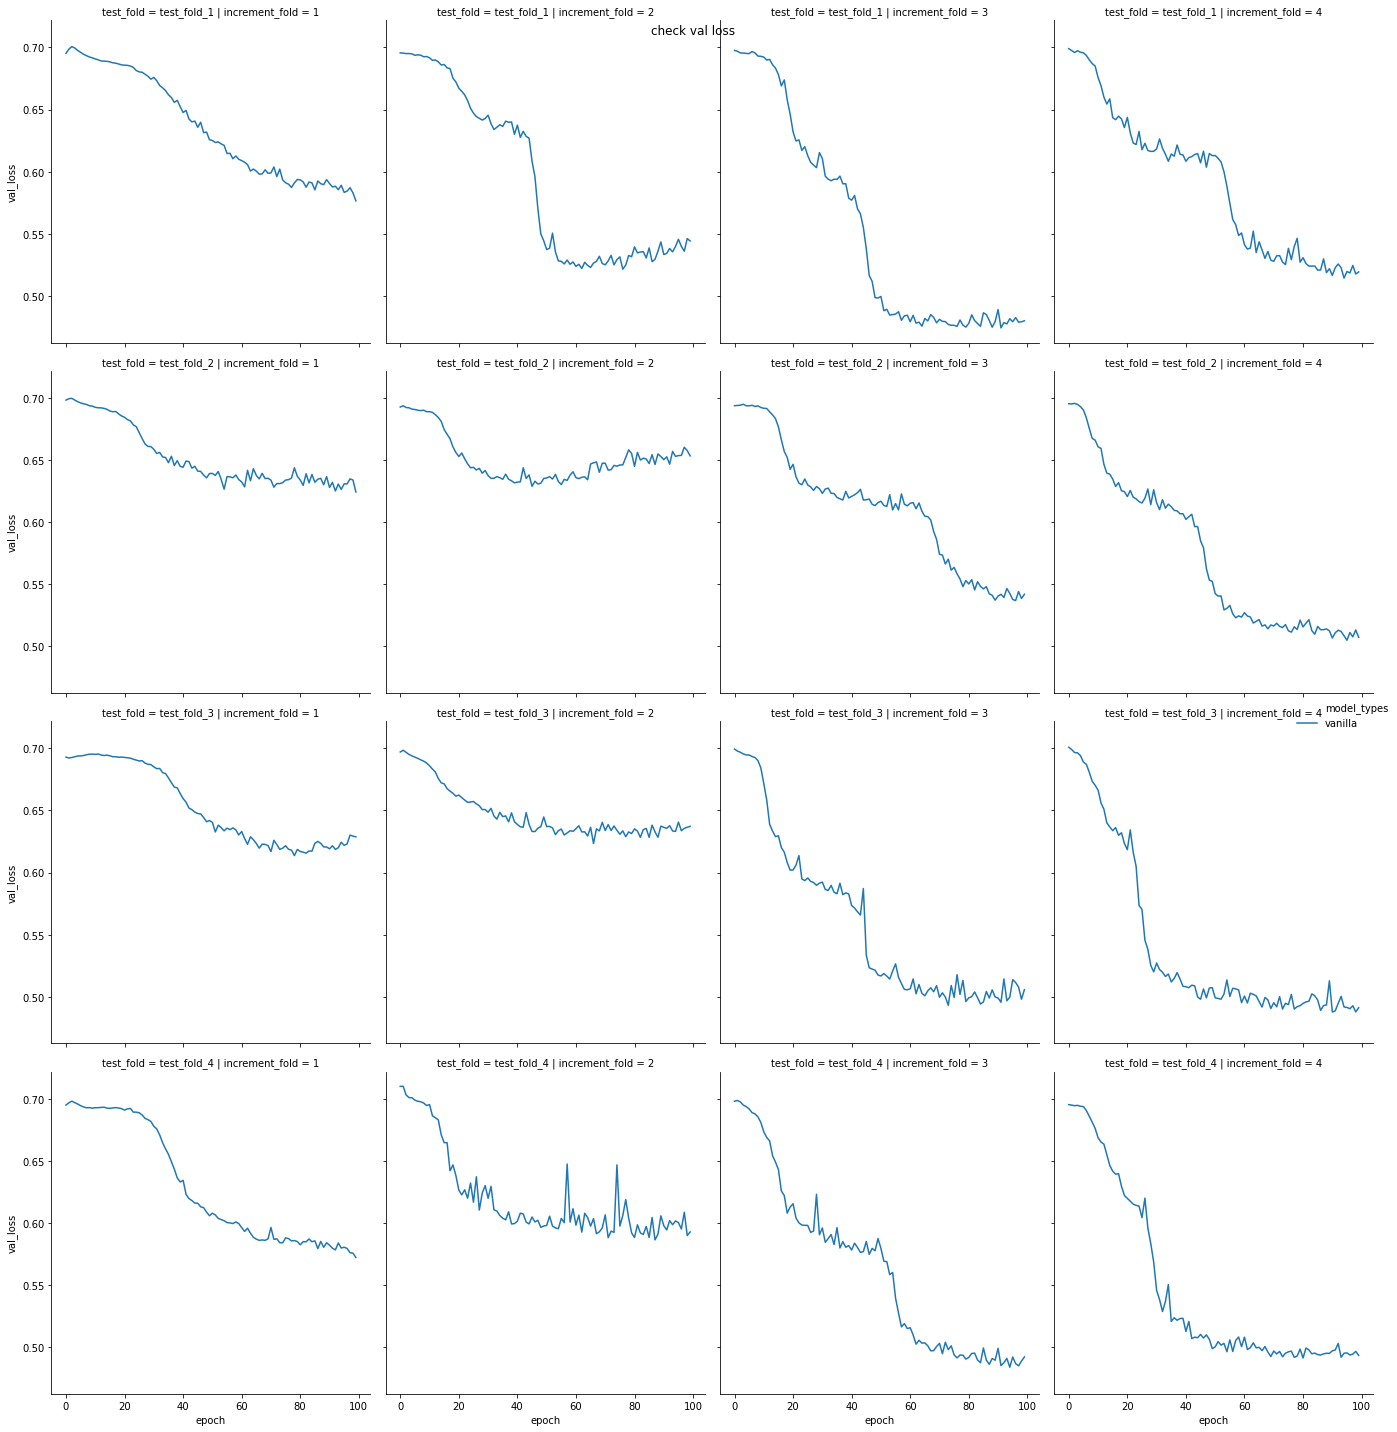

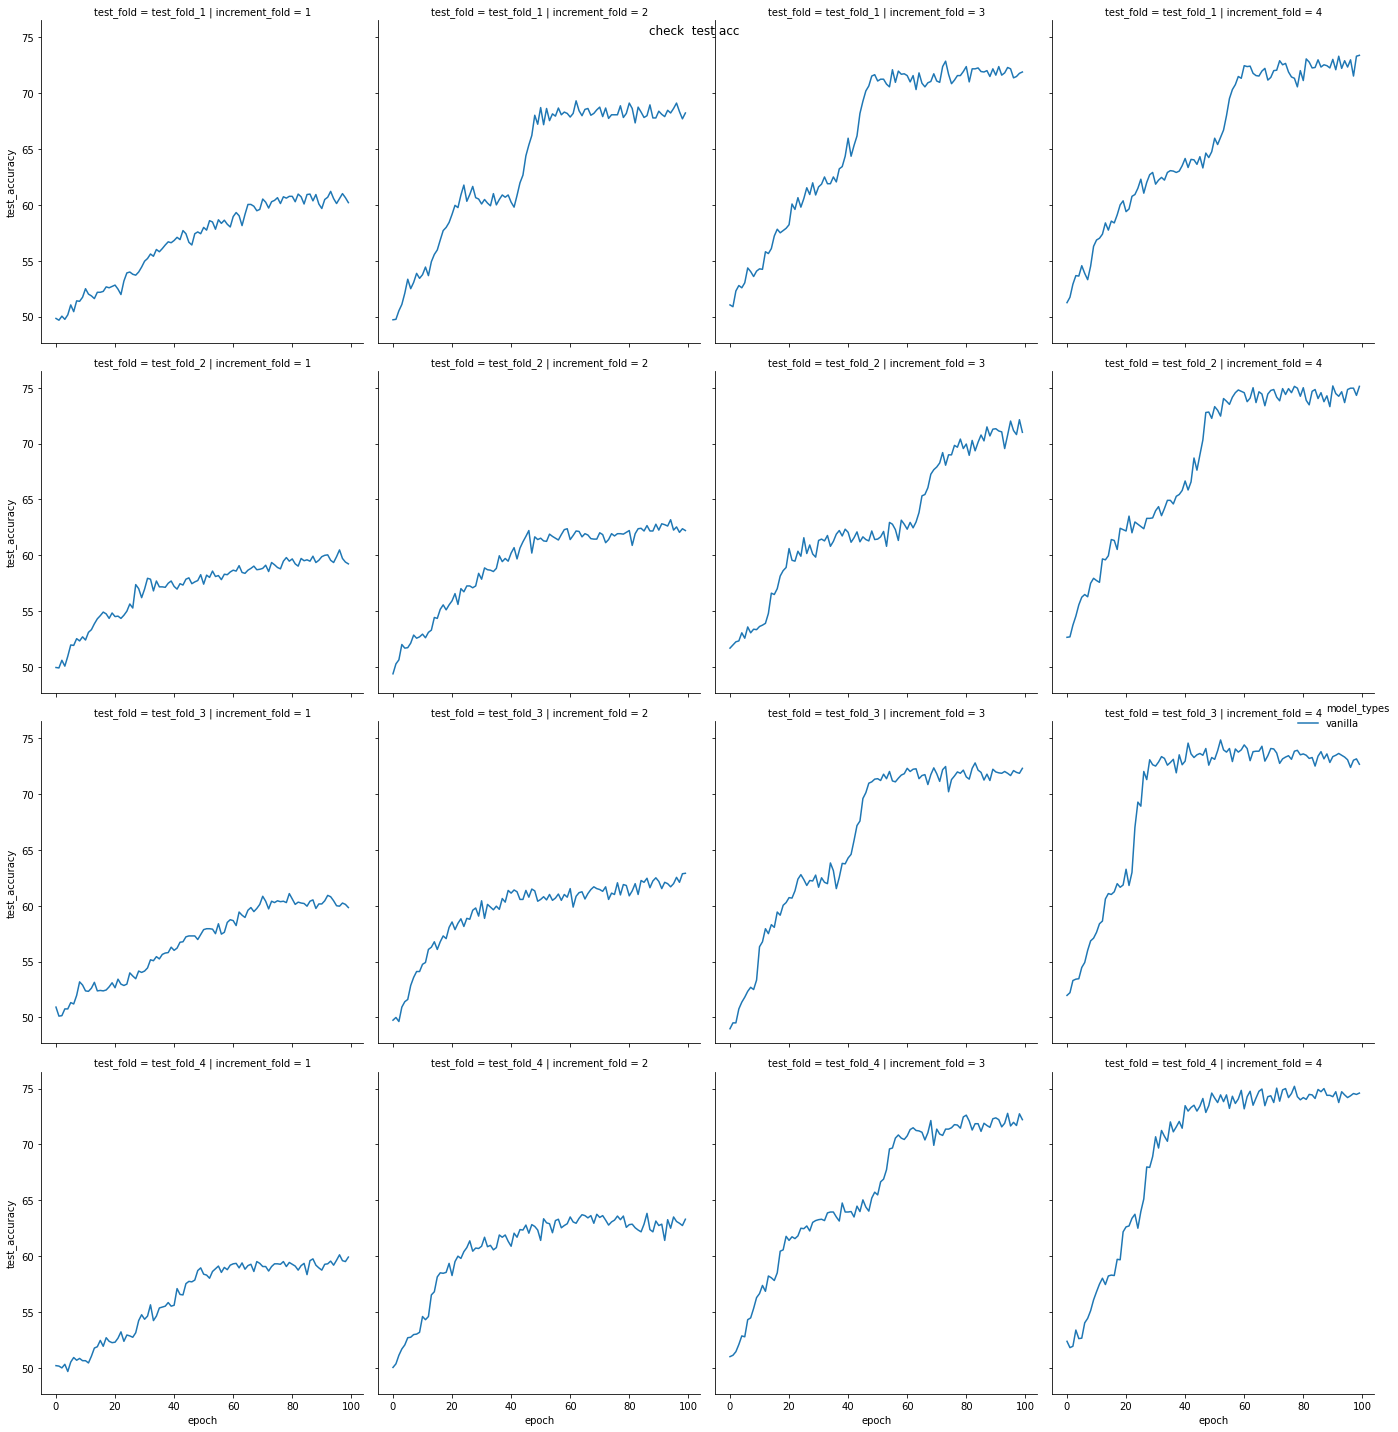

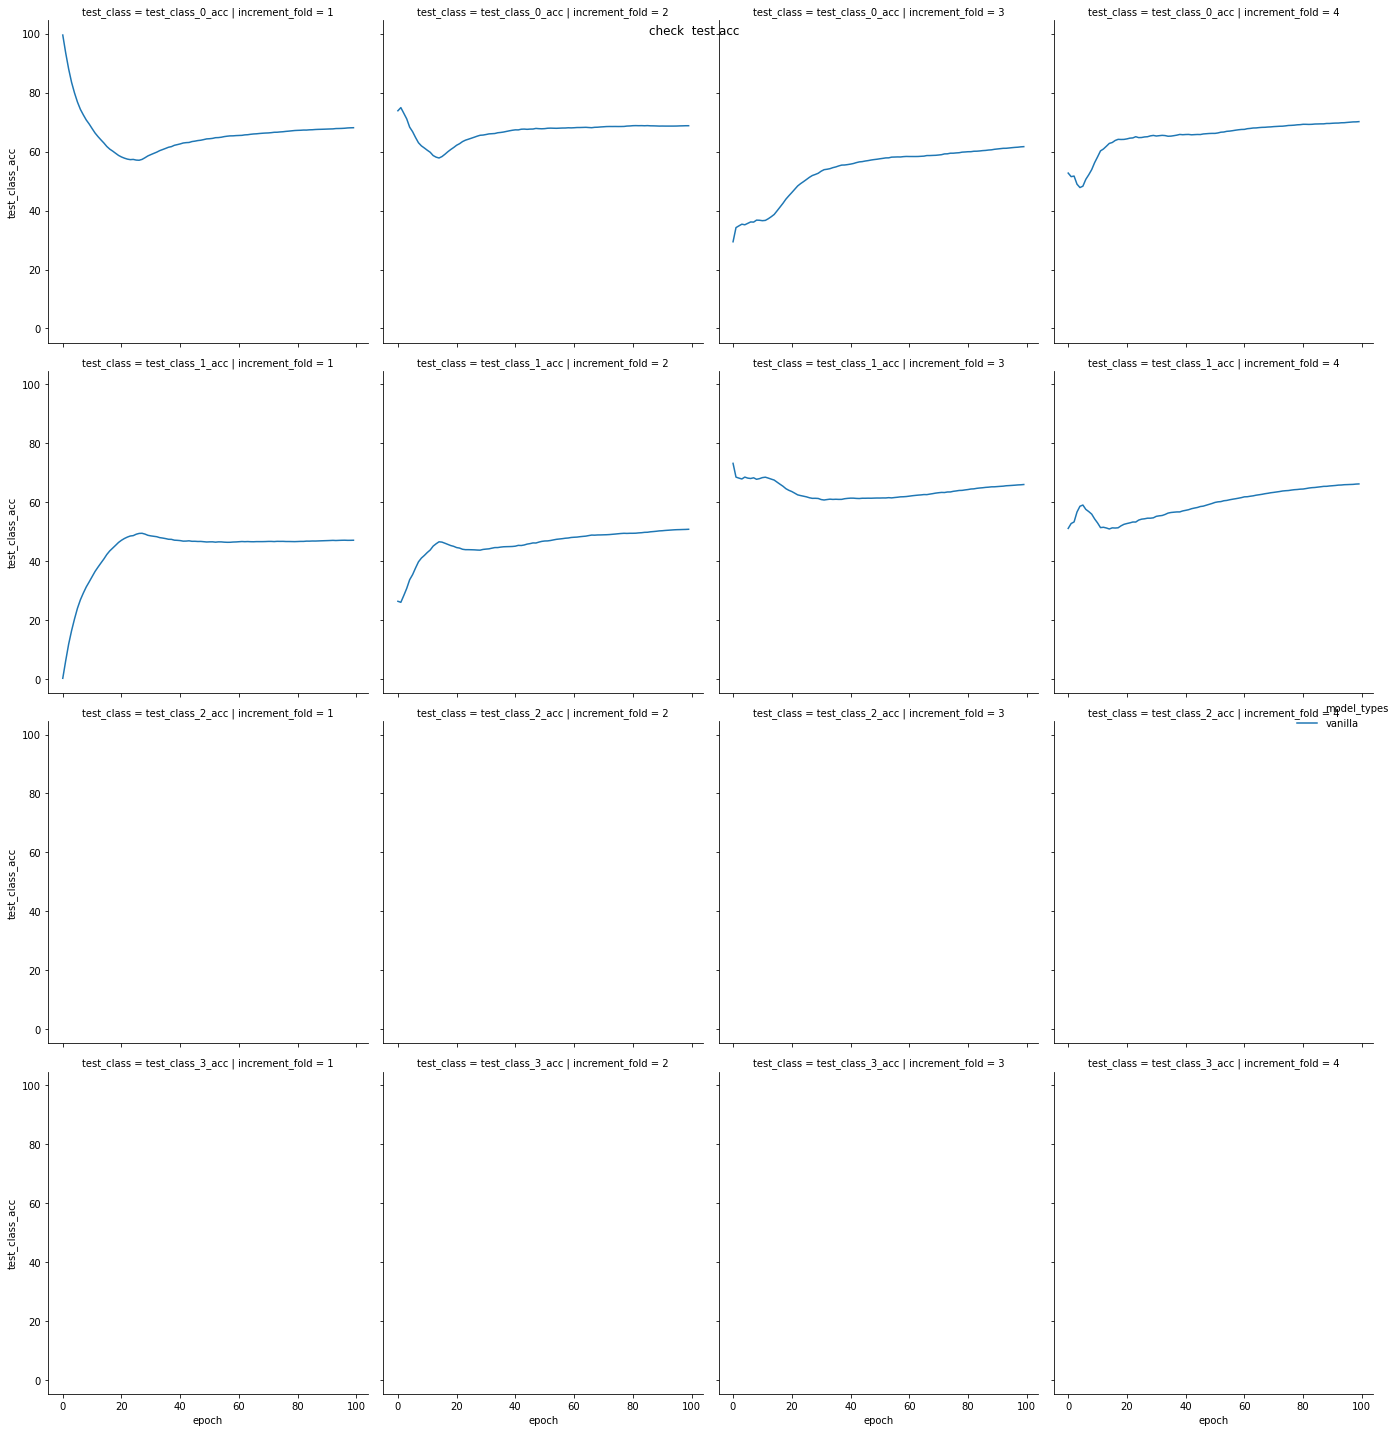

In [50]:
#analyze from BCI_IV transfer learning to GIGA for dann vs vanilla comparision
conditions = [
    ["dataset",["GIGA"]],
    ["seed",[10]],
    ["normalize",["none"]],
    ["model_types",["vanilla","dann","dann_equal"]]

#     ["test_fold",["test_fold_1"]]
]
history_data['increment_fold'] = history_data['increment_fold'].replace(['increment_fold_1','increment_fold_2','increment_fold_3','increment_fold_4'],['1','2','3','4'])
GIGA_data = filter_history_information(history_data,conditions)
print(GIGA_data)
a = sns.relplot(
    data=GIGA_data,x="epoch", y="val_loss", col="increment_fold",row="test_fold",
    hue="model_types", kind="line", aspect = 0.9
)
a.add_legend()
a.fig.suptitle("check val loss")


a = sns.relplot(
    data=GIGA_data,x="epoch", y="test_accuracy", col="increment_fold",row="test_fold",
    hue="model_types", kind="line", aspect = 0.9
)
a.add_legend()
a.fig.suptitle("check  test acc")

# #analyze test fold 1 further for each class prediction
conditions = [
    ["dataset",["GIGA"]],
    ["seed",[10]],
    ["normalize",["none"]],
    ["model_types",["vanilla","dann","dann_equal"]],
    ["test_fold",["test_fold_2"]]
]
GIGA_data = filter_history_information(history_data,conditions)
keys = [c for c in GIGA_data if c.startswith('test_class_')]
id_vars =[col for col in GIGA_data.columns if not col in keys]
print("id vars : ",id_vars)
GIGA_data = pd.melt(GIGA_data,id_vars = id_vars ,value_vars=keys, value_name='test_class_acc')
GIGA_data = GIGA_data.rename(columns={"variable": "test_class"})
# print("update data : ",BCI_IV_data.head())
print("plot detail result for BCI_IV")
a = sns.relplot(
    data=GIGA_data,x="epoch", y="test_class_acc", col="increment_fold",row="test_class",
    hue="model_types", kind="line", aspect = 0.9
)
a.add_legend()
a.fig.suptitle("check  test acc")



                                     accuracy                      
increment_fold                              1          2          3
dataset model_types normalize lmda                                 
BCI_IV  Dann        none      0.25  37.065972  39.853395  40.253665
                              0.50  36.226852  39.120370  40.195795


Text(0.5, 0.98, 'check  test acc')

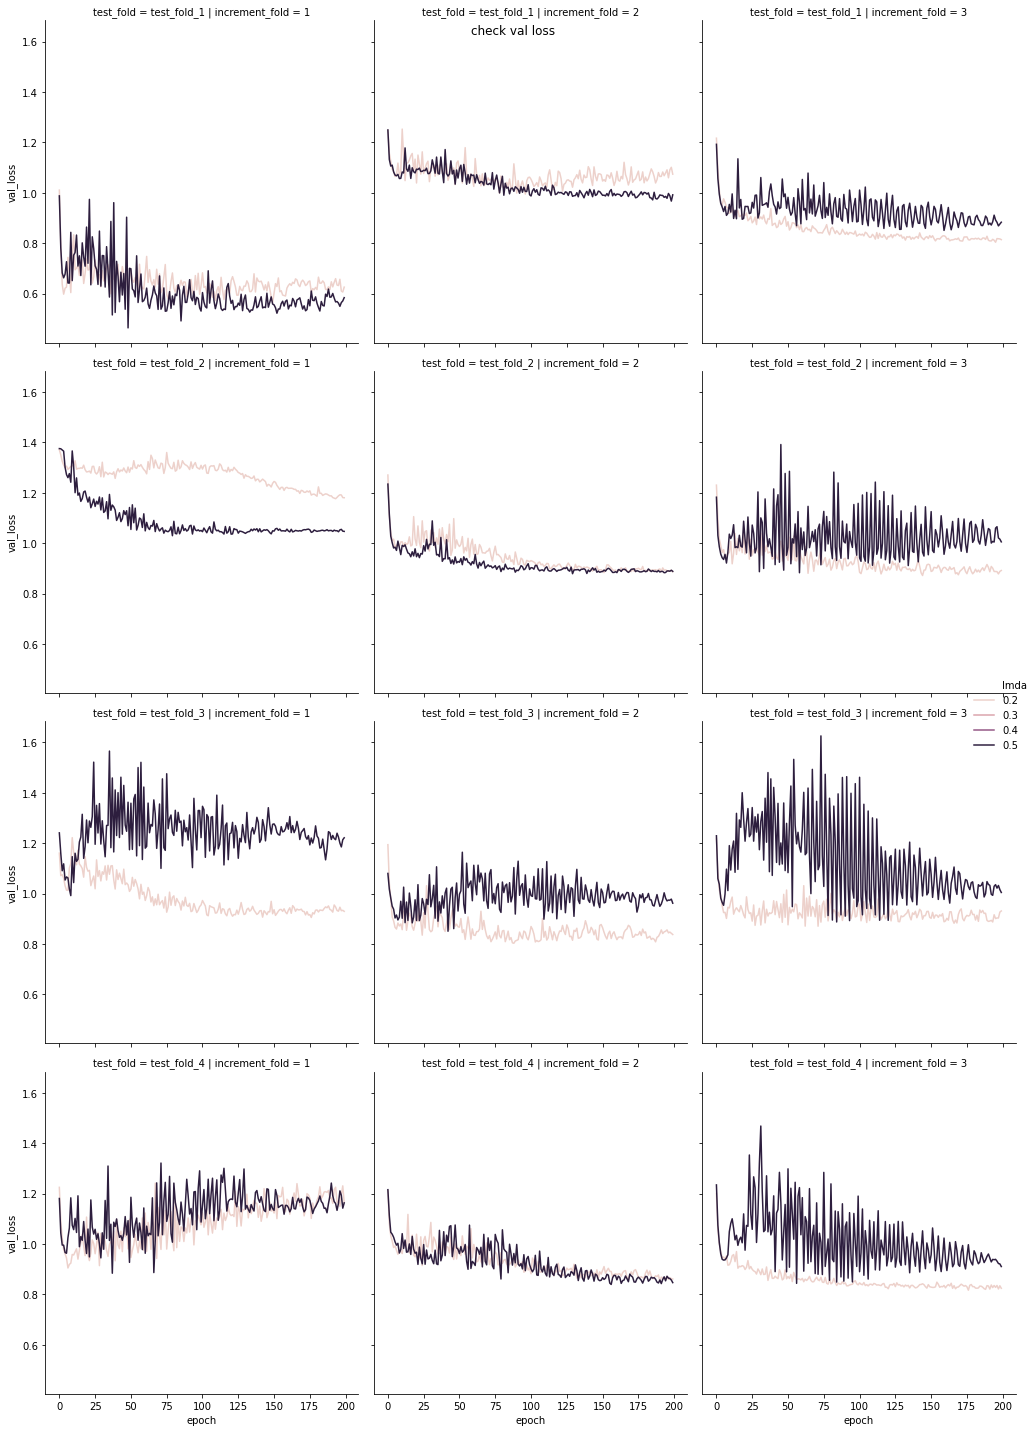

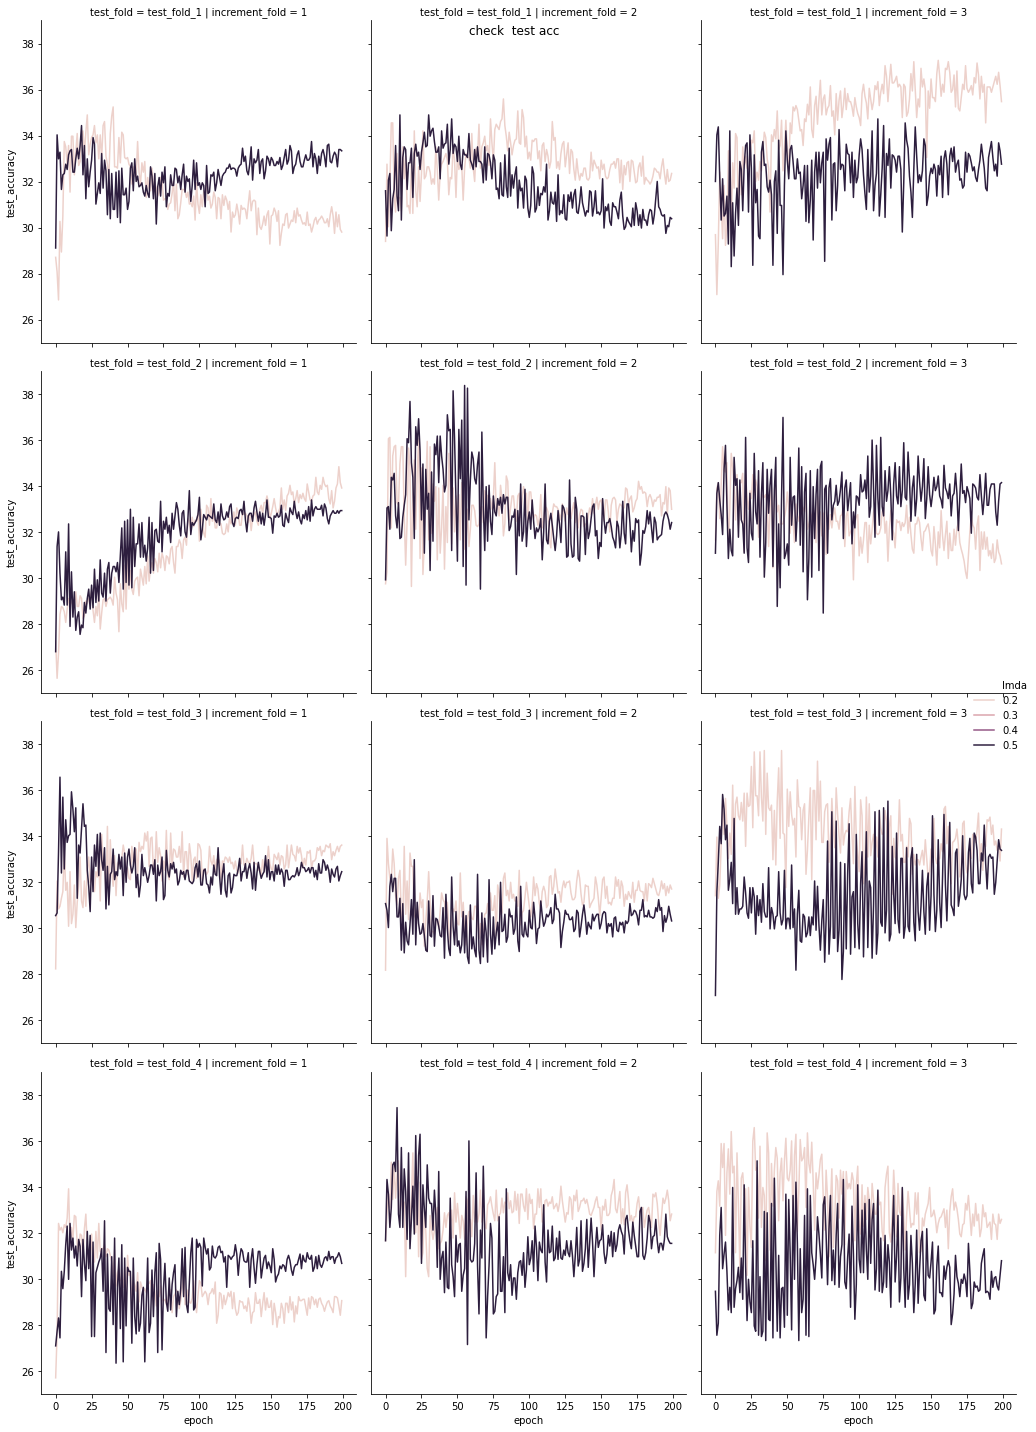

In [58]:
#compare DANN with different lmda value
# conditions = [
#     ["dataset",["GIGA"]],
#     ["model_types",["Dann"]],
# ]
# dann_data_1 = filter_history_information(data_result,conditions)
# dann_data_1_history_data = filter_history_information(history_data,conditions)

common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation_grid\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"

model_list = [
    'adapt_dann_1',
]
seed_list = [
    "seed_v0",
    "seed_v1",
    "seed_v2"
]
norm_list = [
    'norm_none',
    'norm_zscore'
     
]
model_data_prefix = [
    "BCI_IV"
]

result_folder = 'results_v1'
file_name = 'model_result..xlsx'
info_file_name = 'model_info.json'
prefix_lists = [seed_list,model_list,norm_list,model_data_prefix]
list_full_path = generate_data_paths(common_path,prefix_lists,[])
dann_data_2 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)
dann_data_2['model_types'] = dann_data_2.apply (lambda row: generate_model_types(row), axis=1)
dann_data_2['increment_fold'] = dann_data_2['increment_fold'].replace(['increment_fold_1','increment_fold_2','increment_fold_3','increment_fold_4'],['1','2','3','4'])
pick_cols = ["seed","normalize","dataset","test_fold","increment_fold","valid_fold","model_types","history_path"]
dann_data_2_summary_history = summarize_history(dann_data_2,pick_cols)
dann_data_2_history_data = load_history_data(dann_data_2,pick_cols)

model_list = [
    'adapt_dann_2',
]
prefix_lists = [seed_list,model_list,norm_list,model_data_prefix]
list_full_path = generate_data_paths(common_path,prefix_lists,[])
dann_data_3 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)
dann_data_3['model_types'] = dann_data_3.apply (lambda row: generate_model_types(row), axis=1)
dann_data_3['increment_fold'] = dann_data_3['increment_fold'].replace(['increment_fold_1','increment_fold_2','increment_fold_3','increment_fold_4'],['1','2','3','4'])
pick_cols = ["seed","normalize","dataset","test_fold","increment_fold","valid_fold","model_types","history_path"]
dann_data_3_summary_history = summarize_history(dann_data_3,pick_cols)
dann_data_3_history_data = load_history_data(dann_data_3,pick_cols)

combine_dann_data = {
#     1.0:dann_data_1,
    0.5:dann_data_2,
    0.25:dann_data_3
}
combine_dann_history_data = {
#     1.0:dann_data_1_history_data,
    0.5:dann_data_2_history_data,
    0.25:dann_data_3_history_data
}
field_name = "lmda"
dann_data = generate_concat_dataset(combine_dann_data,field_name)
dann_history_data = generate_concat_dataset(combine_dann_history_data,field_name)
dann_history_data['increment_fold'] = dann_history_data['increment_fold'].replace(['increment_fold_1','increment_fold_2','increment_fold_3','increment_fold_4'],['1','2','3','4'])

avg_combine_data = dann_data.groupby(["normalize","dataset","increment_fold","model_types","lmda",],as_index=False).mean()
table = pd.pivot_table(avg_combine_data, values=['accuracy'], index=['dataset','model_types','normalize',"lmda",],columns=['increment_fold'])
print(table)
# pick_cols = ["seed","normalize","dataset","test_fold","increment_fold","valid_fold","model_types","history_path"]
# dann_summary_history = summarize_history(dann_data,pick_cols)
# dann_history_data = load_history_data(dann_data,pick_cols)



#analyze from BCI_IV transfer learning to GIGA for dann vs vanilla comparision
conditions = [
    ["seed",[5]],
    ["normalize",["none"]],

#     ["test_fold",["test_fold_1"]]
]
GIGA_data = filter_history_information(dann_history_data,conditions)
# print(GIGA_data)
a = sns.relplot(
    data=GIGA_data,x="epoch", y="val_loss", col="increment_fold",row="test_fold",
    hue="lmda", kind="line", aspect = 0.9
)
a.add_legend()
a.fig.suptitle("check val loss")


a = sns.relplot(
    data=GIGA_data,x="epoch", y="test_accuracy", col="increment_fold",row="test_fold",
    hue="lmda", kind="line", aspect = 0.9
)
a.add_legend()
a.fig.suptitle("check  test acc")

# #analyze test fold 1 further for each class prediction
# conditions = [
#     ["dataset",["GIGA"]],
#     ["seed",[10]],
#     ["normalize",["none"]],
#     ["model_types",["vanilla","dann","dann_equal"]],
#     ["test_fold",["test_fold_2"]]
# ]
# GIGA_data = filter_history_information(history_data,conditions)
# keys = [c for c in GIGA_data if c.startswith('test_class_')]
# id_vars =[col for col in GIGA_data.columns if not col in keys]
# print("id vars : ",id_vars)
# GIGA_data = pd.melt(GIGA_data,id_vars = id_vars ,value_vars=keys, value_name='test_class_acc')
# GIGA_data = GIGA_data.rename(columns={"variable": "test_class"})
# # print("update data : ",BCI_IV_data.head())
# print("plot detail result for BCI_IV")
# a = sns.relplot(
#     data=GIGA_data,x="epoch", y="test_class_acc", col="increment_fold",row="test_class",
#     hue="lmda", kind="line", aspect = 0.9
# )
# a.add_legend()
# a.fig.suptitle("check  test acc")



In [52]:
#compare fix optimization to train for different increment fold vs hyper tune individual increment fold
common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation_tuning\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"

model_list = [
    'vanilla_1',
]
seed_list = [
    "seed_v0",
]
norm_list = [
    'norm_none',     
]
model_data_prefix = [
    "GIGA"
]
result_folder = 'results_v1'
file_name = 'model_result..xlsx'
info_file_name = 'model_info.json'
prefix_lists = [seed_list,model_list,norm_list,model_data_prefix]
list_full_path = generate_data_paths(common_path,prefix_lists,[])
data_1 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)
data_1['model_types'] = data_1.apply (lambda row: generate_model_types(row), axis=1)


common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation_tuning\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"

model_list = [
    'vanilla',
]
seed_list = [
    "seed_v0",
]
norm_list = [
    'norm_none',     
]
model_data_prefix = [
    "GIGA"
]
result_folder = 'results_v1'
file_name = 'model_result..xlsx'
info_file_name = 'model_info.json'
prefix_lists = [seed_list,model_list,norm_list,model_data_prefix]
list_full_path = generate_data_paths(common_path,prefix_lists,[])
data_2 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)
data_2['model_types'] = data_2.apply (lambda row: generate_model_types(row), axis=1)
# print(data)

combine_data = {
    'fix_opt':data_1,
    'optimize_opt':data_2,
}
field_name = "hpo"
data = generate_concat_dataset(combine_data,field_name)

avg_combine_data = data.groupby(["dataset","increment_fold","test_fold","hpo","model_types"]).mean()
print(avg_combine_data)
table = pd.pivot_table(avg_combine_data, values=['accuracy'], index=['dataset','model_types','hpo'],columns=['increment_fold'])
print(table)

                                                                accuracy  \
dataset increment_fold   test_fold   hpo          model_types              
GIGA    increment_fold_1 test_fold_1 fix_opt      vanilla      64.795082   
                                     optimize_opt vanilla      63.852459   
                         test_fold_2 fix_opt      vanilla      66.270492   
                                     optimize_opt vanilla      66.270492   
                         test_fold_3 fix_opt      vanilla      59.672131   
                                     optimize_opt vanilla      60.409836   
                         test_fold_4 fix_opt      vanilla      64.672131   
                                     optimize_opt vanilla      58.401639   
        increment_fold_2 test_fold_1 fix_opt      vanilla      64.508197   
                                     optimize_opt vanilla      63.893443   
                         test_fold_2 fix_opt      vanilla      62.336066   
            

                                                         accuracy  error_rate  \
dataset increment_fold   test_fold   opt   model_types                          
BCI_IV  increment_fold_1 test_fold_1 adam  Adaptation   40.335648   59.664352   
                                           vanilla      39.004630   60.995370   
                                     adamW Adaptation   40.895062   59.104938   
                                           vanilla      38.020833   61.979167   
                         test_fold_2 adam  Adaptation   34.972994   65.027006   
...                                                           ...         ...   
GIGA    increment_fold_4 test_fold_3 adamW vanilla      71.398731   28.601269   
                         test_fold_4 adam  Adaptation   72.293099   27.706901   
                                           vanilla      72.869954   27.130046   
                                     adamW Adaptation   71.976467   28.023533   
                            

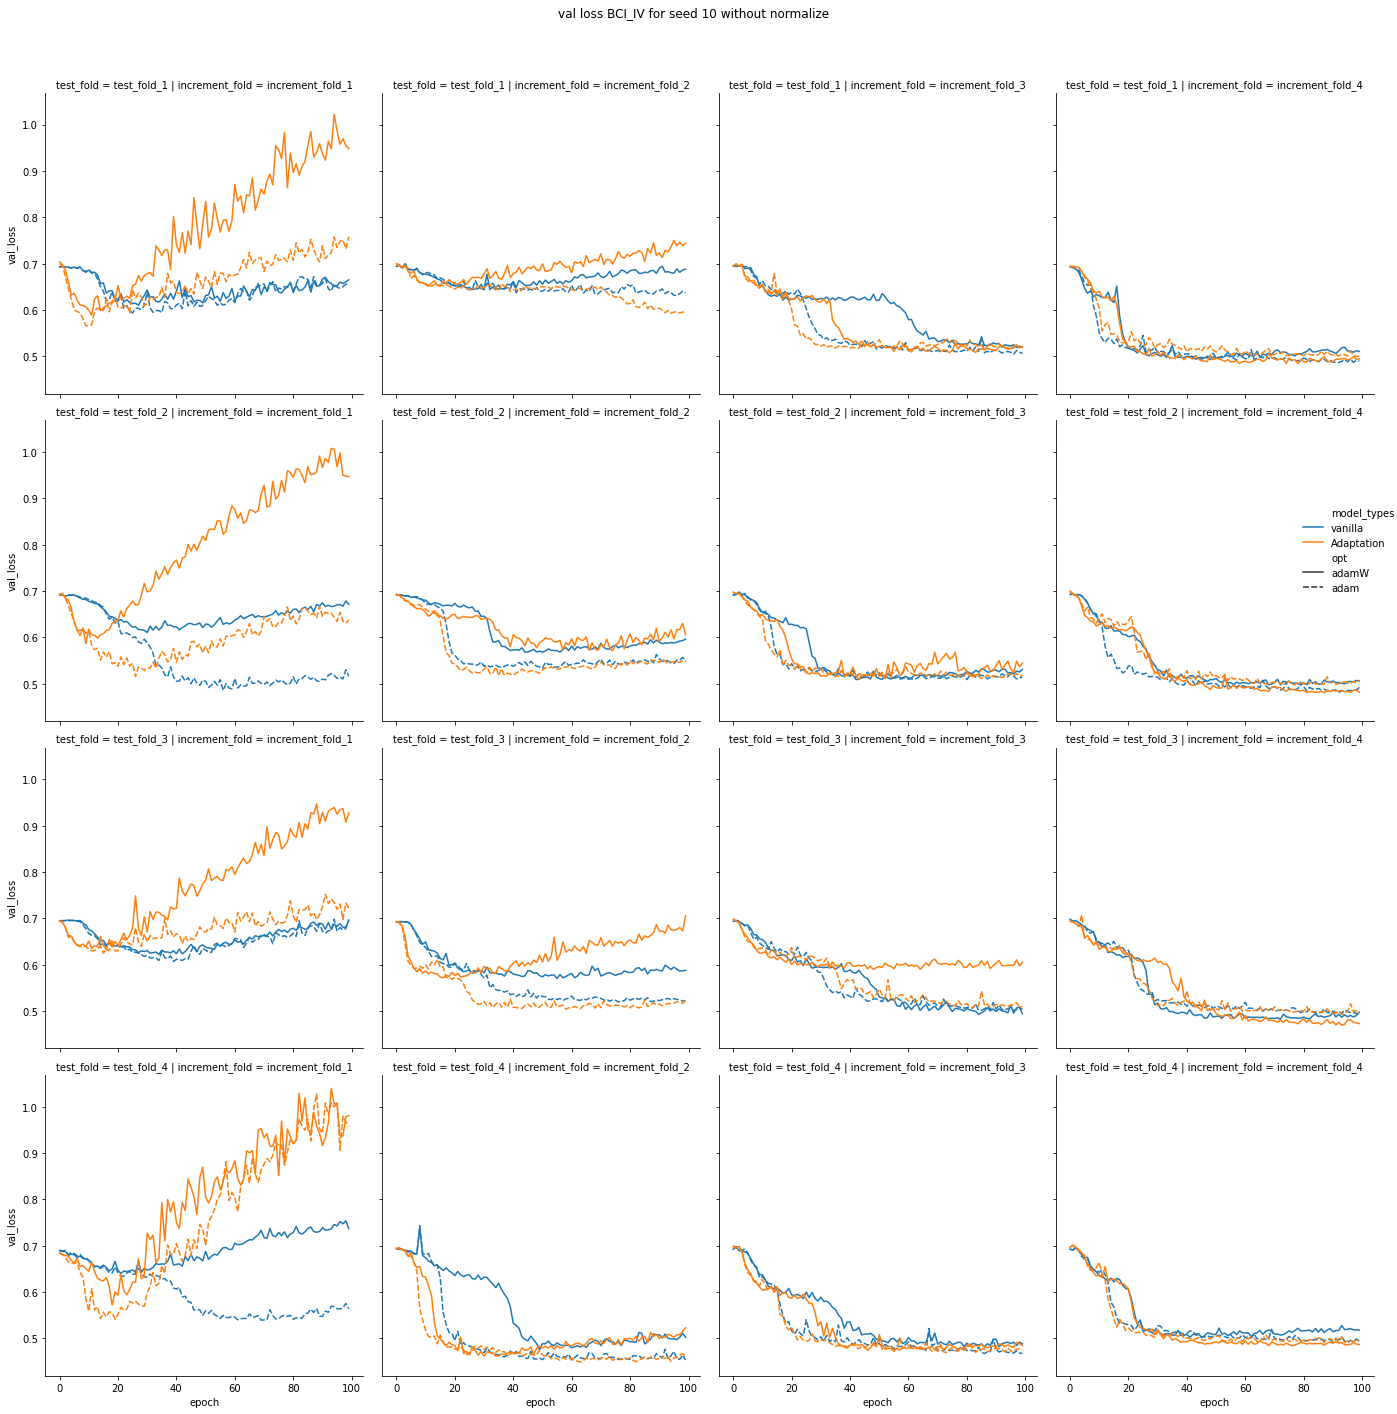

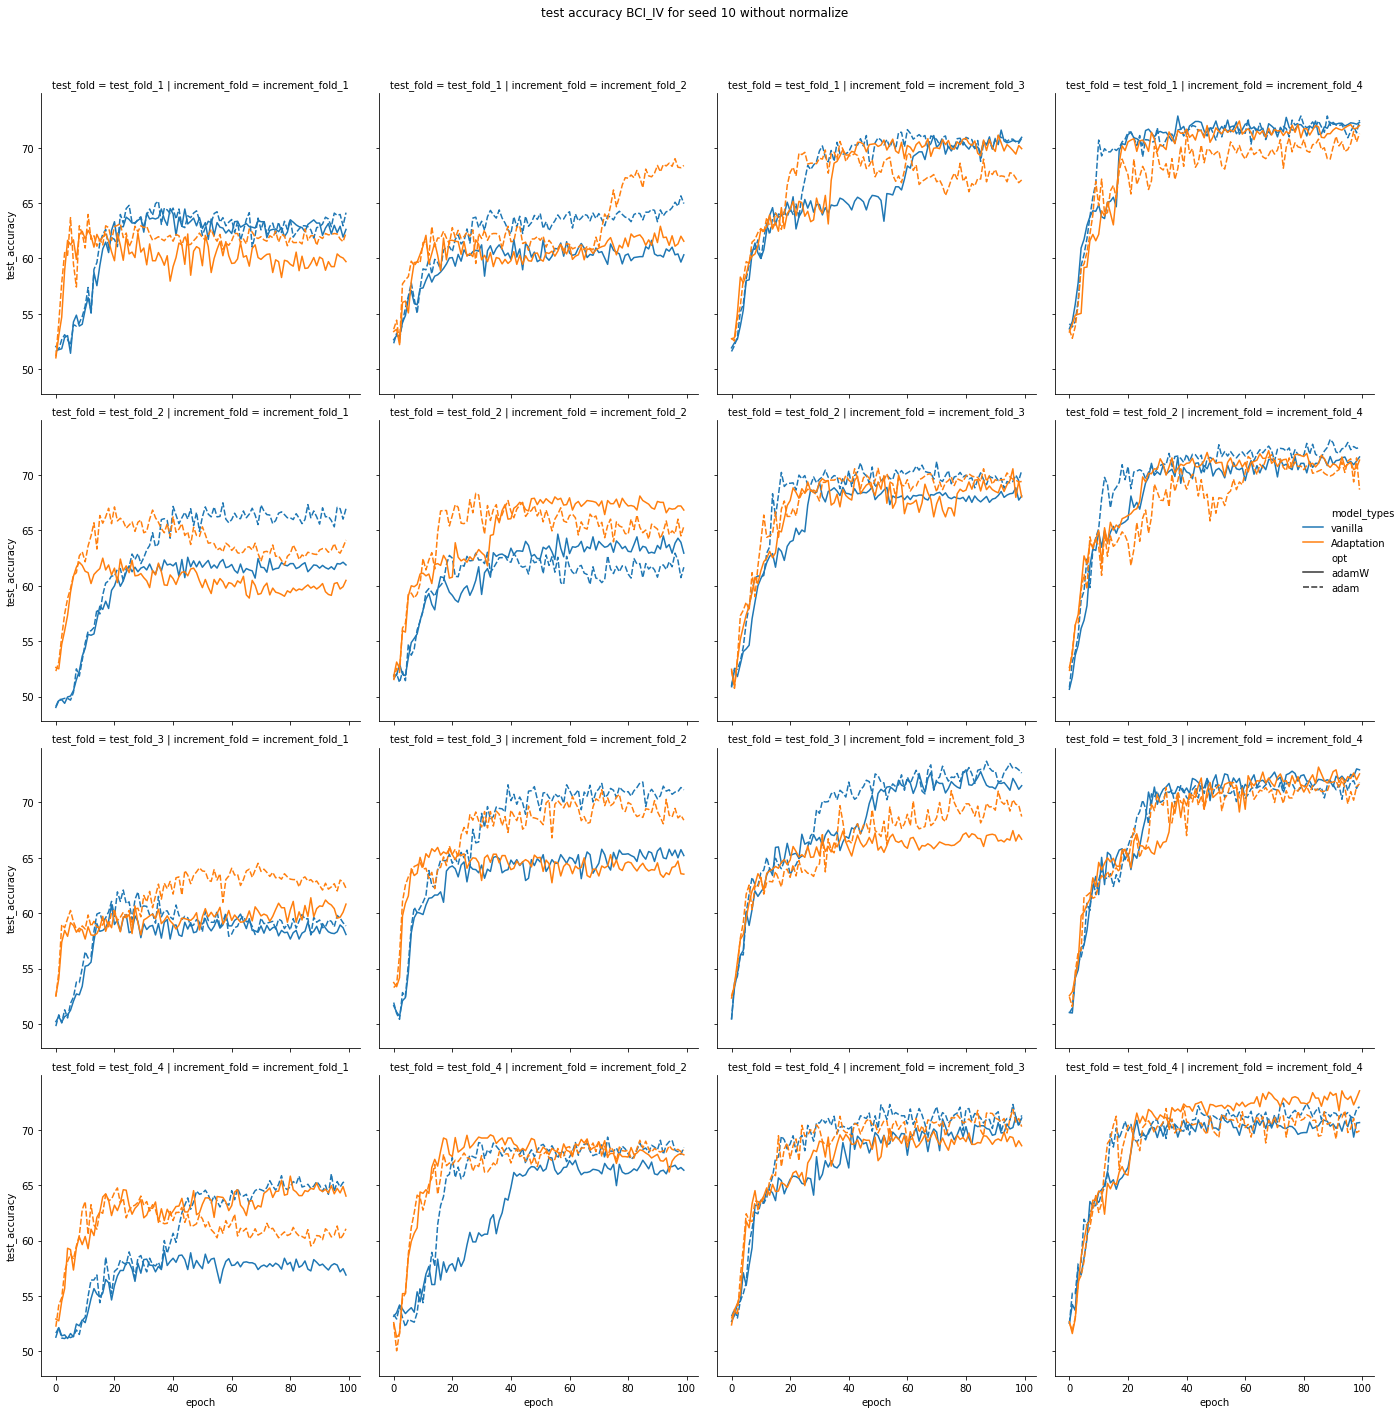

In [10]:
#compare adam vs adamW for vanilla model
#compare fix optimization to train for different increment fold vs hyper tune individual increment fold
common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation_adamW\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"

model_list = [
    'vanilla',
    'adaptation'
]
seed_list = [
    "seed_v0",
    "seed_v1",
    "seed_v2"
]
norm_list = [
    'norm_none',     
]
model_data_prefix = [
    "GIGA",
    "BCI_IV"
]
result_folder = 'results_v1'
file_name = 'model_result..xlsx'
info_file_name = 'model_info.json'
prefix_lists = [seed_list,model_list,norm_list,model_data_prefix]
list_full_path = generate_data_paths(common_path,prefix_lists,[])
data_1 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)
data_1['model_types'] = data_1.apply (lambda row: generate_model_types(row), axis=1)

summary_history_1 = summarize_history(data_1,pick_cols)
history_data_1 = load_history_data(data_1,pick_cols)

#compare fix optimization to train for different increment fold vs hyper tune individual increment fold
common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"

model_list = [
    'vanilla',
    'adaptation'
]
seed_list = [
    "seed_v0",
    "seed_v1",
    "seed_v2"
]
norm_list = [
    'norm_none',     
]
model_data_prefix = [
    "GIGA",
    "BCI_IV"
]
result_folder = 'results_v1'
file_name = 'model_result..xlsx'
info_file_name = 'model_info.json'
prefix_lists = [seed_list,model_list,norm_list,model_data_prefix]
list_full_path = generate_data_paths(common_path,prefix_lists,[])
data_2 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)
data_2['model_types'] = data_2.apply (lambda row: generate_model_types(row), axis=1)

summary_history_2 = summarize_history(data_2,pick_cols)
history_data_2 = load_history_data(data_2,pick_cols)

combine_data = {
    'adamW':data_1,
    'adam':data_2,
}

combine_summary_history = {
    'adamW':summary_history_1,
    'adam':summary_history_2,
}

combine_history_data = {
    'adamW':history_data_1,
    'adam':history_data_2,
}
field_name = "opt"
data = generate_concat_dataset(combine_data,field_name)
summary_history = generate_concat_dataset(combine_summary_history,field_name)
history_data = generate_concat_dataset(combine_history_data,field_name)


#view and compare training process result for 1 shuffle seed for 4 test fold. 
conditions = [
    ["seed",[0]],
    ["dataset",["GIGA"]],
#     ["opt",["adamW"]]
]

filter_history_data = filter_history_information(history_data,conditions)
d = sns.relplot(
    data=filter_history_data,x="epoch", y="val_loss", col="increment_fold",row="test_fold",
    hue="model_types",style="opt", kind="line", aspect = 0.9
)
leg = d._legend
leg.set_bbox_to_anchor([1,0.6])
d.add_legend()
d.fig.suptitle("val loss BCI_IV for seed 10 without normalize")
d.fig.subplots_adjust(top=0.92)

e = sns.relplot(
    data=filter_history_data,x="epoch", y="test_accuracy", col="increment_fold",row="test_fold",
    hue="model_types", style="opt",kind="line", aspect = 0.9
)
leg = e._legend
leg.set_bbox_to_anchor([1,0.6])
e.add_legend()
e.fig.suptitle("test accuracy BCI_IV for seed 10 without normalize")
e.fig.subplots_adjust(top=0.92)


avg_combine_data = data.groupby(["dataset","increment_fold","test_fold","opt","model_types"]).mean()
print(avg_combine_data)
table = pd.pivot_table(avg_combine_data, values=['accuracy'], index=['dataset','model_types','opt'],columns=['increment_fold'])
print(table)

In [6]:
#compare norm none, norm zscore, norm max fix
#compare adam vs adamW for vanilla model
#compare fix optimization to train for different increment fold vs hyper tune individual increment fold
common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"

model_list = [
    'vanilla',
    'adaptation'
]
seed_list = [
    "seed_v0",
    "seed_v1",
    "seed_v2"
]
norm_list = [
    'norm_none',
    'norm_zscore',
    'norm_max'
]
model_data_prefix = [
    "GIGA",
    "BCI_IV"
]
result_folder = 'results_v1'
file_name = 'model_result..xlsx'
info_file_name = 'model_info.json'
prefix_lists = [seed_list,model_list,norm_list,model_data_prefix]
list_full_path = generate_data_paths(common_path,prefix_lists,[])
data_1 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)
data_1['model_types'] = data_1.apply (lambda row: generate_model_types(row), axis=1)

summary_history_1 = summarize_history(data_1,pick_cols)
history_data_1 = load_history_data(data_1,pick_cols)


avg_combine_data = data_1.groupby(["dataset","increment_fold","model_types","normalize"]).mean()
print(avg_combine_data)
table = pd.pivot_table(avg_combine_data, values=['accuracy'], index=['dataset','model_types','normalize'],columns=['increment_fold'])
print(table)

                                                 accuracy  error_rate  \
dataset increment_fold   model_types normalize                          
BCI_IV  increment_fold_1 Adaptation  fix_scale  36.250965   63.749035   
                                     none       36.598187   63.401813   
                                     zscore     34.606481   65.393519   
                         vanilla     fix_scale  35.995370   64.004630   
                                     none       36.439043   63.560957   
                                     zscore     35.411844   64.588156   
        increment_fold_2 Adaptation  fix_scale  40.268133   59.731867   
                                     none       40.248843   59.751157   
                                     zscore     39.486883   60.513117   
                         vanilla     fix_scale  40.972222   59.027778   
                                     none       41.319444   58.680556   
                                     zscore     39.

In [8]:
#compare vanilla vs adapt for equal label. Transfer from GIGA to BCI with left and right hand 
common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation_v1\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"

model_list = [
    'vanilla_equal_label',
    'adapt_equal_label'
]
seed_list = [
    "seed_v0",
    "seed_v1",
    "seed_v2"
]
norm_list = [
    'norm_none',     
]
model_data_prefix = [
    "BCI_IV"
]
result_folder = 'results_v1'
file_name = 'model_result..xlsx'
info_file_name = 'model_info.json'
prefix_lists = [seed_list,model_list,norm_list,model_data_prefix]
list_full_path = generate_data_paths(common_path,prefix_lists,[])
data = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)
data['model_types'] = data.apply (lambda row: generate_model_types(row), axis=1)

summary_history = summarize_history(data,pick_cols)
history_data = load_history_data(data,pick_cols)




#view and compare training process result for 1 shuffle seed for 4 test fold. 
# conditions = [
#     ["seed",[0]],
#     ["dataset",["GIGA"]],
# #     ["opt",["adamW"]]
# ]

# filter_history_data = filter_history_information(history_data,conditions)
# d = sns.relplot(
#     data=filter_history_data,x="epoch", y="val_loss", col="increment_fold",row="test_fold",
#     hue="model_types",style="opt", kind="line", aspect = 0.9
# )
# leg = d._legend
# leg.set_bbox_to_anchor([1,0.6])
# d.add_legend()
# d.fig.suptitle("val loss BCI_IV for seed 10 without normalize")
# d.fig.subplots_adjust(top=0.92)

# e = sns.relplot(
#     data=filter_history_data,x="epoch", y="test_accuracy", col="increment_fold",row="test_fold",
#     hue="model_types", style="opt",kind="line", aspect = 0.9
# )
# leg = e._legend
# leg.set_bbox_to_anchor([1,0.6])
# e.add_legend()
# e.fig.suptitle("test accuracy BCI_IV for seed 10 without normalize")
# e.fig.subplots_adjust(top=0.92)


avg_combine_data = data.groupby(["dataset","increment_fold","test_fold","model_types","seed"]).mean()
print(avg_combine_data)
table = pd.pivot_table(avg_combine_data, values=['accuracy'], index=['seed','dataset','model_types'],columns=['increment_fold'])
print(table)
table = pd.pivot_table(avg_combine_data, values=['accuracy'], index=['dataset','model_types'],columns=['increment_fold'])
print(table)

                                                         accuracy  error_rate  \
dataset increment_fold   test_fold   model_types  seed                          
BCI_IV  increment_fold_1 test_fold_1 AdaptationV1 0     59.375000   40.625000   
                                                  5     62.615741   37.384259   
                                                  10    70.370370   29.629630   
                                     vanilla      0     57.638889   42.361111   
                                                  5     63.773148   36.226852   
...                                                           ...         ...   
        increment_fold_3 test_fold_4 AdaptationV1 5     60.416667   39.583333   
                                                  10    73.958333   26.041667   
                                     vanilla      0     66.203704   33.796296   
                                                  5     61.111111   38.888889   
                            

In [8]:
#compare previous radam optimization vs new adam optimization
common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"

model_list = [
    'vanilla',
#     'adaptation',
#     'adapt_equal_dann',
#     'adapt_equal_label',
#     'adapt_share_label'
]
seed_list = [
    "seed_v0",
    "seed_v1",
    "seed_v2"
]
norm_list = [
    'norm_none',
    'norm_zscore'
]
model_data_prefix = [
    "GIGA",
    "BCI_IV"
]
result_folder = 'results_v1'
file_name = 'model_result..xlsx'
info_file_name = 'model_info.json'
prefix_lists = [seed_list,model_list,norm_list,model_data_prefix]
list_full_path = generate_data_paths(common_path,prefix_lists,[])
data_1 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)
data_1['model_types'] = data_1.apply (lambda row: generate_model_types(row), axis=1)


common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation_use_adam\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"

model_list = [
    'vanilla',
#     'adaptation',
#     'adapt_equal_dann',
#     'adapt_equal_label',
#     'adapt_share_label'
]
seed_list = [
    "seed_v0",
    "seed_v1",
    "seed_v2"
]
norm_list = [
    'norm_none',
    'norm_zscore'
]
model_data_prefix = [
    "GIGA",
    "BCI_IV"
]
result_folder = 'results_v1'
file_name = 'model_result..xlsx'
info_file_name = 'model_info.json'
prefix_lists = [seed_list,model_list,norm_list,model_data_prefix]
list_full_path = generate_data_paths(common_path,prefix_lists,[])
data_2 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)
data_2['model_types'] = data_2.apply (lambda row: generate_model_types(row), axis=1)


combine_data = {
    'radam':data_1,
    'adam':data_2,
}
field_name = "opt"
data = generate_concat_dataset(combine_data,field_name)

# avg_combine_data = data.groupby(["seed","dataset","increment_fold","opt","model_types"]).mean()
# print(avg_combine_data)
# table = pd.pivot_table(avg_combine_data, values=['accuracy'], index=['dataset','model_types','opt'],columns=['increment_fold'])
# print(table)

avg_combine_data = data.groupby(["seed","dataset","increment_fold","opt","model_types","normalize"]).mean()
print(avg_combine_data)
table = pd.pivot_table(avg_combine_data, values=['accuracy'], index=['dataset','model_types','normalize','opt'],columns=['increment_fold'])
print(table)

                                                            accuracy  \
seed dataset increment_fold   opt   model_types normalize              
0    BCI_IV  increment_fold_1 adam  vanilla     none       38.208912   
                                                zscore     38.281250   
                              radam vanilla     none       36.371528   
                                                zscore     36.718750   
             increment_fold_2 adam  vanilla     none       42.317708   
...                                                              ...   
10   GIGA    increment_fold_3 radam vanilla     zscore     64.465726   
             increment_fold_4 adam  vanilla     none       74.637097   
                                                zscore     65.393145   
                              radam vanilla     none       73.820565   
                                                zscore     66.955645   

                                                           erro

In [42]:
#analyze history max  possible choice 
history_data_v0['increment_fold'] = history_data_v0['increment_fold'].replace(['increment_fold_1','increment_fold_2','increment_fold_3','increment_fold_4'],['1','2','3','4'])

table = pd.pivot_table(history_data_v0, values=['test_accuracy'], index=['dataset','model','normalize','model_choice'],columns=['increment_fold'])
print("seed_v0")
print(table)

NameError: name 'history_data_v0' is not defined

In [54]:
#compare adaptation from BCI_IV to GIGA dataset

#case 1: filter BCI_IV for only right hand and left hand movement data. Set same number of label spaces as GIGA
#Case 1a: Source model and target model has its own 2 conv layers. Share the third conv and classifier
model_list = [
    'adapt_share_label'
]


norm_list = [
    'norm_none',     
]

model_data_prefix = [
    "GIGA"
]
seed_list = [
    "seed_v0"
]
list_full_path = generate_data_paths(common_path,seed_list,model_list,norm_list,model_data_prefix)
GIGA_share_v0 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)
seed_list = [
    "seed_v1"
]
list_full_path = generate_data_paths(common_path,seed_list,model_list,norm_list,model_data_prefix)
GIGA_share_v1 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)
seed_list = [
    "seed_v2"
]
list_full_path = generate_data_paths(common_path,seed_list,model_list,norm_list,model_data_prefix)
GIGA_share_v2 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)
field_name = "random_shuffle_seed"

combine_data = {
    "0":GIGA_share_v0,
    "5":GIGA_share_v1,
    "10":GIGA_share_v2
}
combine_GIGA_share = generate_concat_dataset(combine_data,field_name)
avg_combine_data = combine_GIGA_share.groupby(["random_shuffle_seed","normalize","dataset","increment_fold","model"],as_index=False).mean()
table = pd.pivot_table(avg_combine_data, values=['accuracy'], index=["random_shuffle_seed",'dataset','model','normalize'],columns=['increment_fold'])
# print("combine")
# print(table)

pick_cols = ["random_shuffle_seed","alg","normalize","dataset","test_fold","increment_fold","valid_fold","model","history_path"]
history_combine_data = summarize_history(combine_GIGA_share,pick_cols)
history_combine_data['increment_fold'] = history_combine_data['increment_fold'].replace(['increment_fold_1','increment_fold_2','increment_fold_3','increment_fold_4'],['1','2','3','4'])

# print(history_combine_data[history_combine_data["random_shuffle_seed"] == "0"])
# avg_combine_data = history_combine_data.groupby(["random_shuffle_seed","dataset","increment_fold","model","normalize","model_choice","epoch"]).mean()
# print(avg_combine_data)

# table = pd.pivot_table(history_combine_data, values=['test_accuracy'], index=["random_shuffle_seed",'dataset','model','normalize','model_choice'],columns=['increment_fold'])
# print(table)

#case 1b: Source model and target model has its own 2 conv layers and its own classifier layer. Share the third conv 
model_list = [
    'adapt_equal_label'
]


norm_list = [
    'norm_none',     
]

model_data_prefix = [
    "GIGA"
]
seed_list = [
    "seed_v0"
]
list_full_path = generate_data_paths(common_path,seed_list,model_list,norm_list,model_data_prefix)
GIGA_equal_v0 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)
seed_list = [
    "seed_v1"
]
list_full_path = generate_data_paths(common_path,seed_list,model_list,norm_list,model_data_prefix)
GIGA_equal_v1 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)
seed_list = [
    "seed_v2"
]
list_full_path = generate_data_paths(common_path,seed_list,model_list,norm_list,model_data_prefix)
GIGA_equal_v2 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)
field_name = "random_shuffle_seed"

combine_data = {
    "0":GIGA_equal_v0,
    "5":GIGA_equal_v1,
    "10":GIGA_equal_v2
}
combine_GIGA_sequal = generate_concat_dataset(combine_data,field_name)
# avg_combine_data = combine_GIGA_sequal.groupby(["random_shuffle_seed","normalize","dataset","increment_fold","model"],as_index=False).mean()
# table = pd.pivot_table(avg_combine_data, values=['accuracy'], index=["random_shuffle_seed",'dataset','model','normalize'],columns=['increment_fold'])
# print("combine")
# print(table)

pick_cols = ["random_shuffle_seed","alg","normalize","dataset","test_fold","increment_fold","valid_fold","model","history_path"]
history_combine_data = summarize_history(combine_GIGA_sequal,pick_cols)
history_combine_data['increment_fold'] = history_combine_data['increment_fold'].replace(['increment_fold_1','increment_fold_2','increment_fold_3','increment_fold_4'],['1','2','3','4'])
print(history_combine_data[history_combine_data["random_shuffle_seed"] == "0"])



# table = pd.pivot_table(history_combine_data, values=['test_accuracy'], index=["random_shuffle_seed",'dataset','model','normalize','model_choice'],columns=['increment_fold'])
# print(table)
#case 2: Keep BCI_IV for right hand, left hand, tounge and feet (4 labels category). 

TypeError: generate_data_paths() takes 3 positional arguments but 5 were given

In [21]:
#load model with norm_max in classifier layer

common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation_1\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"


model_list = [
    'vanilla',
    'adaptation',

]

seed_list = [
    "seed_v0"
]

norm_list = [
    'norm_none',
    'norm_zscore'
     
]


model_data_prefix = [
    "BCI_IV",
    "GIGA"
]


result_folder = 'results_v1'
file_name = 'model_result..xlsx'
info_file_name = 'model_info.json'
# file_name_detail = 'model_detail_result.xlsx'
list_full_path = generate_data_paths(common_path,seed_list,model_list,norm_list,model_data_prefix)
# print("list of data path : ",list_full_path)
data_result_v0 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)
print(data_result_v0[:15])
seed_list = [
    "seed_v1"
]
list_full_path = generate_data_paths(common_path,seed_list,model_list,norm_list,model_data_prefix)
data_result_v1 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)
# generate_history_results_path(data_result_v1,list_full_path,1)

seed_list = [
    "seed_v2"
]
list_full_path = generate_data_paths(common_path,seed_list,model_list,norm_list,model_data_prefix)
data_result_v2 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)

# print(data_result)
pick_cols = ["alg","normalize","dataset","test_fold","increment_fold","valid_fold","model","history_path"]
history_data_v0 = summarize_history(data_result_v0,pick_cols)
history_data_1 = summarize_history(data_result_v1,pick_cols)

history_data_v2 = summarize_history(data_result_v2,pick_cols)

# data_result_v0['model'] = data_result_v0['model'].replace(['BaseModel','Adaptation','Adaptation_V1','Adaptation_DANN'],['vanilla','adaptation','adaptation_v1','dann'])
data_result_v0['increment_fold'] = data_result_v0['increment_fold'].replace(['increment_fold_1','increment_fold_2','increment_fold_3','increment_fold_4'],['1','2','3','4'])


avg_format_plot_report_v0 = data_result_v0.groupby(["alg","normalize","dataset","increment_fold","model"],as_index=False).mean()
# print(avg_format_plot_report_v0)
table = pd.pivot_table(avg_format_plot_report_v0, values=['accuracy'], index=['dataset','model','normalize'],columns=['increment_fold'])
print("seed_v0")
print(table)

# data_result_v0['increment_fold'] = data_result_v0['increment_fold'].replace(['increment_fold_1','increment_fold_2','increment_fold_3','increment_fold_4'],['1','2','3','4'])




data_result_v1['increment_fold'] = data_result_v1['increment_fold'].replace(['increment_fold_1','increment_fold_2','increment_fold_3','increment_fold_4'],['1','2','3','4'])


avg_format_plot_report_v1 = data_result_v1.groupby(["alg","normalize","dataset","increment_fold","model"],as_index=False).mean()
# print(avg_format_plot_report_v0)
table = pd.pivot_table(avg_format_plot_report_v1, values=['accuracy'], index=['dataset','model','normalize'],columns=['increment_fold'])
print("seed_v1")
print(table)

data_result_v2['increment_fold'] = data_result_v2['increment_fold'].replace(['increment_fold_1','increment_fold_2','increment_fold_3','increment_fold_4'],['1','2','3','4'])


avg_format_plot_report_v2 = data_result_v2.groupby(["alg","normalize","dataset","increment_fold","model"],as_index=False).mean()
# print(avg_format_plot_report_v0)
table = pd.pivot_table(avg_format_plot_report_v2, values=['accuracy'], index=['dataset','model','normalize'],columns=['increment_fold'])
print("seed_v2")
print(table)



#combine seed datasets
field_name = "random_shuffle_seed"

raw_data = {
    "0":data_result_v0,
    "5":data_result_v1,
    "10":data_result_v2
}
combine_data_result_2=generate_concat_dataset(raw_data,field_name)
avg_combine_data = combine_data_result_2.groupby(["alg","normalize","dataset","increment_fold","model"],as_index=False).mean()
table = pd.pivot_table(avg_combine_data, values=['accuracy'], index=['dataset','model','normalize'],columns=['increment_fold'])
print("combine")
print(table)


     accuracy  error_rate  class_0_acc  class_1_acc  class_2_acc  class_3_acc  \
0   33.333333   66.666667    27.546296    20.833333    10.879630    74.074074   
1   42.534722   57.465278    36.342593    42.129630    40.740741    50.925926   
2   41.840278   58.159722    33.101852    48.611111    47.222222    38.425926   
3   33.796296   66.203704    72.916667    10.879630    26.157407    25.231481   
4   41.435185   58.564815    30.324074    40.972222    41.898148    52.546296   
5   45.081019   54.918981    32.175926    59.490741    31.481481    57.175926   
6   42.013889   57.986111    26.388889    62.962963    39.120370    39.583333   
7   45.775463   54.224537    32.407407    58.101852    40.509259    52.083333   
8   41.145833   58.854167    31.250000    45.833333    54.629630    32.870370   
9   32.233796   67.766204    16.203704    24.537037    25.462963    62.731481   
10  36.631944   63.368056    24.537037    42.824074    47.685185    31.481481   
11  43.692130   56.307870   

In [22]:
field_name = "FC_norm"

raw_data = {
    "False":combine_data_result_1,
    "True":combine_data_result_2}

combine_data=generate_concat_dataset(raw_data,field_name)
avg_combine_data = combine_data.groupby(["FC_norm","alg","normalize","dataset","increment_fold","model"],as_index=False).mean()
table = pd.pivot_table(avg_combine_data, values=['accuracy'], index=['dataset','model','normalize','FC_norm'],columns=['increment_fold'])
print("combine")
print(table)

combine
                                                         accuracy             \
increment_fold                                                  1          2   
dataset model                        normalize FC_norm                         
BCI_IV  BaseModel                    none      False    34.630594  41.594329   
                                               True     34.336420  41.020448   
                                     zscore    False    34.148341  39.988426   
                                               True     34.254437  38.903356   
        HeterogeneousModelAdaptation none      False    36.656057  39.052855   
                                               True     36.680170  39.535108   
                                     zscore    False    34.606481  39.486883   
                                               True     34.095293  38.903356   
GIGA    BaseModel                    none      False    59.563337  63.926604   
                                

this path does not exist :  C:\wduong_folder\Dassl.pytorch-master\Dassl.pytorch-master\adaptation_experiment_1\vanilla\norm_none_v1\ABM_TRANSFER_ADAPTATION\within_subject\transfer_adaptation
this path does not exist :  C:\wduong_folder\Dassl.pytorch-master\Dassl.pytorch-master\adaptation_experiment_1\vanilla\norm_none_v1\ABM_TRANSFER_ADAPTATION_vanilla\within_subject\transfer_adaptation
this path does not exist :  C:\wduong_folder\Dassl.pytorch-master\Dassl.pytorch-master\adaptation_experiment_1\vanilla\norm_none_v1\ABM_TRANSFER_ADAPTATION_vanilla\within_subject\transfer_adaptation_vanilla
this path does not exist :  C:\wduong_folder\Dassl.pytorch-master\Dassl.pytorch-master\adaptation_experiment_1\vanilla\norm_none_v1\ABM_TRANSFER_ADAPTATION_DANN\within_subject\transfer_adaptation
this path does not exist :  C:\wduong_folder\Dassl.pytorch-master\Dassl.pytorch-master\adaptation_experiment_1\vanilla\norm_none_v1\ABM_TRANSFER_ADAPTATION_DANN\within_subject\transfer_adaptation_vanilla
thi

NameError: name 'data_result' is not defined

In [49]:
data_result_v10['model'] = data_result_v10['model'].replace(['BaseModel','Adaptation','Adaptation_V1','Adaptation_DANN'],['vanilla','adaptation','adaptation_v1','dann'])
data_result_v10['increment_fold'] = data_result_v10['increment_fold'].replace(['increment_fold_1','increment_fold_2','increment_fold_3','increment_fold_4'],['1','2','3','4'])

avg_format_plot_report_v10 = data_result_v10.groupby(["alg","normalize","dataset","increment_fold","model"],as_index=False).mean()
print(avg_format_plot_report_v10)


# format_report = avg_format_plot_report[avg_format_plot_report['alg'] == 'none']


# table = pd.pivot_table(format_report, values=['auc'], index=['dataset','model','normalize'],columns=['increment_fold'])
# print(table)


# for group_name, group in table:
#     print(group_name)
#     print(group)

      alg normalize dataset increment_fold          model   accuracy  \
0      EA    zscore     ABM              1     adaptation  75.629630   
1      EA    zscore     ABM              1  adaptation_v1  74.617284   
2      EA    zscore     ABM              1           dann  73.259259   
3      EA    zscore     ABM              1        vanilla  71.395062   
4      EA    zscore     ABM              2     adaptation  81.148148   
..    ...       ...     ...            ...            ...        ...   
139  none    zscore  Emotiv              3        vanilla  70.049383   
140  none    zscore  Emotiv              4     adaptation  73.753086   
141  none    zscore  Emotiv              4  adaptation_v1  74.049383   
142  none    zscore  Emotiv              4           dann  75.086420   
143  none    zscore  Emotiv              4        vanilla  73.407407   

     error_rate       auc  class_0_acc  class_1_acc  
0     24.370370  0.701843    79.494778    48.619329  
1     25.382716  0.709099  

In [41]:
#compare EA and non-EA
# format_report = avg_format_plot_report[avg_format_plot_report['normalize'] == 'zscore']

# table = pd.pivot_table(format_report,index=['dataset','model','alg'], columns=['increment_fold'],values='auc')
# print(table)

In [62]:
save_path = 'cross_device_multi_dataset_adaptation\\adaptation_experiment_report\\data_folder'
save_fig_path = 'cross_device_multi_dataset_adaptation\\adaptation_experiment_report\\graph'

combine = {
    "10":avg_format_plot_report_v10,
    "0":avg_format_plot_report_v0
}
field_name = "random_shuffle_seed"
avg_format_plot_report_combine = generate_concat_dataset(combine,field_name)
print(avg_format_plot_report_combine)

raw_data = {
    "10":data_result_v10,
    "0":data_result_v0
}
raw_data = generate_concat_dataset(raw_data,field_name)
raw_data_path = os.path.join(save_path,"raw_result.csv")
raw_data.to_csv(raw_data_path,index=False)

      alg normalize dataset increment_fold          model   accuracy  \
0      EA    zscore     ABM              1     adaptation  75.629630   
1      EA    zscore     ABM              1  adaptation_v1  74.617284   
2      EA    zscore     ABM              1           dann  73.259259   
3      EA    zscore     ABM              1        vanilla  71.395062   
4      EA    zscore     ABM              2     adaptation  81.148148   
..    ...       ...     ...            ...            ...        ...   
283  none    zscore  Emotiv              3        vanilla  78.111111   
284  none    zscore  Emotiv              4     adaptation  77.345679   
285  none    zscore  Emotiv              4  adaptation_v1  79.654321   
286  none    zscore  Emotiv              4           dann  79.296296   
287  none    zscore  Emotiv              4        vanilla  78.790123   

     error_rate       auc  class_0_acc  class_1_acc random_shuffle_seed  
0     24.370370  0.701843    79.494778    48.619329          

    random_shuffle_seed normalize dataset increment_fold          model  \
0                     0      none     ABM              1     adaptation   
1                     0      none     ABM              1  adaptation_v1   
2                     0      none     ABM              1           dann   
3                     0      none     ABM              1        vanilla   
4                     0      none     ABM              2     adaptation   
..                  ...       ...     ...            ...            ...   
187                  10    zscore  Emotiv              3        vanilla   
188                  10    zscore  Emotiv              4     adaptation   
189                  10    zscore  Emotiv              4  adaptation_v1   
190                  10    zscore  Emotiv              4           dann   
191                  10    zscore  Emotiv              4        vanilla   

      accuracy  error_rate       auc  class_0_acc  class_1_acc  
0    73.313116   26.686884  0.6815

                                                          auc            \
increment_fold                                              1         2   
random_shuffle_seed dataset model         normalize                       
0                   ABM     adaptation    none       0.681519  0.700676   
                                          zscore     0.707739  0.720093   
                            adaptation_v1 none       0.665468  0.689953   
                                          zscore     0.703323  0.709979   
                            dann          none       0.678940  0.693264   
                                          zscore     0.714544  0.715490   
                            vanilla       none       0.646599  0.698768   
                                          zscore     0.679674  0.704685   
                    Biosemi adaptation    none       0.788078  0.848435   
                                          zscore     0.799647  0.862219   
                         

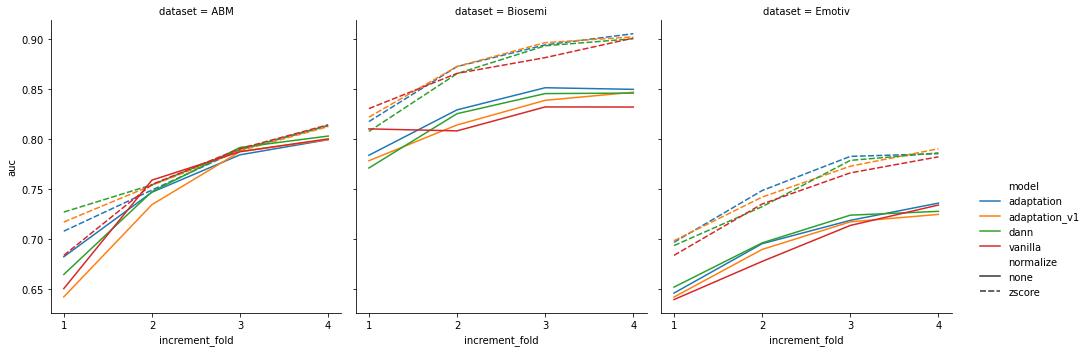

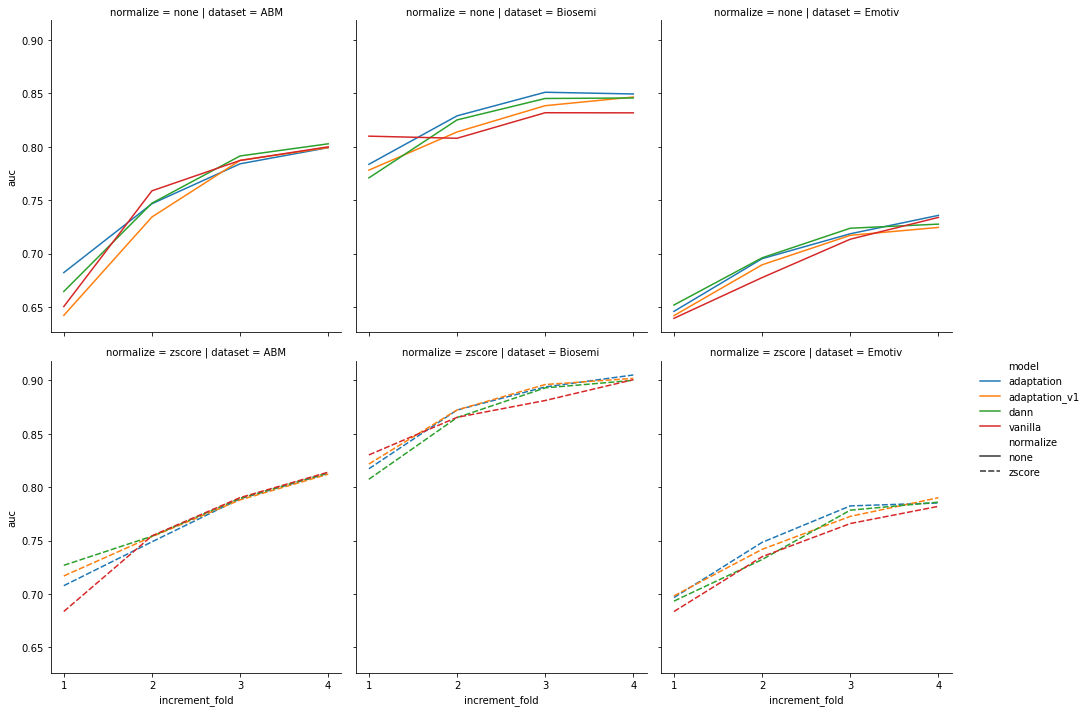

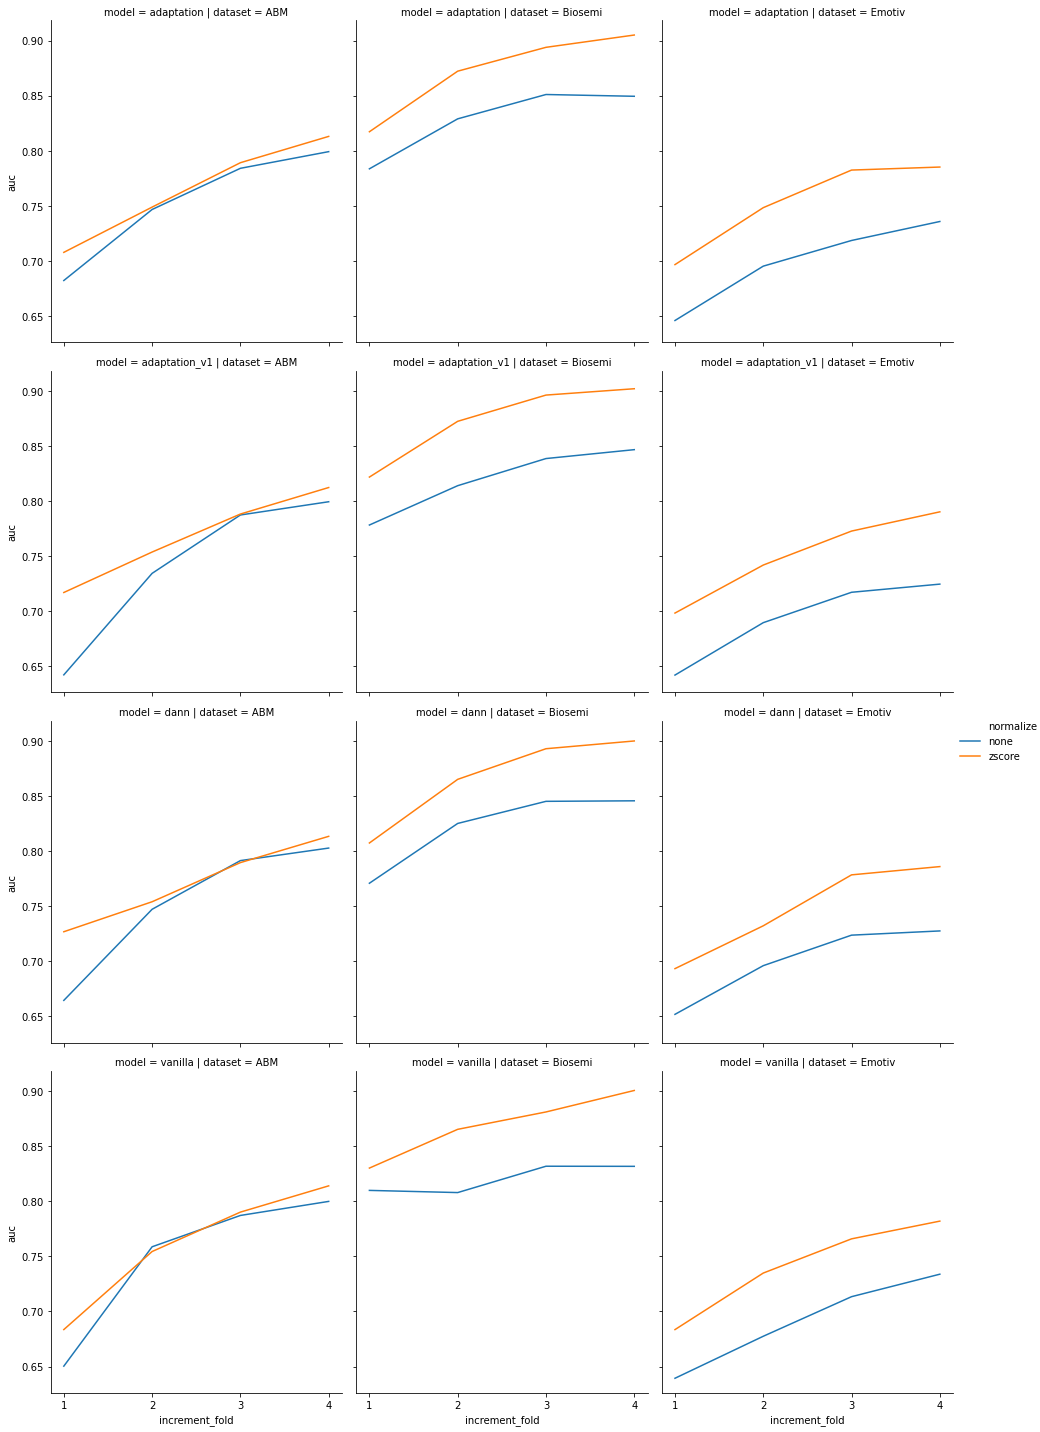

In [66]:
#average dataset for 2 random shuffle 

data = avg_format_plot_report_combine[avg_format_plot_report_combine['alg'] == 'none']
avg_data  = data.groupby(["random_shuffle_seed","normalize","dataset","increment_fold","model"],as_index=False).mean()
print(avg_data)
table = pd.pivot_table(avg_data,index=["random_shuffle_seed",'dataset','model','normalize'], columns=['increment_fold'],values=['auc'])
print(table)
file_name = 'combine_auc_shuffle_test_set.xlsx'
table.round(3).to_excel(os.path.join(save_path,file_name))
print(table)

data_case_1  = data.groupby(["normalize","dataset","increment_fold","model"],as_index=False).mean()


table = pd.pivot_table(avg_data,index=['dataset','model','normalize'], columns=['increment_fold'],values=['auc'])
file_name = 'combine_avg_auc.xlsx'
table.round(3).to_excel(os.path.join(save_path,file_name))
print(table)

#observe the trend of all 4 model and 2 normalize 
a = sns.relplot(
    data=data_case_1, x="increment_fold", y="auc", col="dataset",
    hue="model",style="normalize", kind="line", aspect = 0.9
)
# a.add_legend()

# a.fig.suptitle("My Title")

leg = a._legend
leg.set_bbox_to_anchor([0.9, 0.5])  # coordinates of lower left of bounding box
leg._loc = 2

file_name = 'compare_models_norm_1.png'
a.savefig(os.path.join(save_fig_path,file_name))


b = sns.relplot(
    data=data_case_1, x="increment_fold", y="auc", col="dataset",
    hue="model",row="normalize",style="normalize", kind="line", aspect = 0.9
)
# b.add_legend()

leg = b._legend
leg.set_bbox_to_anchor([0.9, 0.5])  # coordinates of lower left of bounding box
leg._loc = 2

file_name = 'compare_models_norm_2.png'
b.savefig(os.path.join(save_fig_path,file_name))



#compare none vs zscore on none alignment data
c = sns.relplot(
    data=data_case_1, x="increment_fold", y="auc", col="dataset",row="model",
    hue="normalize", kind="line", aspect = 0.9
)

leg = c._legend
leg.set_bbox_to_anchor([0.9, 0.5])  # coordinates of lower left of bounding box
leg._loc = 2

file_name = 'compare_models_norm_3.png'
c.savefig(os.path.join(save_fig_path,file_name))



                                                          auc            \
increment_fold                                              1         2   
random_shuffle_seed dataset model         normalize                       
0                   ABM     adaptation    none       0.681519  0.700676   
                                          zscore     0.707739  0.720093   
                            adaptation_v1 none       0.665468  0.689953   
                                          zscore     0.703323  0.709979   
                            dann          none       0.678940  0.693264   
                                          zscore     0.714544  0.715490   
                            vanilla       none       0.646599  0.698768   
                                          zscore     0.679674  0.704685   
                    Biosemi adaptation    none       0.788078  0.848435   
                                          zscore     0.799647  0.862219   
                         

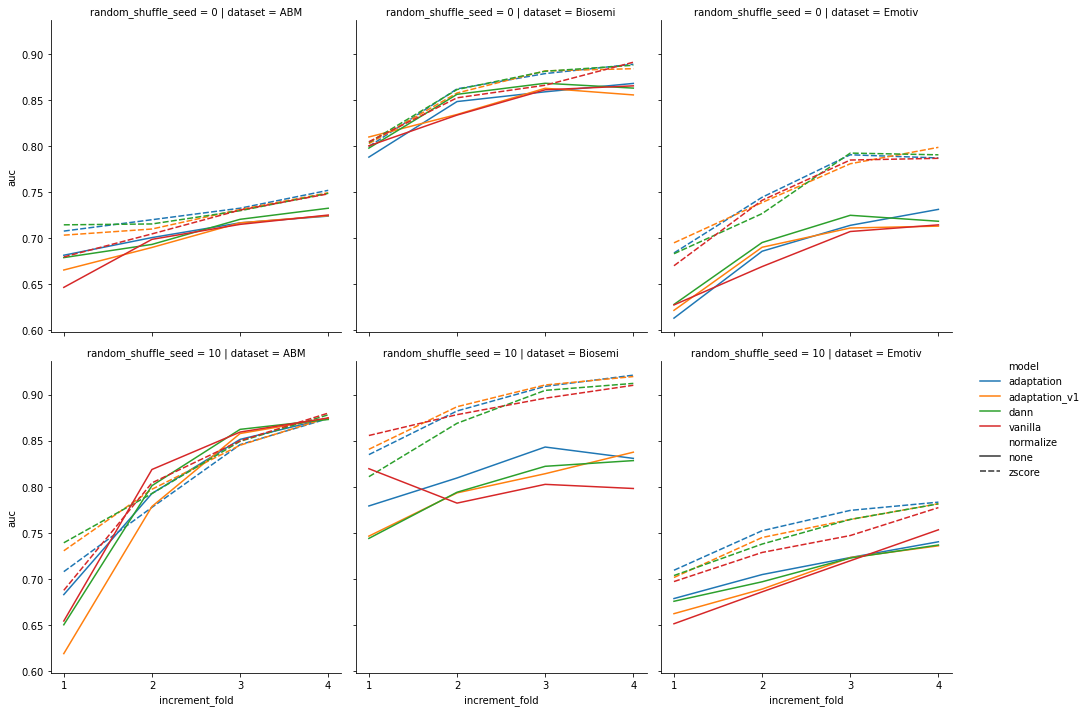

In [64]:
#average dataset for 2 random shuffle 

save_path = 'cross_device_multi_dataset_adaptation\\adaptation_experiment_report\\data_folder'


data_case_2  = data.groupby(["random_shuffle_seed","normalize","dataset","increment_fold","model"],as_index=False).mean()


table = pd.pivot_table(data_case_2,index=['random_shuffle_seed','dataset','model','normalize'], columns=['increment_fold'],values=['auc'])
# file_name = 'combine_avg_auc.xlsx'
# table.round(3).to_excel(os.path.join(save_path,file_name))
print(table)

#observe the trend of all 4 model and 2 normalize 
d = sns.relplot(
    data=data_case_2, x="increment_fold", y="auc", col="dataset",row="random_shuffle_seed",
    hue="model",style="normalize", kind="line", aspect = 0.9
)


leg = d._legend
leg.set_bbox_to_anchor([0.9, 0.5])  # coordinates of lower left of bounding box
leg._loc = 2
file_name = 'compare_models_norm_4.png'
d.savefig(os.path.join(save_fig_path,file_name))



# b = sns.relplot(
#     data=data_case_1, x="increment_fold", y="auc", col="dataset",
#     hue="model",row="normalize",style="normalize", kind="line", aspect = 0.9
# )
# b.add_legend()


#compare none vs zscore on none alignment data
# c = sns.relplot(
#     data=data_case_1, x="increment_fold", y="auc", col="dataset",row="model",
#     hue="normalize", kind="line", aspect = 0.9
# )
# c.add_legend()




      alg normalize dataset increment_fold          model   accuracy  \
0      EA    zscore     ABM              1     adaptation  75.629630   
1      EA    zscore     ABM              1  adaptation_v1  74.617284   
2      EA    zscore     ABM              1           dann  73.259259   
3      EA    zscore     ABM              1        vanilla  71.395062   
4      EA    zscore     ABM              2     adaptation  81.148148   
..    ...       ...     ...            ...            ...        ...   
283  none    zscore  Emotiv              3        vanilla  78.111111   
284  none    zscore  Emotiv              4     adaptation  77.345679   
285  none    zscore  Emotiv              4  adaptation_v1  79.654321   
286  none    zscore  Emotiv              4           dann  79.296296   
287  none    zscore  Emotiv              4        vanilla  78.790123   

     error_rate       auc  class_0_acc  class_1_acc random_shuffle_seed  
0     24.370370  0.701843    79.494778    48.619329          

                                                          auc            \
increment_fold                                              1         2   
random_shuffle_seed dataset model         normalize                       
0                   ABM     adaptation    zscore     0.706372  0.722473   
                            adaptation_v1 zscore     0.703258  0.717296   
                            dann          zscore     0.711006  0.722752   
                            vanilla       zscore     0.688774  0.713446   
                    Biosemi adaptation    zscore     0.794289  0.853123   
                            adaptation_v1 zscore     0.791045  0.851222   
                            dann          zscore     0.796750  0.854150   
                            vanilla       zscore     0.795850  0.848421   
                    Emotiv  adaptation    zscore     0.664983  0.743316   
                            adaptation_v1 zscore     0.683952  0.744325   
                         

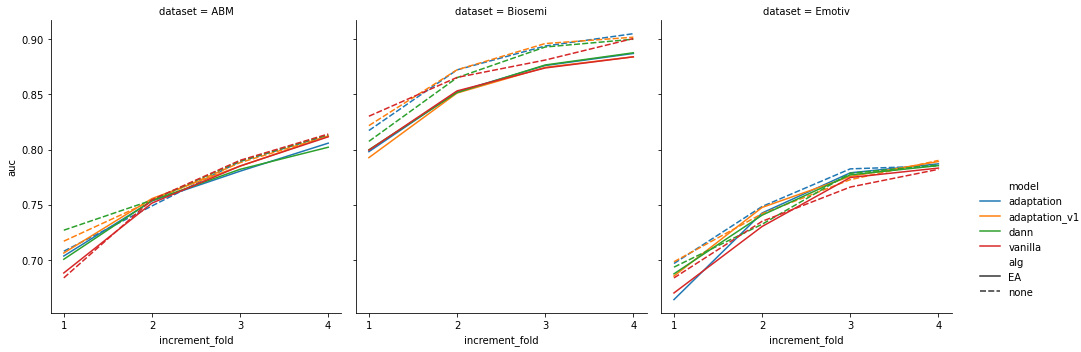

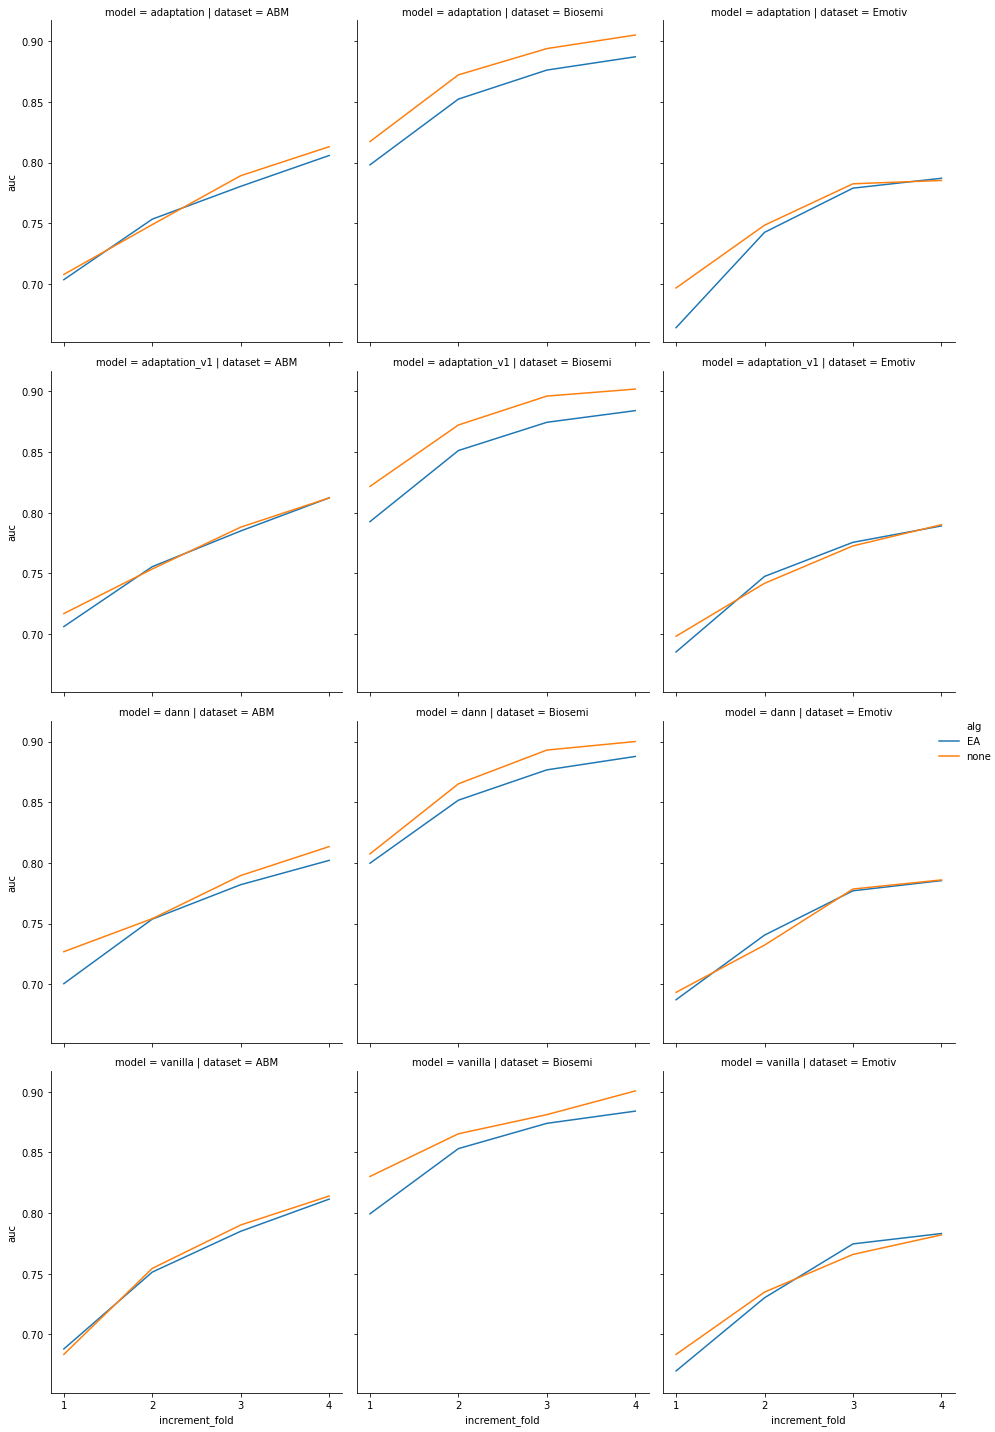

In [70]:
#compare EA and non EA for zscore norm

data_1 = avg_format_plot_report_combine[avg_format_plot_report_combine['normalize'] == 'zscore']
print(data_1)                            
data_case_2  = data_1.groupby(["alg","dataset","increment_fold","model"],as_index=False).mean()
print(data_case_2)
table = pd.pivot_table(data_case_2,index=['dataset','model','alg'], columns=['increment_fold'],values=['auc'])
print(table)
file_name = 'combine_avg_auc_compare_alg.xlsx'
table.round(3).to_excel(os.path.join(save_path,file_name))
print(table)

table = pd.pivot_table(data_1,index=["random_shuffle_seed",'dataset','model','normalize'], columns=['increment_fold'],values=['auc'])
print(table)
file_name = 'combine_auc_compare_alg_shuffle_test_set.xlsx'
table.round(3).to_excel(os.path.join(save_path,file_name))
print(table)

#observe the trend of all 4 model and 2 normalize 
a = sns.relplot(
    data=data_case_2, x="increment_fold", y="auc", col="dataset",
    hue="model",style="alg", kind="line", aspect = 0.9
)

leg = a._legend
leg.set_bbox_to_anchor([0.9, 0.5])  # coordinates of lower left of bounding box
leg._loc = 2


file_name = 'compare_models_alg_1.png'
a.savefig(os.path.join(save_fig_path,file_name))
# b = sns.relplot(
#     data=data_case_2, x="increment_fold", y="auc", col="dataset",
#     hue="model",row="alg",style="alg", kind="line", aspect = 0.9
# )
# b.add_legend()


#compare none vs zscore on none alignment data
c = sns.relplot(
    data=data_case_2, x="increment_fold", y="auc", col="dataset",row="model",
    hue="alg", kind="line", aspect = 0.9
)

leg = c._legend
leg.set_bbox_to_anchor([0.9, 0.5])  # coordinates of lower left of bounding box
leg._loc = 2
file_name = 'compare_models_alg_2.png'
c.savefig(os.path.join(save_fig_path,file_name))

In [37]:

common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation_temp\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"

model_list = [
    'adapt_equal_label',
]

seed_list = [
    "seed_v0"
]

norm_list = [
    'norm_none',
]


model_data_prefix = [
    "GIGA"
]


result_folder = 'results_v1'
file_name = 'model_result..xlsx'
info_file_name = 'model_info.json'
prefix_lists = [seed_list,model_list,norm_list,model_data_prefix]
list_full_path = generate_data_paths(common_path,prefix_lists,[])
data_result_v0 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)
print(data_result_v0[:15])
seed_list = [
    "seed_v1"
]
prefix_lists = [seed_list,model_list,norm_list,model_data_prefix]
list_full_path = generate_data_paths(common_path,prefix_lists,[])
data_result_v1 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)

seed_list = [
    "seed_v2"
]
prefix_lists = [seed_list,model_list,norm_list,model_data_prefix]
list_full_path = generate_data_paths(common_path,prefix_lists,[])
data_result_v2 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)






#combine seed datasets
field_name = "random_shuffle_seed"

raw_data = {
    "0":data_result_v0,
    "5":data_result_v1,
    "10":data_result_v2
}
combine_data_result_1 = generate_concat_dataset(raw_data,field_name)
combine_data_result_1['increment_fold'] = combine_data_result_1['increment_fold'].replace(['increment_fold_1','increment_fold_2','increment_fold_3','increment_fold_4'],['1','2','3','4'])

# avg_combine_data = combine_data_result_1.groupby(["random_shuffle_seed","alg","normalize","dataset","increment_fold","model"],as_index=False).mean()
# table = pd.pivot_table(avg_combine_data, values=['accuracy'], index=['random_shuffle_seed','dataset','model','normalize'],columns=['increment_fold'])
# print("combine")
# print(table)

     accuracy  error_rate       auc  class_0_acc  class_1_acc    test_fold  \
0   62.090164   37.909836  0.669172    74.754098    49.426230  test_fold_1   
1   61.967213   38.032787  0.680501    59.180328    64.754098  test_fold_1   
2   63.319672   36.680328  0.695859    56.639344    70.000000  test_fold_1   
3   66.557377   33.442623  0.754453    81.311475    51.803279  test_fold_1   
4   59.959016   40.040984  0.638230    75.983607    43.934426  test_fold_2   
5   68.319672   31.680328  0.755335    73.524590    63.114754  test_fold_2   
6   65.245902   34.754098  0.721592    68.442623    62.049180  test_fold_2   
7   70.655738   29.344262  0.792603    73.278689    68.032787  test_fold_2   
8   60.000000   40.000000  0.643752    46.393443    73.606557  test_fold_3   
9   64.508197   35.491803  0.698804    68.114754    60.901639  test_fold_3   
10  67.131148   32.868852  0.724036    72.049180    62.213115  test_fold_3   
11  69.385246   30.614754  0.785208    76.885246    61.885246  t

In [38]:

common_path = "C:\\wduong_folder\\Dassl.pytorch-master\\Dassl.pytorch-master\\heterogeneous_adaptation\\{}\\{}\\{}\\{}_adaptation\\transfer_adaptation"

model_list = [
    'adapt_equal_label',
]

seed_list = [
    "seed_v0"
]

norm_list = [
    'norm_none',
]


model_data_prefix = [
    "GIGA"
]


result_folder = 'results_v1'
file_name = 'model_result..xlsx'
info_file_name = 'model_info.json'
prefix_lists = [seed_list,model_list,norm_list,model_data_prefix]
list_full_path = generate_data_paths(common_path,prefix_lists,[])
data_result_v0 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)
print(data_result_v0[:15])
seed_list = [
    "seed_v1"
]
prefix_lists = [seed_list,model_list,norm_list,model_data_prefix]
list_full_path = generate_data_paths(common_path,prefix_lists,[])
data_result_v1 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)

seed_list = [
    "seed_v2"
]
prefix_lists = [seed_list,model_list,norm_list,model_data_prefix]
list_full_path = generate_data_paths(common_path,prefix_lists,[])
data_result_v2 = load_data(list_full_path,result_folder,file_name,info_file_name,load_history=True)






#combine seed datasets
field_name = "random_shuffle_seed"

raw_data = {
    "0":data_result_v0,
    "5":data_result_v1,
    "10":data_result_v2
}
combine_data_result_2 = generate_concat_dataset(raw_data,field_name)
combine_data_result_2['increment_fold'] = combine_data_result_2['increment_fold'].replace(['increment_fold_1','increment_fold_2','increment_fold_3','increment_fold_4'],['1','2','3','4'])

# avg_combine_data = combine_data_result_2.groupby(["random_shuffle_seed","alg","normalize","dataset","increment_fold","model"],as_index=False).mean()
# table = pd.pivot_table(avg_combine_data, values=['accuracy'], index=['random_shuffle_seed','dataset','model','normalize'],columns=['increment_fold'])
# print("combine")
# print(table)

     accuracy  error_rate  class_0_acc  class_1_acc    test_fold  \
0   61.065574   38.934426    73.524590    48.606557  test_fold_1   
1   60.737705   39.262295    70.655738    50.819672  test_fold_1   
2   71.475410   28.524590    76.967213    65.983607  test_fold_1   
3   70.532787   29.467213    73.606557    67.459016  test_fold_1   
4   63.647541   36.352459    59.344262    67.950820  test_fold_2   
5   68.319672   31.680328    76.229508    60.409836  test_fold_2   
6   69.549180   30.450820    68.770492    70.327869  test_fold_2   
7   69.262295   30.737705    54.508197    84.016393  test_fold_2   
8   59.754098   40.245902    46.803279    72.704918  test_fold_3   
9   66.762295   33.237705    64.754098    68.770492  test_fold_3   
10  71.188525   28.811475    78.032787    64.344262  test_fold_3   
11  71.721311   28.278689    75.655738    67.786885  test_fold_3   
12  58.032787   41.967213    66.229508    49.836066  test_fold_4   
13  69.303279   30.696721    62.377049    76.229

In [39]:
field_name = "source_bs"

raw_data = {
    "64":combine_data_result_1,
    "32":combine_data_result_2
}
combine_data = generate_concat_dataset(raw_data,field_name)

avg_combine_data = combine_data.groupby(["random_shuffle_seed","dataset","increment_fold","model","source_bs"],as_index=False).mean()
table = pd.pivot_table(avg_combine_data, values=['accuracy'], index=['random_shuffle_seed','source_bs'],columns=['increment_fold'])
print("combine")
print(table)

combine
                                accuracy                                 
increment_fold                         1          2          3          4
random_shuffle_seed source_bs                                            
0                   32         60.625000  66.280738  70.717213  70.768443
                    64         61.700820  65.297131  65.245902  69.415984
10                  32         61.723790  65.443548  70.826613  72.540323
                    64         62.368952  61.975806  63.870968  71.250000
5                   32         60.256148  66.301230  71.649590  71.598361
                    64         61.321721  63.473361  65.204918  67.233607


Index(['random_shuffle_seed', 'source_bs', 'dataset', 'test_fold',
       'increment_fold', 'valid_fold', 'model', 'history_path', 'val_accuracy',
       'val_error_rate', 'val_auc', 'val_class_0_acc', 'val_class_1_acc',
       'val_loss', 'test_accuracy', 'test_error_rate', 'test_auc',
       'test_class_0_acc', 'test_class_1_acc', 'epoch'],
      dtype='object')
     random_shuffle_seed source_bs dataset    test_fold increment_fold  \
1600                   5        64    GIGA  test_fold_1              1   
1601                   5        64    GIGA  test_fold_1              1   
1602                   5        64    GIGA  test_fold_1              1   
1603                   5        64    GIGA  test_fold_1              1   
1604                   5        64    GIGA  test_fold_1              1   
...                  ...       ...     ...          ...            ...   
7995                   5        32    GIGA  test_fold_4              4   
7996                   5        32    GIG

Text(0.5, 0.98, 'check  test acc')

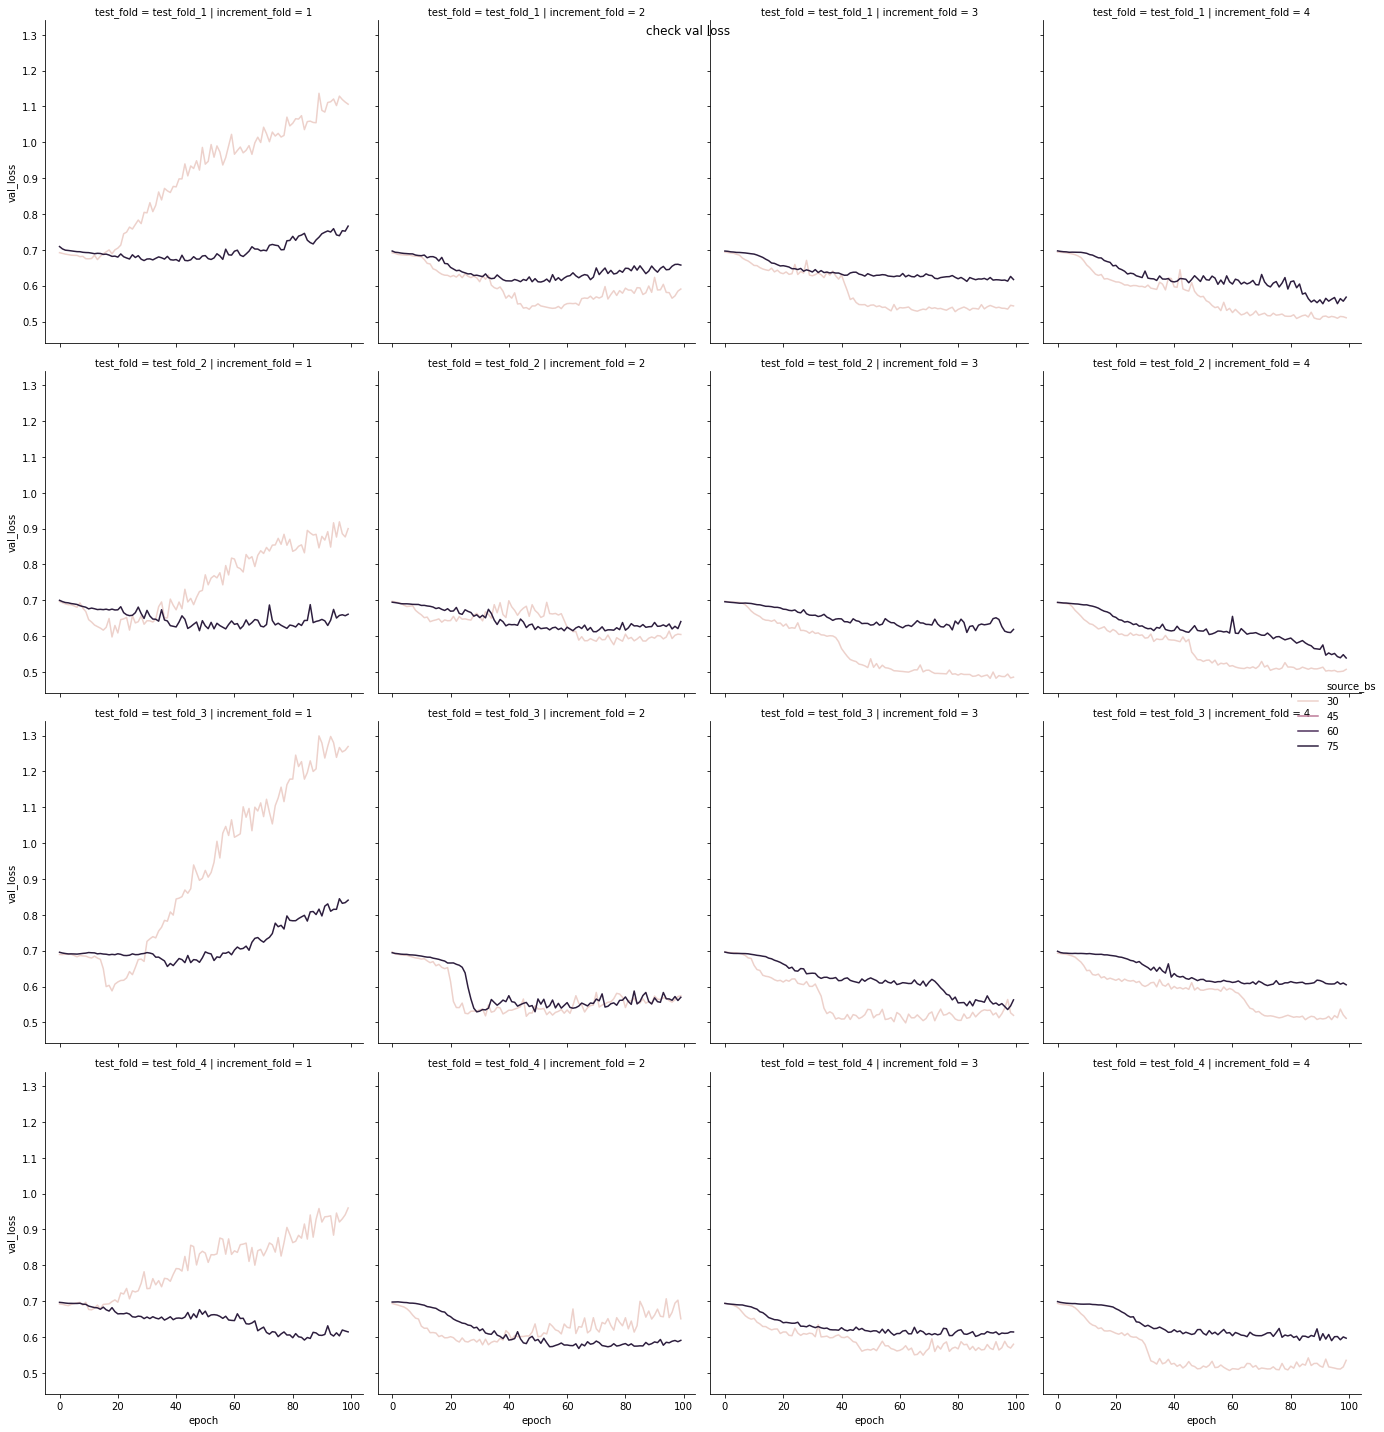

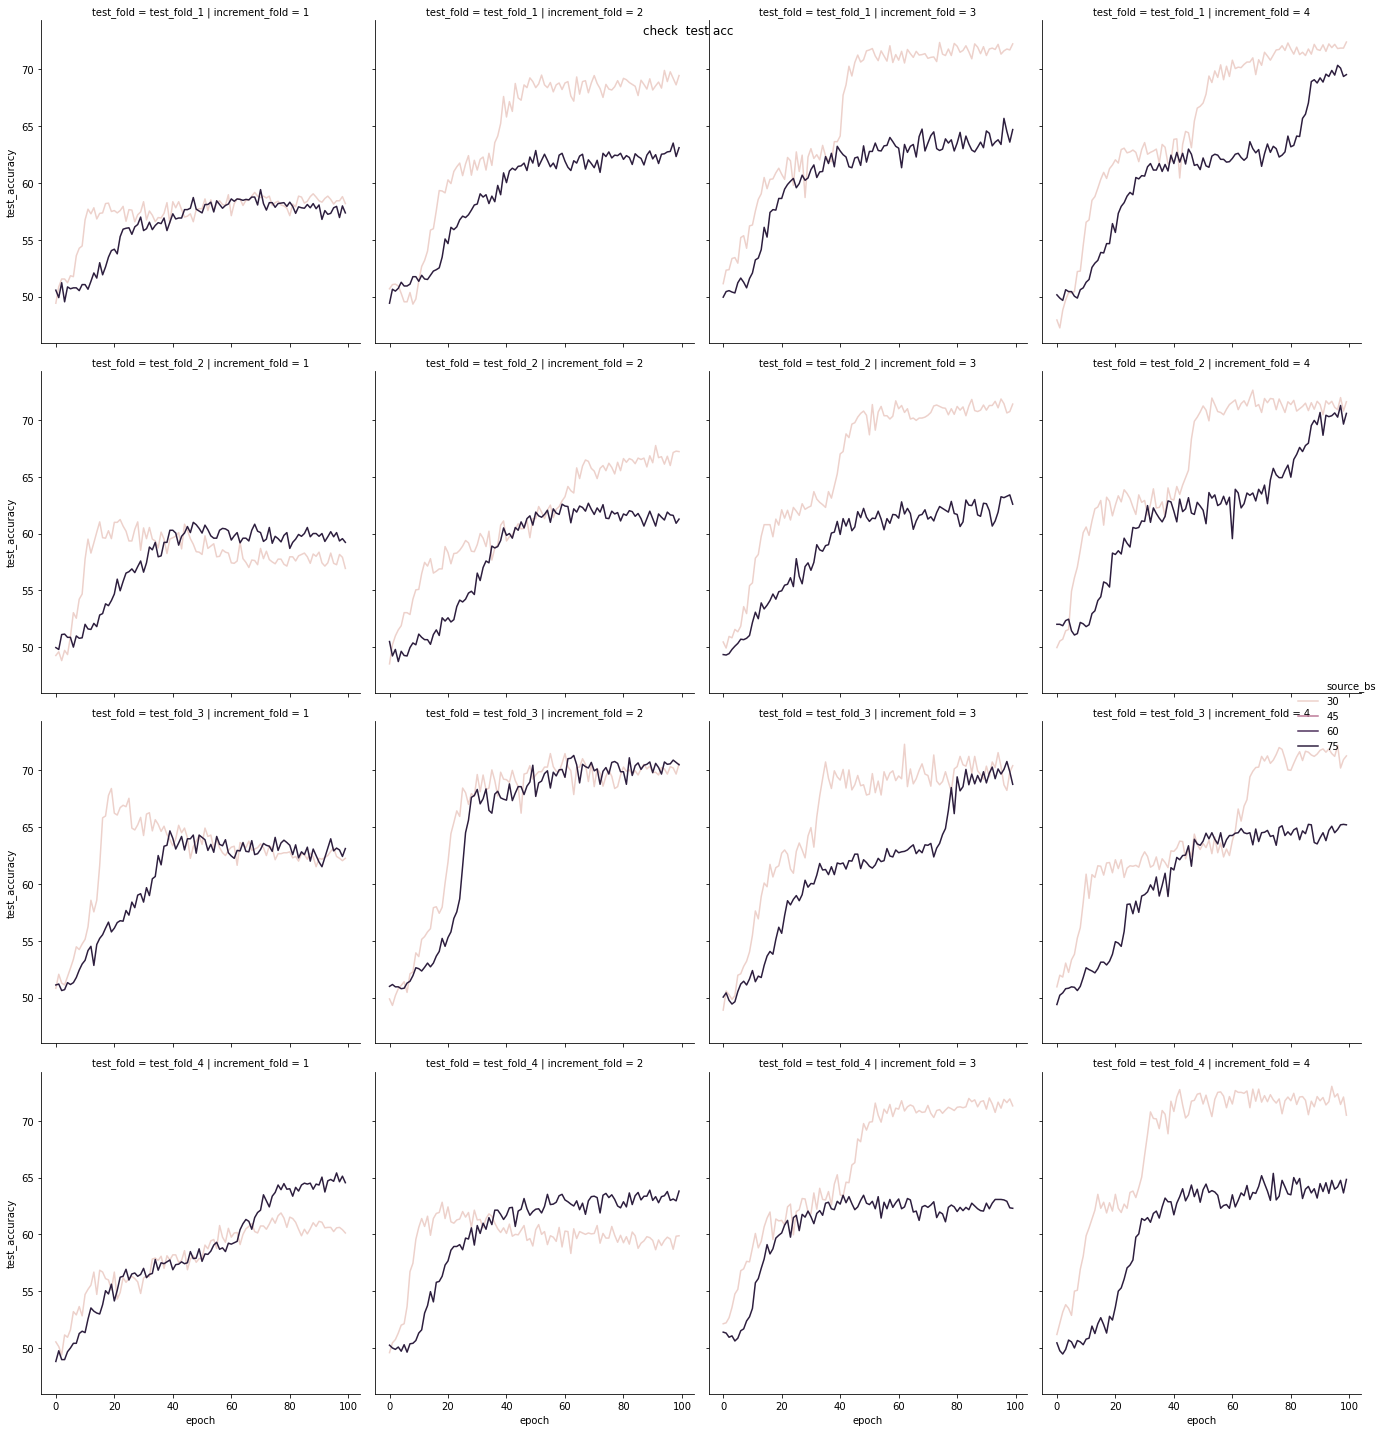

In [47]:


pick_cols = ["random_shuffle_seed","source_bs","dataset","test_fold","increment_fold","valid_fold","model","history_path"]
history_data = load_history_data(combine_data,pick_cols)
print(history_data.columns)

# data_case = history_data.groupby(["random_shuffle_seed","dataset","increment_fold","model","source_bs"],as_index=False).mean()

conditions = [
    ["random_shuffle_seed",["5"]]
]
data = filter_history_information(history_data,conditions)
print(data)
a = sns.relplot(
    data=data,x="epoch", y="val_loss", col="increment_fold",row="test_fold",
    hue="source_bs", kind="line", aspect = 0.9
)
a.add_legend()
a.fig.suptitle("check val loss")


conditions = [
    ["random_shuffle_seed",["5"]]
]
data = filter_history_information(history_data,conditions)
print(data)
a = sns.relplot(
    data=data,x="epoch", y="test_accuracy", col="increment_fold",row="test_fold",
    hue="source_bs", kind="line", aspect = 0.9
)
a.add_legend()
a.fig.suptitle("check  test acc")



# leg = a._legend
# leg.set_bbox_to_anchor([0.9, 0.5])  # coordinates of lower left of bounding box
# leg._loc = 2

# leg = a._legend
# leg.set_bbox_to_anchor([0.9, 0.5])  # coordinates of lower left of bounding box
# leg._loc = 2